![paylocity_banner](https://oregonbusinessindustry.com/wp-content/uploads/logo-paylocity.png)

# Project Proposal

Paylocity provides cloud-based HR and payroll software solutions designed to streamline workforce management and enhance employee engagement. This includes products such as:

- Payroll Processing
- Human Capital Management (Recruiting, onboarding, performance management, etc.)
- Time and Attendance
- Benefits Administration
- Employee Self-Service (Access to pay stubs, tax forms, reimbursements, etc.)
- Community
- LMS (Learning Management System)

We are looking to understand the Customer Lifetime Value (LTV) of Paylocity’s customer base. As a marketing analytics department, knowing an accurate LTV value allows us to set LTV/CAC targets, determine campaign budgets, and evaluate the effectiveness of marketing campaigns. Further, we’d like to understand how LTV differs across our clients. This will allow Paylocity to target more profitable prospects and prioritize leads who are already in the funnel.

### **Inputs:**

- Salesforce (Sales), Product, and Billing data.


| **Table Name**                                   | **Input Category**     | **Key**            | **Description**                                              | **Key Use Cases**                                            |
| ------------------------------------------------ | ---------------------- | -------------- | ------------------------------------------------------------ | ------------------------------------------------------------ |
| `company_profile`<br /> <font color='crimson'>*[Full]*</font>                 | **Salesforce (Sales)** | company_code | Contains account-level metadata from Salesforce: client stage, source, start/end dates, location, employee size, calculated segment, industry codes, etc. | Customer segmentation, company size, region, tenure estimation, churn logic |
| `billing`<br /> <font color='crimson'>*[Post-2024]*</font>                    | **Billing**            | company_id  | Provides recent billing activity over 30, 90, 180, and 365 days, along with last fiscal year (LFY) billing — likely used for recency/trend analysis. | Churn prediction, trend metrics, recent activity-based segmentation |
| `billing_historical`<br /> <font color='crimson'>*[Post-2021]*</font>         | **Billing**            | company_id   | Historical billing (FY21–FY25), aggregated at company level; core data for LTV calculation. | Tenure calculation, LTV estimation, churn tracking           |
| `billing_historical_linetype`<br /> <font color='crimson'>*[Post-2021]*</font>| **Product + Billing**  | company_id  | Same billing history as above, but broken down by `line_type` — useful for identifying revenue mix across service lines. | Product portfolio analysis, upsell/cross-sell patterns, key revenue drivers |
| `billing_historical_product`<br /> <font color='crimson'>*[Post-2021]*</font> | **Product + Billing**  | company_id   | Billing data broken down by hierarchical product groupings (1, 2, 3); most granular view of purchased services. | Product usage profiling, high-LTV product combinations, cluster modeling |


### **Business Questions:**

#### **1. LTV Calculation**

What factors should be considered in the LTV calculation?

- **Churn**

- **Average Tenure**

- **Upsell/Cross Sell**


#### **2. Financial Assumptions**

What discount rate should be used? What terminal value should be used?

> We aren’t looking for precise financial modeling – rather these should be ball-park assumptions made from a marketing perspective.

#### **3. LTV Segmentation**

How does LTV differ across customers? Factors to consider:

- Region
- Company Size
- Company Revenue
- Subscriptions to Paylocity Products

#### **4. How can we increase LTV?**

What can marketing do to attract high LTV prospects?

- Across the business (sales, operations, client services, finance, technology, etc.)
- What opportunities do we have to increase LTV?

# EDA

In [1]:
import time
start_time = time.time()

In [2]:
import pandas as pd
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns

# Suppress all warnings globally
import warnings
warnings.simplefilter("ignore")

In [3]:
# from google.colab import drive

# # Please watch the video "How to Access 'Shared with me' folder with Colab"
# drive.mount('/content/drive')
# file_path = '/content/drive/My Drive/#599 ACL Paylocity/Data/'

# df_profile = pd.read_csv(file_path + 'profile.csv').rename(columns={'company_code': 'company_id',
#                                                              'salesforce_account_id': 'account_id'})
# df_profile_full = pd.read_csv(file_path + 'profile_full.csv').rename(columns={'company_code': 'company_id',
#                                                                        'salesforce_account_id': 'account_id'})
# df_billing = pd.read_csv(file_path + 'billing_25.csv')
# df_hist = pd.read_csv(file_path + 'billing_history.csv')
# df_hist_line = pd.read_csv(file_path + 'billing_history_line.csv')
# df_hist_product = pd.read_csv(file_path + 'billing_history_product.csv')

df_profile = pd.read_csv('Data/profile.csv').rename(columns={'company_code': 'company_id',
                                                             'salesforce_account_id': 'account_id'})
df_profile_full = pd.read_csv('Data/profile_full.csv').rename(columns={'company_code': 'company_id',
                                                                       'salesforce_account_id': 'account_id'})
df_billing = pd.read_csv('Data/billing_25.csv')
df_hist = pd.read_csv('Data/billing_history.csv')
df_hist_line = pd.read_csv('Data/billing_history_line.csv')
df_hist_product = pd.read_csv('Data/billing_history_product.csv')

print(df_profile.shape)
print(df_profile_full.shape)
print(df_billing.shape)
print(df_hist.shape)
print(df_hist_line.shape)
print(df_hist_product.shape)

(92738, 19)
(167660, 20)
(213978, 8)
(239360, 9)
(568257, 10)
(3230728, 12)


In [4]:
full = df_profile_full['account_stage'].unique()
kept = df_profile['account_stage'].unique()

diff = set(full) - set(kept)

print('Filtered out classes:', diff)
print('Kept classes:', kept)

Filtered out classes: {'Lost Client', 'Implementation', 'Disqualified', 'Unprospected'}
Kept classes: ['Active Client' 'Prospecting' 'Qualify' 'Opportunity']


In [5]:
df_profile_full['escher_segment'].unique()

array(['Emerging', 'Majors', 'Enterprise', nan], dtype=object)

### Cross-Table Coverage Analysis

```sql
select
  t_name,
  row_cnt,
  id_cnt
from (
    select 'profile' t_name, count(*) row_cnt from company_profile
    union all
    select 'profile_full', count(*) from company_profile_no_filter
    union all
    select 'billing', count(*) from company_billing
    union all
    select '5_year_billing', count(*) from historical
    union all
    select '5_year_billing_line', count(*) from historical_by_line_type
    union all
    select '5_year_billing_product', count(*) from historical_by_product_group
) t1
join (
    select 'profile' t_name, count(distinct company_code) id_cnt from company_profile
    union all
    select 'profile_full', count(distinct company_code) from company_profile_no_filter
    union all
    select 'billing', count(distinct company_id) from company_billing
    union all
    select '5_year_billing', count(distinct company_id) from historical
    union all
    select '5_year_billing_line', count(distinct company_id) from historical_by_line_type
    union all
    select '5_year_billing_product', count(distinct company_id) from historical_by_product_group
) t2 using (t_name)
```

|   | t_name             | row_cnt | id_cnt |
| --- | ------------------ | ------- | ------ |
| 1   | profile            | 92738   | 92738  |
| 2   | profile_full       | 167660  | 167660 |
| 3   | billing            | 213978  | 110068 |
| 4   | 5_year_billing     | 239360  | 123688 |
| 5   | 5_year_billing_line| 568257  | 123688 |
| 6   | 5_year_billing_product | 3230728 | 123688 |

<!-- We conducted a consistency check across all available tables to assess whether `company_profile` accurately represents the full set of Paylocity clients. Contrary to our initial assumption, the table contains **fewer company IDs (92,738)** than the various billing tables — for example, the billing for the recent year contains over **110,000 unique company IDs**, while the five-year historical billing tables reach **123,688**.

This finding suggests that `company_profile` may not capture all billed clients, and should **not be used as the master client list** without further validation. -->

#### Active Clients with company_enddate:

Companies marked as 'Active' in the company_profile table should not have a `company_enddate` value.

However, 0.8% of these companies have a valid end date, which is a very small proportion and can be considered negligible.

---

> ***Farin mkt_analytics**: Possible sync issues between our systems (e.g. a customer tells us they will be leaving 6/30 so we stamp an end date on them, but we still need to bill them for current usage, so they stay as "active" for the time being). Agree that this is negligible.*

In [6]:
print(df_profile.query('account_stage == "Active Client"')['company_enddate'].isna().value_counts(), '\n')
print(df_profile.query('account_stage == "Active Client"')['company_enddate'].isna().value_counts(1))

company_enddate
True     91888
False      797
Name: count, dtype: int64 

company_enddate
True     0.991401
False    0.008599
Name: proportion, dtype: float64


#### Active Clients Missing in Billing Data

For the 'real' active clients, 11% of them do not appear in the 5-year billing data. Why are they still marked as 'active'? Could it be because they are very new customers?

> As for the 34% that only appear in the billing data but are not marked as 'Active' in the profile data, this seems reasonable if we assume these clients have churned in the latest record.
>> But we would still expect them to appear in the full, unfiltered profile data.

---

> ***Farin mkt_analytics**: There are customers that we don't bill for directly (e.g. franchisees, churches, other orgs with complex hierarchies). I'd consider removing these 11% from the dataset. Safe to assume churn for the 34%.*

In [7]:
prof_active_real = df_profile.query('account_stage == "Active Client" and company_enddate.isna()')['company_id']
hist = df_hist['company_id'].drop_duplicates()
merged_active = pd.merge(prof_active_real, hist, on='company_id', how='outer', indicator=True)
dist_active = merged_active['_merge'].value_counts(1)

print('Cross Checking Active Client IDs:')
print(f"• Percentage of IDs found in both: {dist_active.loc['both'] * 100:.2f}%")
print(f"• Percentage of IDs only in the profile data: {dist_active.loc['left_only'] * 100:.2f}%")
print(f"• Percentage of IDs only in the 5-year billing data: {dist_active.loc['right_only'] * 100:.2f}%")

Cross Checking Active Client IDs:
• Percentage of IDs found in both: 54.72%
• Percentage of IDs only in the profile data: 11.23%
• Percentage of IDs only in the 5-year billing data: 34.05%


#### Missing IDs in Profile Data

However, 3.23% of customers in the billing data are missing from the entire profile data. This is unusual, as we would expect the unfiltered profile data to cover all company IDs found in the 5-year historical billing data.

> On the other hand, the 28.61% of client IDs that only appear in the unfiltered profile data is reasonable, assuming the profile data should cover all client records in the system, thus including more than just the 5-year range of the billing data.

---

> ***Farin mkt_analytics**: I don't have a great explanation for the 3.23%. Would consider removing these from your analysis.*

<!-- ```py
# Extract unique company IDs from both tables
profile_ids = df_profile_full[['company_id']].drop_duplicates()
hist_ids = df_hist[['company_id']].drop_duplicates()

# Combine all unique IDs
all_ids = pd.concat([profile_ids, hist_ids], ignore_index=True).drop_duplicates()

# Left join to mark presence
all_ids = all_ids.merge(profile_ids.assign(in_profile=1), on='company_id', how='left')
all_ids = all_ids.merge(hist_ids.assign(in_hist=1), on='company_id', how='left')
all_ids = all_ids.merge(df_profile_full[['company_id', 'account_stage']], on='company_id', how='left')

# Replace missing indicators with 0 and convert to integer (0 = not found, 1 = found)
all_ids['in_profile'] = all_ids['in_profile'].fillna(0).astype(int)
all_ids['in_hist'] = all_ids['in_hist'].fillna(0).astype(int)

# Result
cond_both = (all_ids['in_profile'] == 1) & (all_ids['in_hist'] == 1)
cond_prof = (all_ids['in_profile'] == 1) & (all_ids['in_hist'] == 0)
cond_hist = (all_ids['in_profile'] == 0) & (all_ids['in_hist'] == 1)

print(f"Percentage of IDs that exist in both: {(all_ids[cond_both].shape[0] / all_ids.shape[0]) * 100:.2f}%")
print(f"Percentage of IDs that exist only in billing data: {(all_ids[cond_hist].shape[0] / all_ids.shape[0]) * 100:.2f}%")
print(f"Percentage of IDs that exist only in profile data: {(all_ids[cond_prof].shape[0] / all_ids.shape[0]) * 100:.2f}%")
``` -->

In [8]:
prof_total = df_profile_full['company_id']
hist = df_hist['company_id'].drop_duplicates()
merged_total = pd.merge(prof_total, hist, on='company_id', how='outer', indicator=True)
dist_total = merged_total['_merge'].value_counts(1)

print('Cross Checking Total Client IDs:')
print(f"• Percentage of IDs found in both: {dist_total.loc['both'] * 100:.2f}%")
print(f"• Percentage of IDs only in the profile data: {dist_total.loc['left_only'] * 100:.2f}%")
print(f"• Percentage of IDs only in the 5-year billing data: {dist_total.loc['right_only'] * 100:.2f}%")

Cross Checking Total Client IDs:
• Percentage of IDs found in both: 68.16%
• Percentage of IDs only in the profile data: 28.61%
• Percentage of IDs only in the 5-year billing data: 3.23%


Let's check the one-to-many relationship between bundle_name and product_group_1 by identifying all distinct product groups associated with each bundle, across all fiscal years (FY21–FY25).

In [9]:
# One-to-many mapping from bundle to product_group_1
billing_cols = ['FY21_Billing', 'FY22_Billing', 'FY23_Billing', 'FY24_Billing', 'twelvemonth_billing']
df_active = df_hist_product[df_hist_product[billing_cols].gt(0).any(axis=1)].copy()

df_active = df_active[(df_active['product_group_1'].notna()) & (df_active['bundle_name'].notna())]
df_active = df_active[df_active['product_group_1'].astype(str).str.strip().ne('')]

bundle_product_map = df_active[['bundle_name', 'product_group_1']].drop_duplicates().sort_values(['bundle_name', 'product_group_1'])

bundle_product_map = bundle_product_map.reset_index(drop=True)

# Display the result
bundle_product_map.groupby('bundle_name')['product_group_1'].count()

bundle_name
Complete HCM Solution                148
Efficient Tech                        58
Effortless Payroll                    50
Modern Workplace                      68
Modern Workplace Plus                 45
Monthly Officer Payroll               22
Paylocity Monthly NonPayroll Plan     32
Quarterly or Annual Payroll           15
Small Business Modern Workforce       13
Small Business Payroll                14
Stand Alone                           39
Name: product_group_1, dtype: int64

## Data Preprocessing

In [10]:
# Aggregate data by Client ID
billing_cols = ['FY21_Billing', 'FY22_Billing', 'FY23_Billing', 'FY24_Billing', 'twelvemonth_billing']
df_agg = df_hist.groupby('company_id')[billing_cols].sum().reset_index()

# Replace NULL values in billing columns with 0
df_agg[billing_cols] = df_agg[billing_cols].fillna(0)

# Count the number of fiscal years with non-zero billing to calculate tenure.
df_agg['tenure_billing'] = df_agg[billing_cols].gt(0).sum(axis=1)
# Replace tenure of 0 with 1 to avoid division by zero in later steps
df_agg['tenure_billing'] = df_agg['tenure_billing'].replace(0, 1)

# Calculate total and average billing across all years
df_agg['total_billing'] = df_agg[billing_cols].sum(axis=1)
df_agg['avg_billing'] = df_agg['total_billing'] / df_agg['tenure_billing']

In [11]:
# Calculate tenure based on profile data
df_profile_full['company_startdate'] = pd.to_datetime(df_profile['company_startdate'], errors='coerce')
df_profile_full['company_enddate'] = pd.to_datetime(df_profile['company_enddate'], errors='coerce')
df_agg = df_agg.merge(df_profile_full[['company_id', 'company_startdate', 'company_enddate']], on='company_id', how='left')

df_agg['tenure'] = ((df_agg['company_enddate'] - df_agg['company_startdate']) / pd.Timedelta(days=365)).round(2)
df_agg['tenure'] = np.where(
    # If tenure is NaN or tenure == 0 or tenure < tenure_billing
    (df_agg['tenure'].isna()) | (df_agg['tenure'] == 0) | (df_agg['tenure'] < df_agg['tenure_billing']),
    # Use tenure_billing
    df_agg['tenure_billing'],
    # Otherwise → keep original tenure
    df_agg['tenure']
)

# Create active flag based on whether there is FY25 billing data
df_agg['active'] = np.where(
    df_agg['twelvemonth_billing'].notna() & (df_agg['twelvemonth_billing'] > 0),
    1,
    0
)

### Retention (Portfolio)

In [12]:
# r_n: for those who were active in FYn-1, what percentage were active in FYn

# 2025 retention rate
cond_denom = (df_agg['FY24_Billing'].notna()) & (df_agg['FY24_Billing'] > 0)
cond_num = cond_denom & (df_agg['twelvemonth_billing'].notna()) & (df_agg['twelvemonth_billing'] > 0)

denom = df_agg[cond_denom].shape[0]
num = df_agg[cond_num].shape[0]

r_25 = num / denom

# 2024 retention rate
cond_denom = (df_agg['FY23_Billing'].notna()) & (df_agg['FY23_Billing'] > 0)
cond_num = cond_denom & (df_agg['FY24_Billing'].notna()) & (df_agg['FY24_Billing'] > 0)

denom = df_agg[cond_denom].shape[0]
num = df_agg[cond_num].shape[0]

r_24 = num / denom

# 2023 retention rate
cond_denom = (df_agg['FY22_Billing'].notna()) & (df_agg['FY22_Billing'] > 0)
cond_num = cond_denom & (df_agg['FY23_Billing'].notna()) & (df_agg['FY23_Billing'] > 0)

denom = df_agg[cond_denom].shape[0]
num = df_agg[cond_num].shape[0]

r_23 = num / denom

# 2022 retention rate
cond_denom = (df_agg['FY21_Billing'].notna()) & (df_agg['FY21_Billing'] > 0)
cond_num = cond_denom & (df_agg['FY22_Billing'].notna()) & (df_agg['FY22_Billing'] > 0)

denom = df_agg[cond_denom].shape[0]
num = df_agg[cond_num].shape[0]

r_22 = num / denom

# Result
r_avg = (r_25 + r_24 + r_23 + r_22) / 4

print(f"Retention Rate FY25: {r_25:.2%}")
print(f"Retention Rate FY24: {r_24:.2%}")
print(f"Retention Rate FY23: {r_23:.2%}")
print(f"Retention Rate FY22: {r_22:.2%}")
print(f"Average retention rate: {r_avg:.2%}")

Retention Rate FY25: 89.97%
Retention Rate FY24: 88.84%
Retention Rate FY23: 88.99%
Retention Rate FY22: 89.09%
Average retention rate: 89.22%


### Retention (Individual)

In [13]:
# Estimate retention rate:
# - For non-'active' rows: use 1 - 1 / tenure
# - For 'active' rows: impute using the 75th percentile of historical retention rates

# Step 1: Initialize with NaN
df_agg['r_client'] = np.nan

# Step 2: Compute retention rate for rows with numeric tenure
df_agg['r_client'] = 1 - 1 / df_agg['tenure'].astype(float)

# Step 3: Impute retention for 'active' rows using Q3 (75th percentile)
ret_q3 = df_agg['r_client'].quantile(0.75)
df_agg.loc[df_agg['active'] == 1, 'r_client'] = ret_q3

In [14]:
r_avg_client = df_agg['r_client'].mean()
print(f"Average retention rate per client: {r_avg_client:.2%}")

Average retention rate per client: 70.04%


### Growth (Billing)

In [15]:
# Billing growth from FY21 to FY25 (12-month billing)
# CAGR (Compound Annual Growth Rate) formula: geometric mean growth rate
# Define a safe CAGR function that avoids division by zero or negative values.
def safe_cagr(start, end, years):
    if start <= 0 or end <= 0:
        return 0
    return (end / start) ** (1 / years) - 1

df_agg['growth'] = df_agg.apply(
    lambda row: safe_cagr(row['FY21_Billing'], row['twelvemonth_billing'], years=4), axis=1
)

In [16]:
df_agg.head().T

,0,1,2,3,4
company_id,0102,0103,0104,0129,0131
FY21_Billing,2.0072,1.0268,0.7764,7.4546,0.5165
FY22_Billing,2.938,0.375,0.7088,8.4972,0.596
FY23_Billing,3.0486,0.0,0.2826,9.5995,0.7929
FY24_Billing,2.8714,0.0,0.7859,10.091,0.7854
twelvemonth_billing,2.9039,0.0,0.484,9.6389,0.7609
tenure_billing,5,2,5,5,5
total_billing,13.7691,1.4018,3.0377,45.2812,3.4517
avg_billing,2.75382,0.7009,0.60754,9.05624,0.69034
company_startdate,2025-01-09 00:00:00,2013-01-07 00:00:00,2024-01-11 00:00:00,NaT,NaT


#### New Client Rate

In [17]:
# Mark whether the client had billing in each fiscal year
df_agg['has_FY21'] = df_agg['FY21_Billing'].notna() & (df_agg['FY21_Billing'] > 0)
df_agg['has_FY22'] = df_agg['FY22_Billing'].notna() & (df_agg['FY22_Billing'] > 0)
df_agg['has_FY23'] = df_agg['FY23_Billing'].notna() & (df_agg['FY23_Billing'] > 0)
df_agg['has_FY24'] = df_agg['FY24_Billing'].notna() & (df_agg['FY24_Billing'] > 0)
df_agg['has_FY25'] = df_agg['twelvemonth_billing'].notna() & (df_agg['twelvemonth_billing'] > 0)

# New clients: those with billing this year but not the previous year
n_22_new = df_agg[(df_agg['has_FY22']) & (~df_agg['has_FY21'])].shape[0]
n_23_new = df_agg[(df_agg['has_FY23']) & (~df_agg['has_FY22'])].shape[0]
n_24_new = df_agg[(df_agg['has_FY24']) & (~df_agg['has_FY23'])].shape[0]
n_25_new = df_agg[(df_agg['has_FY25']) & (~df_agg['has_FY24'])].shape[0]

# Total number of active clients in each fiscal year
n_22_total = df_agg[df_agg['has_FY22']].shape[0]
n_23_total = df_agg[df_agg['has_FY23']].shape[0]
n_24_total = df_agg[df_agg['has_FY24']].shape[0]
n_25_total = df_agg[df_agg['has_FY25']].shape[0]

# New client rate = new clients / total clients in that year
n_22 = n_22_new / n_22_total if n_22_total > 0 else 0
n_23 = n_23_new / n_23_total if n_23_total > 0 else 0
n_24 = n_24_new / n_24_total if n_24_total > 0 else 0
n_25 = n_25_new / n_25_total if n_25_total > 0 else 0

n_avg = (n_22 + n_23 + n_24 + n_25) / 4

print(f"New client rate FY22: {n_22:.2%}")
print(f"New client rate FY23: {n_23:.2%}")
print(f"New client rate FY24: {n_24:.2%}")
print(f"New client rate FY25: {n_25:.2%}")
print(f"Average new client rate: {n_avg:.2%}")

New client rate FY22: 22.77%
New client rate FY23: 22.48%
New client rate FY24: 17.98%
New client rate FY25: 15.51%
Average new client rate: 19.69%


In [18]:
df_agg = df_agg.merge(df_profile_full[['company_id', 'calculated_segment']], on='company_id', how='left')

# Define new client columns for each fiscal year
df_agg['new_22'] = df_agg['has_FY22'] & (~df_agg['has_FY21'])
df_agg['new_23'] = df_agg['has_FY23'] & (~df_agg['has_FY22'])
df_agg['new_24'] = df_agg['has_FY24'] & (~df_agg['has_FY23'])
df_agg['new_25'] = df_agg['has_FY25'] & (~df_agg['has_FY24'])

df_temp = df_agg[['company_id', 'calculated_segment', 
                  'has_FY22', 'new_22', 
                  'has_FY23', 'new_23', 
                  'has_FY24', 'new_24', 
                  'has_FY25', 'new_25']]

summary = df_temp.groupby('calculated_segment').agg(
    total_22=('has_FY22', 'sum'),
    new_22=('new_22', 'sum'),
    total_23=('has_FY23', 'sum'),
    new_23=('new_23', 'sum'),
    total_24=('has_FY24', 'sum'),
    new_24=('new_24', 'sum'),
    total_25=('has_FY25', 'sum'),
    new_25=('new_25', 'sum')
)

# New client rates for each fiscal year
for year in ['22', '23', '24', '25']:
    summary[f'rate_{year}'] = summary[f'new_{year}'] / summary[f'total_{year}']

# Avg new client rate
summary['avg_new_client_rate'] = summary[[f'rate_{y}' for y in ['22','23','24','25']]].mean(axis=1)

summary_formatted = summary[['avg_new_client_rate']].copy()
summary_formatted['avg_new_client_rate'] = summary_formatted['avg_new_client_rate'].apply(lambda x: f"{x:.2%}")

summary_formatted.rename(index={
    'Inside Sales/Growth Markets': '1-Growth',
    'Majors': '2-Major',
    'Enterprise': '3-Enterprise'
}).reset_index().rename(columns={'calculated_segment': 'segment'}).set_index('segment').sort_index()

,avg_new_client_rate
segment,
1-Growth,20.51%
2-Major,15.58%
3-Enterprise,14.44%


#### Net New Client Rate

> *P.S. LTV inherently considers churn.*

In [19]:
net_n_22 = n_22 - (1 - r_22)
net_n_23 = n_23 - (1 - r_23)
net_n_24 = n_24 - (1 - r_24)
net_n_25 = n_25 - (1 - r_25)

net_n_avg = (net_n_22 + net_n_23 + net_n_24 + net_n_25) / 4

print(f"Net new client rate FY22: {net_n_22:.2%}")
print(f"Net new client rate FY23: {net_n_23:.2%}")
print(f"Net new client rate FY24: {net_n_24:.2%}")
print(f"Net new client rate FY25: {net_n_25:.2%}")
print(f"Net average new client rate: {net_n_avg:.2%}")

Net new client rate FY22: 11.87%
Net new client rate FY23: 11.47%
Net new client rate FY24: 6.82%
Net new client rate FY25: 5.48%
Net average new client rate: 8.91%


#### New Revenue Rate

In [20]:
# New customer revenue (= billing from new customers in that fiscal year)
rev_22_new = df_agg[(df_agg['has_FY22']) & (~df_agg['has_FY21'])]['FY22_Billing'].sum()
rev_23_new = df_agg[(df_agg['has_FY23']) & (~df_agg['has_FY22'])]['FY23_Billing'].sum()
rev_24_new = df_agg[(df_agg['has_FY24']) & (~df_agg['has_FY23'])]['FY24_Billing'].sum()
rev_25_new = df_agg[(df_agg['has_FY25']) & (~df_agg['has_FY24'])]['twelvemonth_billing'].sum()

# Total revenue (= total billing from all customers in that fiscal year)
rev_22_total = df_agg[df_agg['has_FY22']]['FY22_Billing'].sum()
rev_23_total = df_agg[df_agg['has_FY23']]['FY23_Billing'].sum()
rev_24_total = df_agg[df_agg['has_FY24']]['FY24_Billing'].sum()
rev_25_total = df_agg[df_agg['has_FY25']]['twelvemonth_billing'].sum()

# New revenue rate = revenue from new customers / total revenue
nr_22 = rev_22_new / rev_22_total if rev_22_total > 0 else 0
nr_23 = rev_23_new / rev_23_total if rev_23_total > 0 else 0
nr_24 = rev_24_new / rev_24_total if rev_24_total > 0 else 0
nr_25 = rev_25_new / rev_25_total if rev_25_total > 0 else 0

# Average new revenue rate
nr_avg = (nr_22 + nr_23 + nr_24 + nr_25) / 4

# Print results
print(f"New revenue rate FY22: {nr_22:.2%}")
print(f"New revenue rate FY23: {nr_23:.2%}")
print(f"New revenue rate FY24: {nr_24:.2%}")
print(f"New revenue rate FY25: {nr_25:.2%}")
print(f"Average new revenue rate: {nr_avg:.2%}")

New revenue rate FY22: 13.97%
New revenue rate FY23: 15.00%
New revenue rate FY24: 9.11%
New revenue rate FY25: 6.89%
Average new revenue rate: 11.24%


### CAC (Customer Acquisition Cost)

**Provided By Client:**

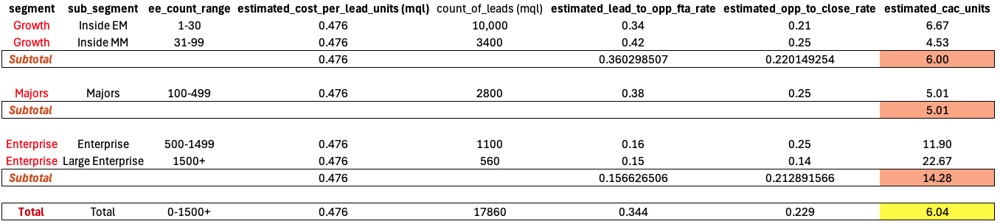

In [21]:
cac_1 = 6.00
cac_2 = 5.01
cac_3 = 14.28
cac = 6.04

### Company Size

- Inside Sales/Growth Markets: <100 employees.
- Majors: 100-499 employees.
- Enterprise: 500+ employees.

In [22]:
df_agg.drop(columns=['has_FY21', 'has_FY22','has_FY23', 'has_FY24', 'has_FY25'], inplace=True)

# Result
df = df_agg[['company_id', 'r_client', 'growth', 'tenure', 'active', 'total_billing', 'avg_billing', 'twelvemonth_billing', 'calculated_segment']]\
    .merge(df_profile_full[['company_id', 'sector']], on='company_id', how='left')\
    .rename(columns={'twelvemonth_billing': 'recent_billing'})

df.head()

,company_id,r_client,growth,tenure,active,total_billing,avg_billing,recent_billing,calculated_segment,sector
0,0102,0.8,0.096725,5.0,1,13.7691,2.75382,2.9039,Inside Sales/Growth Markets,Construction
1,0103,0.5,0.000000,2.0,0,1.4018,0.70090,0.0000,Inside Sales/Growth Markets,Construction
2,0104,0.8,-0.111433,5.0,1,3.0377,0.60754,0.4840,Inside Sales/Growth Markets,Construction
3,0129,0.8,0.066352,5.0,1,45.2812,9.05624,9.6389,Inside Sales/Growth Markets,Manufacturing
4,0131,0.8,0.101702,5.0,1,3.4517,0.69034,0.7609,Inside Sales/Growth Markets,"Professional, Scientific, and Technical Services"


In [23]:
df['calculated_segment'].value_counts(1, dropna=False)

calculated_segment
Inside Sales/Growth Markets    0.788678
Majors                         0.149400
NaN                            0.045574
Enterprise                     0.016348
Name: proportion, dtype: float64

We map each sales segment to a proxy headcount value based on defined thresholds:

- Inside Sales / Growth Markets: <100 → 50
- Majors: 100–499 → 250
- Enterprise: 500+ → 500 (lower bound assumption)

Clients with missing segment labels are defaulted to 50 to avoid overestimation.

In [24]:
segment_to_size = {
    'Inside Sales/Growth Markets': 50,
    'Majors': 250,
    'Enterprise': 500
}

df['headcount'] = df['calculated_segment'].map(segment_to_size)
df['headcount'] = df['headcount']

### Health

In [25]:
df_health = pd.read_csv('Data/health_status.csv')\
              .merge(df_profile_full[['account_id', 'company_id']], on='account_id', how='left')
# df_health = pd.read_csv(file_path + 'health_status.csv')\
#               .merge(df_profile_full[['account_id', 'company_id']], on='account_id', how='left')
print(df_health.shape)
df_health.head()

(256621, 5)


,account_id,status,fiscal_year,days_in_status,company_id
0,0011500001LC7CnAAL,Green,2024,70,CS0000
1,0011500001LC7CnAAL,Green,2025,319,CS0000
2,0011500001LC7CoAAL,Green,2024,70,CS0001
3,0011500001LC7CoAAL,Green,2025,293,CS0001
4,0011500001LC7CoAAL,Yellow,2025,26,CS0001


In [26]:
df_ = df_hist[['company_id']].drop_duplicates()\
             .merge(df_profile_full[['company_id', 'account_id']], on='company_id', how='left')

df_ = df_[['account_id']].merge(df_health[['account_id']].drop_duplicates(),
                                on='account_id', how='left', indicator=True)

df_.set_index('account_id').value_counts()

_merge    
both          77229
left_only     46459
right_only        0
Name: count, dtype: int64

In [27]:
health = df_health.pivot_table(
    index=['company_id', 'fiscal_year'],
    columns='status',
    values='days_in_status',
    aggfunc='sum',
    fill_value=0
).reset_index().set_index('company_id')

health.columns.name = None  # remove index name
health.head()

,fiscal_year,Black,Blue,Green,Grey,Red,Yellow
company_id,,,,,,,
0102,2024,0,0,70,0,0,0
0102,2025,0,0,289,0,0,30
0103,2024,199,0,0,0,0,0
0103,2025,319,0,0,0,0,0
0104,2024,62,0,41,0,0,0


In [28]:
# Step 1: Scale by dividing each status count by 365 to get annual proportions
status_cols = ['Black', 'Blue', 'Green', 'Grey', 'Red', 'Yellow']
health_scaled = health.copy()
health_scaled[status_cols] = health_scaled[status_cols] / 365

# Step 2: Ordinal re-encoding
status_weights = {
    'Green': 0,
    'Yellow': 1,
    'Red': 2,
    'Grey': 3,
    'Black': 4,
    'Blue': None
}

# Step 3: weighted average risk score
def compute_risk_score(row):
    score = 0
    total_weight = 0
    for status, weight in status_weights.items():
        proportion = row.get(status, 0)
        if weight is not None:
            score += weight * proportion
            total_weight += proportion
    return score if total_weight > 0 else None

health_scaled['risk_score'] = health_scaled.apply(compute_risk_score, axis=1)

<Axes: >

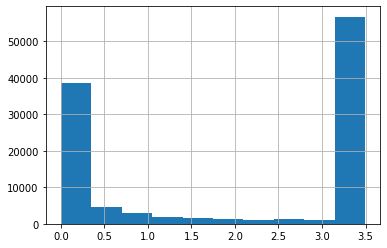

In [29]:
health_scaled.query('fiscal_year == 2025')['risk_score'].hist()

In [30]:
risk_score = health_scaled.reset_index().pivot(index='company_id', columns='fiscal_year', values='risk_score').reset_index()\
                          .rename(columns={2024: 'risk_2024', 2025: 'risk_2025'})
risk_score.columns.name = None

In [31]:
# ① Use 2025 risk score as the most recent snapshot (often used for behavioral modeling)
# risk_score['risk_recent'] = risk_score['risk_2025']

# ② Compute the average across 2024 and 2025 (captures long-term trend)
risk_score['risk_avg'] = risk_score[['risk_2024', 'risk_2025']].mean(axis=1)

# ③ Compute a weighted average (putting more weight on 2025)
risk_score['risk_wvg'] = np.where(
    risk_score['risk_2024'].isna(),
    risk_score['risk_2025'],
    0.3 * risk_score['risk_2024'] + 0.7 * risk_score['risk_2025']
)

# ④ Calculate risk change metrics (used for modeling improvement or deterioration)
risk_score['risk_diff'] = risk_score['risk_2025'] - risk_score['risk_2024']
risk_score['risk_diff'] = risk_score['risk_diff'].fillna(0)
risk_score['risk_pct_change'] = risk_score['risk_diff'] / risk_score['risk_2024'].replace(0, np.nan)
risk_score['risk_pct_change'] = risk_score['risk_pct_change'].replace([np.inf, -np.inf], np.nan)

# ⑤ Flag 2025 new clients (useful for non-tree models that can’t handle NaNs well)
risk_score['is_new_2025'] = risk_score['risk_2024'].isna().astype(int)

In [32]:
risk_score

,company_id,risk_2024,risk_2025,risk_avg,risk_wvg,risk_diff,risk_pct_change,is_new_2025
0,0102,0.000000,0.082192,0.041096,0.057534,0.082192,NaN,0
1,0103,2.180822,3.495890,2.838356,3.101370,1.315068,0.603015,0
2,0104,0.679452,0.000000,0.339726,0.203836,-0.679452,-1.000000,0
3,0121,2.180822,3.495890,2.838356,3.101370,1.315068,0.603015,0
4,0126,2.254795,3.495890,2.875342,3.123562,1.241096,0.550425,0
...,...,...,...,...,...,...,...,...
110899,Y7459,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0
110900,Y8509,0.347945,3.495890,1.921918,2.551507,3.147945,9.047244,0
110901,Z16758,NaN,0.000000,0.000000,0.000000,0.000000,NaN,1
110902,Z21000,NaN,0.410959,0.410959,0.410959,0.000000,NaN,1


### **Behavioral Signals**

#### **Cross-sell Detection**

Identify whether a customer has adopted *new* product groups on a year-on-year level.

- `cross_sell_flag`: Boolean indicator whether cross-sell occurred
- `cross_sell_count`: Number of new product groups were added throughout 5 years
- `cross_sell_yr_count`: Number of times new product groups were added YoY

In [33]:
# Rename billing fields
year_cols = {
    'FY21': 'FY21_Billing',
    'FY22': 'FY22_Billing',
    'FY23': 'FY23_Billing',
    'FY24': 'FY24_Billing',
    'FY25': 'twelvemonth_billing'
}

# Build product sets, removing NaNs within sets
product_sets = {}

for year, col in year_cols.items():
    active = df_hist_product[df_hist_product[col] > 0].copy()
    active['product_group_1'] = active['product_group_1'].fillna('')  # or dropna
    product_sets[year] = (
        active.groupby('company_id')['product_group_1']
        .apply(lambda x: set(i for i in x if i and str(i).lower() != 'nan'))
    )

df_cross = pd.DataFrame(product_sets)

# Clean out rows with all-NaN or empty sets
df_cross = df_cross.applymap(lambda x: x if isinstance(x, set) else set())

# Count true cross-sell (exclude first active year)
def count_cross_sells_year(row):
    count = 0
    active_years = [y for y in row.index if isinstance(row[y], set) and row[y]]
    active_years.sort()

    if not active_years:
        return 0

    seen = set(row[active_years[0]])  # add first year to seen

    for i in range(1, len(active_years)):  # start from the second year
        current = row[active_years[i]]
        new_products = current - seen
        if new_products:
            count += 1
        seen.update(current)

    return count

# Count how many unique product_group_1 were added across years (cross-sold)
def count_unique_cross_products(row):
    active_years = [y for y in row.index if isinstance(row[y], set) and row[y]]
    active_years.sort()
    seen = set()
    new_products = set()

    for i in range(len(active_years)):
        current = row[active_years[i]]
        new = current - seen
        if i > 0:  # exclude first year
            new_products.update(new)
        seen.update(current)

    return len(new_products)

df_cross['cross_sell_yr_count'] = df_cross.apply(count_cross_sells_year, axis=1)
df_cross['cross_sell_flag'] = (df_cross['cross_sell_yr_count'] > 0).astype(int)
df_cross['cross_sell_count'] = df_cross.apply(count_unique_cross_products, axis=1)

df_cross.sort_values('cross_sell_yr_count', ascending=False)

,FY21,FY22,FY23,FY24,FY25,cross_sell_yr_count,cross_sell_flag,cross_sell_count
company_id,,,,,,,,
41832,"{HR, Delivery, Labor Law Poster, W2, Time & La...","{Adjustment, HR, Delivery, W2, Time & Labor, G...","{HR, Delivery, W2, Time & Labor, Garnishment M...","{HR, Delivery, ACA/Compliance, Marketplace - E...","{HR, Delivery, Carrier EDI Files, ACA/Complian...",4,1,7
41966,"{Adjustment, HR, Delivery, LMS, Marketplace - ...","{HR, Delivery, LMS, Marketplace - External HR ...","{Adjustment, HR, Delivery, Marketplace - Carri...","{Adjustment, HR, Delivery, LMS, ACA/Compliance...","{HR, Delivery, LMS, Carrier EDI Files, ACA/Com...",4,1,6
57489,"{Adjustment, HR, Delivery, LMS, W2, Employee S...","{Recruiting, HR, Delivery, LMS, W2, Employee S...","{Recruiting, HR, Delivery, LMS, Payroll, Marke...","{Recruiting, HR, Delivery, LMS, ACA/Compliance...","{Recruiting, HR, Delivery, LMS, ACA/Compliance...",4,1,5
9673,"{HR, Delivery, W2, Time & Labor, Garnishment M...","{Adjustment, Recruiting, HR, Delivery, Expense...","{Recruiting, HR, Delivery, Marketplace - Carri...","{Recruiting, HR, Delivery, ACA/Compliance, Exp...","{Recruiting, HR, Delivery, ACA/Compliance, Exp...",4,1,7
123115,"{HR, Delivery, HR Edge, Garnishment Managed Se...","{HR, Delivery, Marketplace - Carrier Connect, ...","{HR, Delivery, Benefits, HR Edge, Garnishment ...","{Adjustment, HR, Delivery, HR Edge, ACA/Compli...","{Adjustment, HR, Delivery, HR Edge, ACA/Compli...",4,1,11
...,...,...,...,...,...,...,...,...
318624,{},{},{},{},"{HR, General Ledger, Time & Labor, Payroll}",0,0,0
318625,{},{},{},{},"{Community, ACA/Compliance, Scheduling Plus, T...",0,0,0
318626,{},{},{},{},"{HR, Delivery, Labor Law Poster, Expense, Payr...",0,0,0


#### **Upsell Detection**

Detect whether a customer shows an increasing trend in recurring billing amounts on product level over time.

To identify meaningful upsell behavior, we apply a growth threshold—typically between **5% and 10%**—rather than flagging any increase. This helps **filter out small fluctuations** caused by billing cycles, pricing changes, or noise. In our analysis, we use **10%** as a baseline to capture significant signals of product expansion.

- `upsell_flag`: Boolean indicator whether upsell occurred
- `upsell_count`: Number of product groups were upsold throughout 5 years
- `avg_upsell_growth`: Average upsell growth rate across all products for that client

In [34]:
upsell_threshold = 0.1

# Aggregate billing by company_id and product_group_1
billing_cols = ['FY21_Billing', 'twelvemonth_billing']
df_prod = df_hist_product.groupby(['company_id', 'product_group_1'])[billing_cols].sum().reset_index()

# Compute CAGR per product per company
df_prod['upsell_growth'] = df_prod.apply(
    lambda row: safe_cagr(row['FY21_Billing'], row['twelvemonth_billing'], years=4), axis=1
)

# Mark whether this product was upsold
df_prod['upsell_flag_prod'] = df_prod['upsell_growth'] > upsell_threshold

# Aggregate to company-level upsell
df_upsell = df_prod.groupby('company_id').agg(
    upsell_flag=('upsell_flag_prod', 'any'),
    upsell_count=('upsell_flag_prod', 'sum'),
    avg_upsell_growth=('upsell_growth', 'mean')
).reset_index()

df_upsell['upsell_flag'] = df_upsell['upsell_flag'].astype(int)

df_upsell.sort_values('upsell_count', ascending=False)

,company_id,upsell_flag,upsell_count,avg_upsell_growth
20203,133046,1,19,0.341372
16142,127215,1,18,0.248415
16530,127630,1,18,0.206652
20236,133080,1,18,0.182218
20136,132962,1,18,0.121696
...,...,...,...,...
48753,175250,0,0,0.000000
48752,175249,0,0,0.000000
48751,175248,0,0,0.000000
48750,175247,0,0,0.000000


In [35]:
df_upsell.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122313 entries, 0 to 122312
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   company_id         122313 non-null  object 
 1   upsell_flag        122313 non-null  int64  
 2   upsell_count       122313 non-null  int64  
 3   avg_upsell_growth  122313 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 3.7+ MB


In [36]:
# Add cross-sell indicators
df = df.merge(df_cross[['cross_sell_flag', 'cross_sell_yr_count', 'cross_sell_count']],
              left_on='company_id', right_index=True, how='left')
df[['cross_sell_yr_count', 'cross_sell_flag', 'cross_sell_count']] = df[['cross_sell_yr_count', 'cross_sell_flag', 'cross_sell_count']].fillna(0)

df = df.merge(df_upsell, on='company_id', how='left')
df[['upsell_flag', 'upsell_count']] = df[['upsell_flag', 'upsell_count']].fillna(0)

## Summary

In [37]:
print(df.columns)
df.describe().T

Index(['company_id', 'r_client', 'growth', 'tenure', 'active', 'total_billing',
       'avg_billing', 'recent_billing', 'calculated_segment', 'sector',
       'headcount', 'cross_sell_flag', 'cross_sell_yr_count',
       'cross_sell_count', 'upsell_flag', 'upsell_count', 'avg_upsell_growth'],
      dtype='object')


,count,mean,std,min,25%,50%,75%,max
r_client,123688.0,0.700402,0.225748,0.000000,0.750000,0.80000,0.800000,0.942922
growth,123688.0,0.028227,0.143411,-0.931923,0.000000,0.00000,0.000000,3.598097
tenure,123688.0,3.156788,1.528540,1.000000,2.000000,3.00000,5.000000,17.520000
active,123688.0,0.745545,0.435556,0.000000,0.000000,1.00000,1.000000,1.000000
total_billing,123688.0,44.552682,104.608212,0.000000,3.918400,13.62575,42.069275,4996.378300
avg_billing,123688.0,12.054128,25.544960,0.000000,1.748045,4.60321,12.357375,1505.383867
recent_billing,123688.0,12.065528,30.064546,0.000000,0.000000,3.19750,11.607550,1788.484300
headcount,118051.0,89.014494,90.596683,50.000000,50.000000,50.00000,50.000000,500.000000
cross_sell_flag,123688.0,0.645430,0.478385,0.000000,0.000000,1.00000,1.000000,1.000000
cross_sell_yr_count,123688.0,1.039163,0.995086,0.000000,0.000000,1.00000,2.000000,4.000000


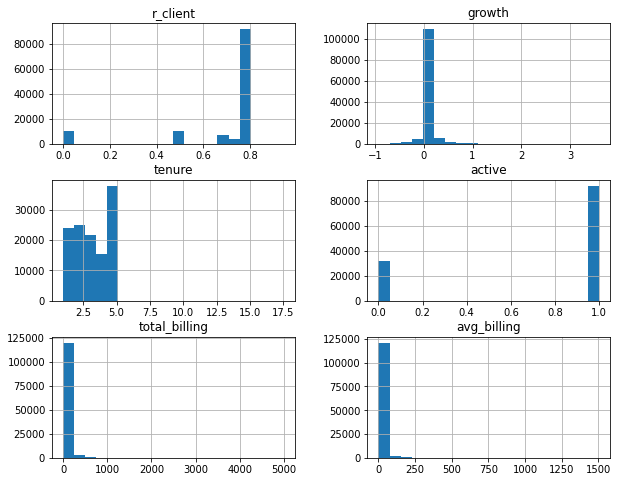

In [38]:
num_cols = ['r_client', 'growth', 'tenure', 'active', 'total_billing', 'avg_billing']

df[num_cols].hist(figsize=(10, 8), bins=20)
plt.show()

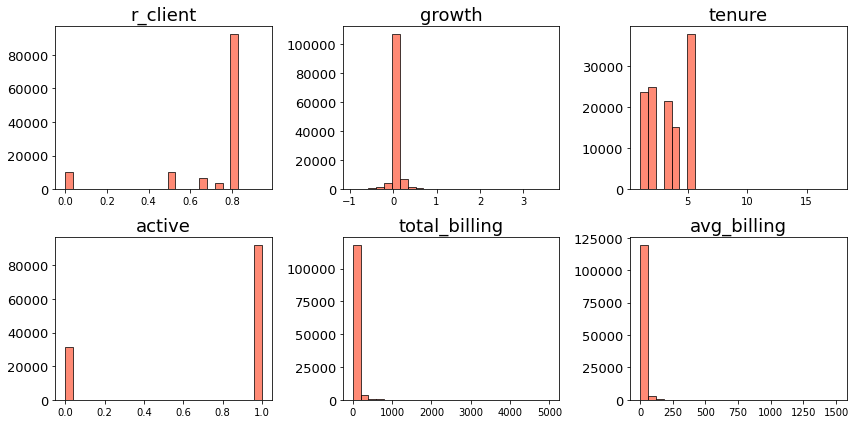

In [39]:
# Subplot grid
n_cols = 3
n_rows = (len(num_cols) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 3))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each histogram
for i, col in enumerate(num_cols):
    sns.histplot(df[col], bins=25, kde=False, ax=axes[i], color='tomato')
    axes[i].set_title(col, fontsize=18)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='y', labelsize=13)

# Remove empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Exploratory Visualizations

In [40]:
df_visual = df.merge(df_profile_full[['company_id', 'account_stage', 'account_source',
                                      'former_service_group', 'company_status', 'company_city',
                                      'company_state', 'country', 'naics',
                                      'escher_segment', 'sub_sector', 'industry']],
                on='company_id', how='left')

### Top Sectors by Active Client Count

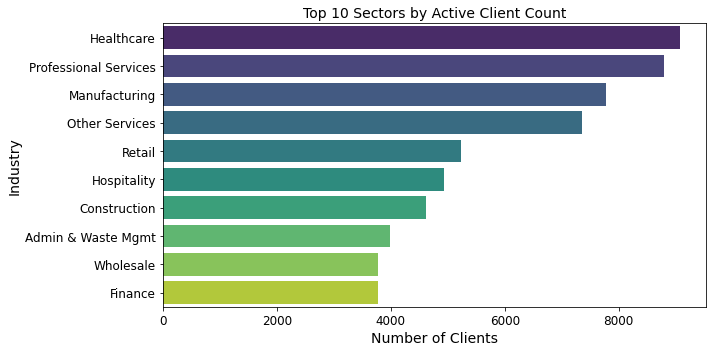

In [41]:
top_industries = df_visual.query('active == 1')['sector'].value_counts().nlargest(10)

sector_short_names = {
    'Health Care and Social Assistance': 'Healthcare',
    'Professional, Scientific, and Technical Services': 'Professional Services',
    'Manufacturing': 'Manufacturing',
    'Other Services (except Public Administration)': 'Other Services',
    'Retail Trade': 'Retail',
    'Construction': 'Construction',
    'Accommodation and Food Services': 'Hospitality',
    'Administrative and Support and Waste Management and Remediation Services': 'Admin & Waste Mgmt',
    'Wholesale Trade': 'Wholesale',
    'Finance and Insurance': 'Finance',
    'Restaurant/Bar': 'Restaurants',
    'Business Services': 'Business Services'}
top_industries.index = top_industries.index.map(sector_short_names)

plt.figure(figsize=(10, 5))
sns.barplot(x=top_industries.values, y=top_industries.index, palette="viridis")

plt.title("Top 10 Sectors by Active Client Count", fontsize=14)
plt.xlabel("Number of Clients", fontsize=14)
plt.ylabel("Industry", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

### Top Sectors by Active Client Billing

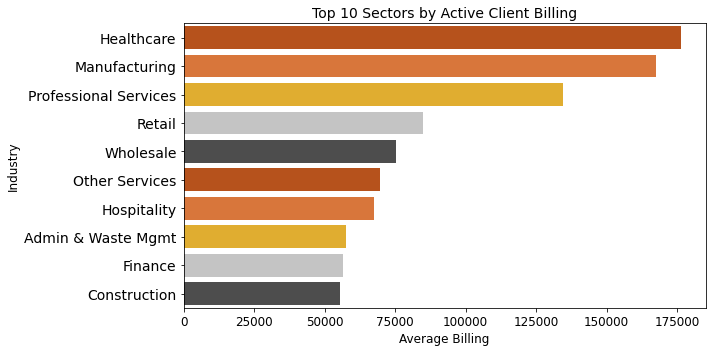

In [42]:
top_industries = df_visual.query('active == 1').groupby('sector')['avg_billing'].sum().nlargest(10)

top_industries.index = top_industries.index.map(sector_short_names)

plt.figure(figsize=(10, 5))
pcty_colors = ["#D04A02", "#F26F21", "#FDB913", "#C4C4C4", "#4D4D4D"]
sns.barplot(x=top_industries.values, y=top_industries.index, palette=pcty_colors)

plt.title("Top 10 Sectors by Active Client Billing", fontsize=14)
plt.xlabel("Average Billing", fontsize=12)
plt.ylabel("Industry", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)

plt.tight_layout()
plt.show()

### Geographical Distribution

#### State-wise Client Distribution (Top 10 States)

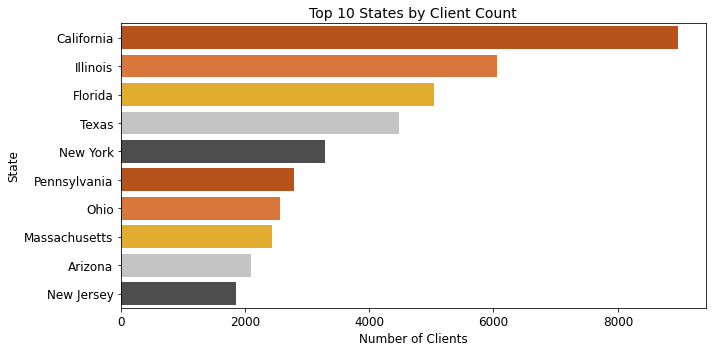

In [43]:
# %pip install -q us
import us

state_abbrev_to_name = {state.abbr: state.name for state in us.states.STATES}

top_states = df_visual['company_state'].value_counts().nlargest(10)
top_states.index = top_states.index.map(state_abbrev_to_name)

plt.figure(figsize=(10, 5))
pcty_colors = ["#D04A02", "#F26F21", "#FDB913", "#C4C4C4", "#4D4D4D"]
sns.barplot(x=top_states.values, y=top_states.index, palette=pcty_colors)

plt.title("Top 10 States by Client Count", fontsize=14)
plt.xlabel("Number of Clients", fontsize=12)
plt.ylabel("State", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

#### City-wise Client Distribution (Top 10 Cities)

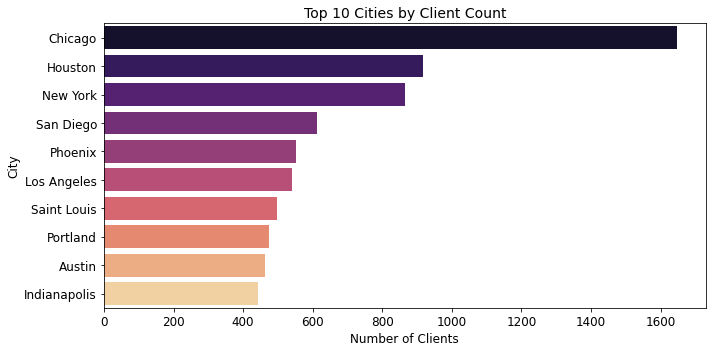

In [44]:
top_cities = df_visual['company_city'].value_counts().nlargest(10)

plt.figure(figsize=(10, 5))
sns.barplot(x=top_cities.values, y=top_cities.index, palette="magma")

plt.title("Top 10 Cities by Client Count", fontsize=14)
plt.xlabel("Number of Clients", fontsize=12)
plt.ylabel("City", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

#### Country-wise Client Distribution (Top 10 Countries)

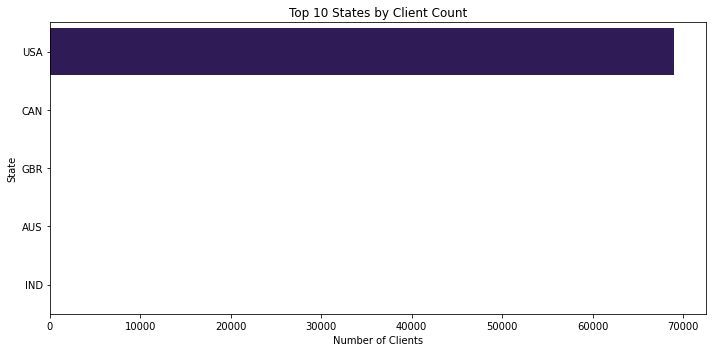

In [45]:
top_countries = df_visual['country'].value_counts().nlargest(5)

plt.figure(figsize=(10, 5))
sns.barplot(x=top_countries.values, y=top_countries.index, palette="magma")
plt.title("Top 10 States by Client Count")
plt.xlabel("Number of Clients")
plt.ylabel("State")
plt.tight_layout()
plt.show()

In [46]:
df_visual['country'].value_counts().nlargest(10)

country
USA    69037
CAN       23
GBR        8
AUS        5
IND        5
CHN        4
MEX        4
BRA        3
ARE        3
CRI        2
Name: count, dtype: int64

In [47]:
df_visual['country'].isna().sum()

54573

### Segment Distribution

In [48]:
segment_billing = df_visual.groupby('calculated_segment')['avg_billing'].sum()
total_billing = df_visual['avg_billing'].sum()
segment_counts = df_visual['calculated_segment'].value_counts()

billing_summary = pd.DataFrame({
    'client_count': segment_counts,
    'avg_billing_sum': segment_billing,
    'billing_ratio': segment_billing / total_billing
})
billing_summary = billing_summary.rename(index={
    'Inside Sales/Growth Markets': '1-Growth',
    'Majors': '2-Major',
    'Enterprise': '3-Enterprise'
})
billing_summary.sort_index().style.format({'billing_ratio': "{:.2%}", 'avg_billing_sum': "{:,.0f}"})

,client_count,avg_billing_sum,billing_ratio
calculated_segment,,,
1-Growth,97550,"581,858",39.03%
2-Major,18479,"630,411",42.28%
3-Enterprise,2022,"239,223",16.04%


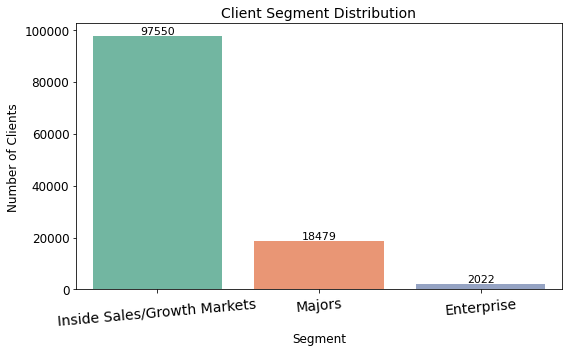

In [49]:
segment_counts = df_visual['calculated_segment'].value_counts()

plt.figure(figsize=(8, 5))
ax = sns.barplot(x=segment_counts.index, y=segment_counts.values, palette="Set2")

plt.title("Client Segment Distribution", fontsize=14)
plt.xlabel("Segment", fontsize=12)
plt.ylabel("Number of Clients", fontsize=12)
plt.xticks(rotation=5, fontsize=14)
plt.yticks(fontsize=12)

for container in ax.containers:
    ax.bar_label(container, fontsize=11)

plt.tight_layout()
plt.show()

### Top Industries by Client Count with Retention Overlay

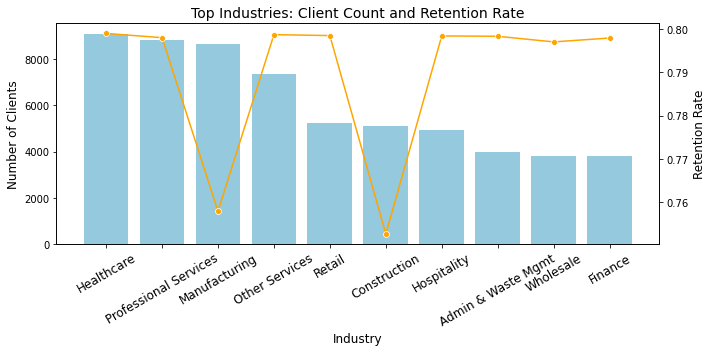

In [50]:
industry_stats = df_visual.groupby('sector').agg(
    client_count=('company_id', 'count'),
    retention_rate=('r_client', 'mean')
).sort_values('client_count', ascending=False).head(10)

industry_stats = industry_stats.rename(index=sector_short_names)

# Plot
fig, ax1 = plt.subplots(figsize=(10, 5))
sns.barplot(data=industry_stats, x=industry_stats.index, y='client_count', ax=ax1, color='skyblue')
ax1.set_ylabel('Number of Clients', fontsize=12)
ax1.set_xlabel('Industry', fontsize=12)
ax1.tick_params(axis='x', labelrotation=30, labelsize=12)
ax1.tick_params(axis='y', labelsize=10)

ax2 = ax1.twinx()
sns.lineplot(data=industry_stats, x=industry_stats.index, y='retention_rate', ax=ax2, color='orange', marker='o')
ax2.set_ylabel('Retention Rate', fontsize=12)
ax2.tick_params(axis='y', labelsize=10)


plt.title("Top Industries: Client Count and Retention Rate", fontsize=14)
plt.tight_layout()
plt.show()

### Do Higher-Billing Clients Stay Longer?

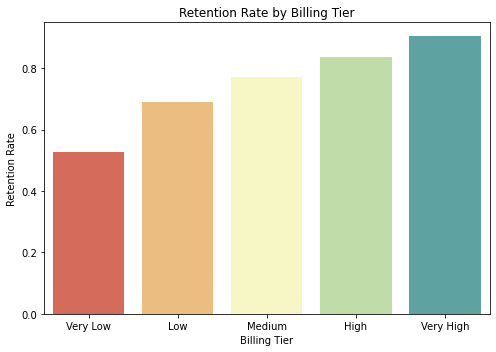

In [51]:
df_visual['billing_group'] = pd.qcut(df_visual['avg_billing'], 5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])

retention_by_billing = df_visual.groupby('billing_group')['active'].mean() # Across all years

plt.figure(figsize=(7, 5))
sns.barplot(x=retention_by_billing.index, y=retention_by_billing.values, palette="Spectral")
plt.title("Retention Rate by Billing Tier")
plt.xlabel("Billing Tier")
plt.ylabel("Retention Rate")
plt.tight_layout()
plt.show()

Clients in higher billing tiers show significantly higher retention rates, indicating that revenue size may be positively correlated with long-term engagement.

# **1. LTV Benchmark**

We plan to estimate LTV using a **closed-form discounted cash flow (DCF)** formula commonly used in marketing analytics:
$$
LTV = \sum_{t=0}^{\infty} m \cdot \left[\frac{r(1 + g)}{1 + i}\right]^t \iff LTV = m \cdot \frac{1 + i}{1 + i - r(1 + g)}
$$
Where:

- $m$ = average annual billing per customer
- $r$ = estimated annual retention rate, based on observed billing continuity across FY21–FY25
- $g$ = assumed revenue growth rate (e.g., upsell/cross-sell uplift)
- $i$ = discount rate (following sponsor guidance, we will use a baseline of 4% and conduct sensitivity tests across a range from 4% to 10%, or up to 20%)

## Key Assumptions

#### Retention Rate

- Revenue Retention Rate: [Form 10-K for Paylocity Holding Corp, Page 34](https://investors.paylocity.com/static-files/fa4bda99-4129-4790-98fa-34f3f4862472)

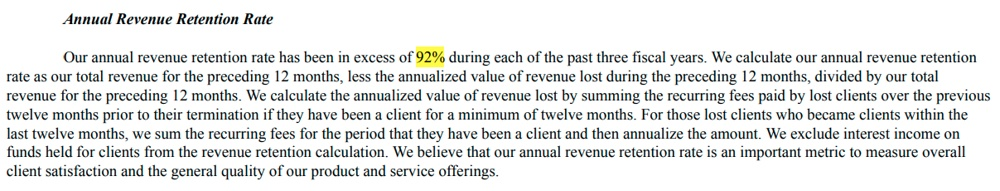

#### WACC

- Industrial Assumption: [Cost of Equity and Capital (US)](https://pages.stern.nyu.edu/~adamodar/New_Home_Page/datafile/wacc.html) from [Aswath Damodaran's Data Page](https://pages.stern.nyu.edu/~adamodar/New_Home_Page/data.html).

| Industry Name                  | Number of Firms | Beta | Cost of Equity | E/(D+E) | Std Dev in Stock | Cost of Debt | Tax Rate | After-tax Cost of Debt | D/(D+E) | Cost of Capital |
|:--------------------------------|:----------------|:-----|:---------------|:--------|:-----------------|:------------|:---------|:----------------------|:--------|:----------------|
| Software (Entertainment)        | 81              | 1.18 | 9.70%          | 97.57%  | 66.63%            | 6.41%        | 6.73%    | 4.81%                  | 2.43%   | 9.58%            |
| Software (Internet)             | 29              | 1.69 | 11.88%         | 89.65%  | 55.62%            | 5.78%        | 2.18%    | 4.34%                  | 10.35%  | 11.10%           |
| Software (System & Application) | 333             | 1.24 | 9.96%          | 95.33%  | 63.63%            | 5.78%        | 4.44%    | 4.34%                  | 4.67%   | <font color='crimson'>**9.69%**</font>            |

#### Growth Rate

- Perpetual Growth Rate: [United States Annual Inflation Rates](https://www.usinflationcalculator.com/inflation/current-inflation-rates/)
- Industrial Growth: [United States Historical Growth Rate in Earnings by Industry](https://view.officeapps.live.com/op/view.aspx?src=https%3A%2F%2Fpages.stern.nyu.edu%2F~adamodar%2Fpc%2Fdatasets%2Fhistgr.xls&wdOrigin=BROWSELINK) from [Aswath Damodaran's Data Page](https://pages.stern.nyu.edu/~adamodar/New_Home_Page/datacurrent.html#growth).

| Industry Name                   | Number of Firms | CAGR in Net Income (Last 5Y) | CAGR in Revenues (Last 5Y) | Expected Revenue Growth (Next 2Y) | Expected Revenue Growth (Next 5Y) | Expected EPS Growth (Next 5Y) |
|---------------------------------|------------------|-------------------------------|------------------------------|------------------------------------|-----------------------------------|-------------------------------|
| Software (Entertainment)        | 81               | 0.26%                         | 28.07%                       | 13.87%                             | 9.95%                            | 19.77%                       |
| Software (Internet)             | 29               | 22.12%                        | 19.72%                       | 13.34%                             | 12.26%                           | 22.39%                       |
| Software (System & Application) | 333              | 23.26%                        | 15.55%                       | 15.67%                             | <font color='crimson'>**13.19%**</font>                          | 21.83%                       |


## Calculation

In [52]:
# Parameter settings
r_0 = r_avg    # baseline retention rate: average across all clients
i_0 = 0.0969      # baseline discount rate: industry-average WACC (weighted average cost of capital)
g_0 = (7 + 6.5 + 3.4 + 2.9 + 2.4) / 100 / 5    # baseline growth rate: US inflation rate (5-year average)

# Calculate LTV using the closed-form DCF formula
def compute_ltv(m, g=g_0, r=r_0, i=i_0):
    denominator = 1 + i - r * (1 + g)
    if denominator <= 0:
        return np.nan
    return m * (1 + i) / denominator

def ltv_info(r=r_0, g=g_0, i=i_0):
    denominator = 1 + i - r * (1 + g)
    print(f"Baseline retention rate: {r:.2%}")
    print(f"Baseline discount rate: {i:.2%}")
    print(f"Baseline growth rate: {g:.2%}")
    print(f"Denominator validity check: {denominator > 0}")

ltv_info(r_0, g_0, i_0)

Baseline retention rate: 89.22%
Baseline discount rate: 9.69%
Baseline growth rate: 4.44%
Denominator validity check: True


#### Adjusting Client-Level LTV to Account for New Customers

Individual client LTV only captures the expected value from each **existing customer** over their lifetime, and **does not account for new customer acquisition**.

To approximate the impact of **new customer growth** on company-level revenue using LTV, one simplified method is to multiply the average LTV by **the expected number of new customers**, or equivalently, apply a **growth rate multiplier** to the current LTV total. 

However, this approach assumes:
- New customers will behave similarly to current ones (same LTV),
- And it typically only captures the **first-year addition** unless you model future cohorts recursively.

Thus, while this technique gives a **quick directional estimate**, it is not a substitute for more accurate cohort-based or cash-flow models when precision matters.

In [53]:
# Apply the LTV formula to each customer row
# Baseline/benchmark version as a starting point
df['LTV_v0'] = df['avg_billing'].apply(lambda x: compute_ltv(x))

# Result
df.sort_values('LTV_v0', ascending=False).head()

,company_id,r_client,growth,tenure,active,total_billing,avg_billing,recent_billing,calculated_segment,sector,headcount,cross_sell_flag,cross_sell_yr_count,cross_sell_count,upsell_flag,upsell_count,avg_upsell_growth,LTV_v0
115201,BMP168,0.8,0.000000,3.0,1,4516.1516,1505.383867,1509.6018,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.00000,10003.765103
18577,130666,0.8,0.000000,4.0,1,4996.3783,1249.094575,1200.4920,Enterprise,Wholesale Trade,500.0,1.0,3.0,4.0,0.0,0.0,0.00000,8300.639455
122143,P012,0.8,0.000000,2.0,1,2226.5871,1113.293550,1788.4843,NaN,NaN,NaN,1.0,1.0,2.0,0.0,0.0,0.00000,7398.197504
9854,115578,0.8,0.010042,5.0,1,4842.4780,968.495600,960.3102,Enterprise,Wholesale Trade,500.0,1.0,2.0,12.0,1.0,5.0,0.06469,6435.968061
37053,158259,0.8,0.000000,3.0,1,2821.4788,940.492933,928.7927,Enterprise,Health Care and Social Assistance,500.0,1.0,2.0,7.0,0.0,0.0,0.00000,6249.881239


In [54]:
def summarize_ltv_metrics(df, ltv_col, cac_total, cac_dict,
                          segment_col='calculated_segment', active_col='active',
                          avg_col='avg_billing', recent_col='recent_billing'):
    """
    Returns:
        segment_stats: full metrics with all intermediate columns
        display_table: trimmed & rounded table for presentation
            - Average LTV
            - LTV multipliers (vs avg billing & recent billing)
            - LTV / CAC
    """
    active_df = df.query(f'{active_col} == 1')
    ltv_avg = active_df[ltv_col].mean()
    ltv_sum = active_df[ltv_col].sum()

    avg_total = active_df[avg_col].sum()
    recent_total = active_df[recent_col].sum()

    multiplier = ltv_sum / avg_total
    multiplier_rec = ltv_sum / recent_total

    print(f"Average {ltv_col}: {ltv_avg:.2f}")
    print(f"LTV Multiplier ({ltv_col}): {multiplier:.2f}")
    print(f"LTV Multiplier @Recent ({ltv_col}): {multiplier_rec:.2f}")
    print("-" * 50)

    ltv_cac = ltv_avg / cac_total
    print(f"Overall LTV/CAC: {ltv_cac:.2f}")

    segment_stats = active_df.groupby(segment_col).agg(
        avg_ltv=(ltv_col, 'mean'),
        total_ltv=(ltv_col, 'sum'),
        total_avg=(avg_col, 'sum'),
        total_recent=(recent_col, 'sum')
    )

    # Multiplier
    segment_stats['ltv_multiplier'] = segment_stats['total_ltv'] / segment_stats['total_avg']
    segment_stats['ltv_multiplier_recent'] = segment_stats['total_ltv'] / segment_stats['total_recent']

    # Segment LTV / CAC
    segment_stats['ltv_cac'] = segment_stats.apply(
        lambda row: row['avg_ltv'] / cac_dict.get(row.name, np.nan), axis=1
    )

    # Add total row
    segment_stats.loc['Total'] = {
        'avg_ltv': ltv_avg,
        'ltv_cac': ltv_cac,
        'ltv_multiplier': multiplier,
        'ltv_multiplier_recent': multiplier_rec
    }

    # Rename for sort order
    segment_stats.index = segment_stats.index.map({
        'Inside Sales/Growth Markets': '1-Growth',
        'Majors': '2-Major',
        'Enterprise': '3-Enterprise',
        'Total': 'Total'
    })

    display_cols = ['avg_ltv', 'ltv_cac', 'ltv_multiplier', 'ltv_multiplier_recent']
    display_table = segment_stats[display_cols].round(2).sort_index()

    return display_table, segment_stats

In [55]:
cac_total = cac  # baseline CAC
cac_dict = {
    'Inside Sales/Growth Markets': cac_1,
    'Majors': cac_2,
    'Enterprise': cac_3
}

table_v0, segment_stats = summarize_ltv_metrics(df, 'LTV_v0', cac, cac_dict)
table_v0

Average LTV_v0: 94.93
LTV Multiplier (LTV_v0): 6.65
LTV Multiplier @Recent (LTV_v0): 5.87
--------------------------------------------------
Overall LTV/CAC: 15.72


,avg_ltv,ltv_cac,ltv_multiplier,ltv_multiplier_recent
calculated_segment,,,,
1-Growth,44.91,7.49,6.65,6.08
2-Major,247.42,49.39,6.65,5.71
3-Enterprise,878.05,61.49,6.65,5.76
Total,94.93,15.72,6.65,5.87


#### Truncated

In [56]:
# Define truncated LTV function for T-year horizon
def trunc_ltv(m, g, r, i, T):
    ltv = 0
    for t in range(1, T + 1):
        cf_t = r**t * (1 + g)**t * (1 / (1 + i)**t)
        ltv += cf_t
    return m * ltv

In [57]:
def summarize_trunc_ltv(df, g, r, i):
    """
    Compute and summarize both full_horizon and incremental LTV values.

    Parameters:
    - g, r, i: Can be scalar or string (column name in df)
    """

    def _get_val(row, val):
        return row[val] if isinstance(val, str) else val

    df = df.copy()

    # Step 1: Compute cumulative LTVs
    for T in [1, 5, 10]:
        df[f'LTV_{T}yr'] = df.apply(lambda row: trunc_ltv(
            row['avg_billing'],
            _get_val(row, g),
            _get_val(row, r),
            _get_val(row, i),
            T
        ), axis=1)

    df['LTV_full'] = df.apply(lambda row: compute_ltv(
        row['avg_billing'],
        _get_val(row, g),
        _get_val(row, r),
        _get_val(row, i)
    ), axis=1)

    # Step 2: Compute incremental LTVs
    df['LTV_5yr_only'] = df['LTV_5yr'] - df['LTV_1yr']
    df['LTV_10yr_only'] = df['LTV_10yr'] - df['LTV_5yr']
    df['LTV_10plus'] = df['LTV_full'] - df['LTV_10yr']

    # Step 3: Filter active customers
    df = df.query('active == 1')

    total = df['avg_billing'].sum()
    recent = df['recent_billing'].sum()

    def _print_summary(label):
        col = f'LTV_{label}'
        ltv_avg = df[col].mean()
        ltv_sum = df[col].sum()
        mult = ltv_sum / total
        mult_rec = ltv_sum / recent
        print(f"Average LTV ({label}): {ltv_avg:.2f}")
        print(f"LTV Multiplier ({label}): {mult:.2f}")
        print(f"LTV Multiplier @Recent ({label}): {mult_rec:.2f}")
        print("-" * 50)

    # Step 4: Print summaries
    print("\n" + "=" * 30)
    print("🔵 Cumulative LTV Summary (Full Horizon)")
    print("=" * 30)
    for label in ['1yr', '5yr', '10yr', 'full']:
        _print_summary(label)

    print("\n" + "=" * 30)
    print("🟠 Incremental LTV Summary")
    print("=" * 30)
    for label in ['1yr', '5yr_only', '10yr_only', '10plus']:
        _print_summary(label)

    return df

In [58]:
_ = summarize_trunc_ltv(df, g_0, r_0, i_0)


🔵 Cumulative LTV Summary (Full Horizon)
Average LTV (1yr): 12.14
LTV Multiplier (1yr): 0.85
LTV Multiplier @Recent (1yr): 0.75
--------------------------------------------------
Average LTV (5yr): 44.96
LTV Multiplier (5yr): 3.15
LTV Multiplier @Recent (5yr): 2.78
--------------------------------------------------
Average LTV (10yr): 64.86
LTV Multiplier (10yr): 4.54
LTV Multiplier @Recent (10yr): 4.01
--------------------------------------------------
Average LTV (full): 94.93
LTV Multiplier (full): 6.65
LTV Multiplier @Recent (full): 5.87
--------------------------------------------------

🟠 Incremental LTV Summary
Average LTV (1yr): 12.14
LTV Multiplier (1yr): 0.85
LTV Multiplier @Recent (1yr): 0.75
--------------------------------------------------
Average LTV (5yr_only): 32.83
LTV Multiplier (5yr_only): 2.30
LTV Multiplier @Recent (5yr_only): 2.03
--------------------------------------------------
Average LTV (10yr_only): 19.89
LTV Multiplier (10yr_only): 1.39
LTV Multiplier @Rec

In [59]:
_ = summarize_trunc_ltv(df, g_0, r_0, i_0)


🔵 Cumulative LTV Summary (Full Horizon)
Average LTV (1yr): 12.14
LTV Multiplier (1yr): 0.85
LTV Multiplier @Recent (1yr): 0.75
--------------------------------------------------
Average LTV (5yr): 44.96
LTV Multiplier (5yr): 3.15
LTV Multiplier @Recent (5yr): 2.78
--------------------------------------------------
Average LTV (10yr): 64.86
LTV Multiplier (10yr): 4.54
LTV Multiplier @Recent (10yr): 4.01
--------------------------------------------------
Average LTV (full): 94.93
LTV Multiplier (full): 6.65
LTV Multiplier @Recent (full): 5.87
--------------------------------------------------

🟠 Incremental LTV Summary
Average LTV (1yr): 12.14
LTV Multiplier (1yr): 0.85
LTV Multiplier @Recent (1yr): 0.75
--------------------------------------------------
Average LTV (5yr_only): 32.83
LTV Multiplier (5yr_only): 2.30
LTV Multiplier @Recent (5yr_only): 2.03
--------------------------------------------------
Average LTV (10yr_only): 19.89
LTV Multiplier (10yr_only): 1.39
LTV Multiplier @Rec

## Visualization

In [60]:
def plot_ltv_analysis(df, ltv_col, segment_col='calculated_segment', active_col='active', title_suffix=''):
    """
    Generate 4 subplots to analyze the distribution of LTV by segment:
    - Raw histogram
    - Violin plot
    - Log-transformed histogram
    - Scatter plot vs avg_billing
    """
    # 1. Generate log-transformed column
    log_col = f'{ltv_col}log'
    df[log_col] = np.log(df[ltv_col] + 1e-6)  # add small value to avoid log(0)

    # 2. Create figure
    fig, axs = plt.subplots(2, 2, figsize=(14, 10))
    plt.subplots_adjust(hspace=0.3, wspace=0.3, right=0.83)

    # Filter only active rows
    active_df = df.query(f'{active_col} == 1')

    # Plot 1: Histogram of LTV
    sns.histplot(
        data=active_df,
        x=ltv_col,
        hue=segment_col,
        bins=100,
        kde=True,
        element='step',
        stat='density',
        common_norm=False,
        ax=axs[0, 0]
    )
    axs[0, 0].set_title(f'{ltv_col} Distribution by Segment {title_suffix}', fontsize=14)
    axs[0, 0].set_xlabel(ltv_col)
    axs[0, 0].set_ylabel('Density')
    axs[0, 0].grid(True)

    # Plot 2: Violin plot
    sns.violinplot(
        data=active_df,
        x=segment_col,
        y=ltv_col,
        hue=segment_col,
        scale='width',
        inner='box',
        cut=0,
        dodge=False,
        ax=axs[0, 1]
    )
    axs[0, 1].set_title(f'{ltv_col} by Segment (Violin) {title_suffix}', fontsize=14)
    axs[0, 1].set_xlabel('Segment')
    axs[0, 1].set_ylabel(ltv_col)
    axs[0, 1].tick_params(axis='x', rotation=15)
    axs[0, 1].grid(True, axis='y', linestyle='--', alpha=0.4)

    # Plot 3: Log histogram
    sns.histplot(
        data=active_df,
        x=log_col,
        hue=segment_col,
        bins=100,
        kde=True,
        element='step',
        stat='density',
        common_norm=False,
        ax=axs[1, 0]
    )
    axs[1, 0].set_title(f'Log({ltv_col}) Distribution by Segment {title_suffix}', fontsize=14)
    axs[1, 0].set_xlabel(f'Log({ltv_col})')
    axs[1, 0].set_ylabel('Density')
    axs[1, 0].grid(True)

    # Plot 4: Scatter vs avg_billing
    plot4 = sns.scatterplot(
        data=df,
        x='avg_billing',
        y=ltv_col,
        hue=segment_col,
        alpha=0.5,
        ax=axs[1, 1]
    )
    axs[1, 1].set_title(f'Avg Billing vs LTV {title_suffix}', fontsize=14)
    axs[1, 1].set_xlabel('Average Billing')
    axs[1, 1].set_ylabel(ltv_col)
    axs[1, 1].grid(True)

    # Shared legend
    handles, labels = plot4.get_legend_handles_labels()
    fig.legend(handles, labels, title='Segment', loc='center left', bbox_to_anchor=(1.0, 0.92), fontsize=12, title_fontsize=12)

    # Remove per-plot legends
    for ax in axs.flat:
        if ax.get_legend():
            ax.legend_.remove()

    plt.tight_layout()
    plt.show()

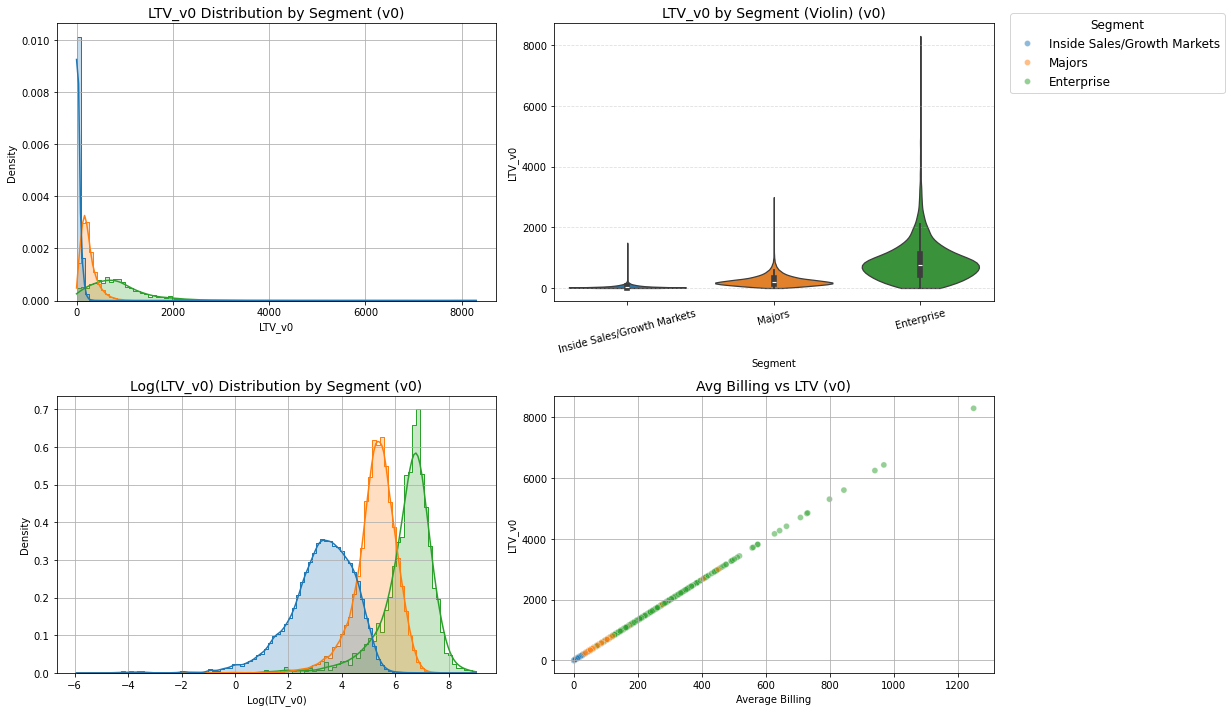

In [61]:
plot_ltv_analysis(df, ltv_col='LTV_v0', title_suffix='(v0)')

The coefficient $\frac{1 + i}{1 + i - r(1 + g)}$ is constant since we're using the same $g$, $r$, and $i$ for the basedline model.

# **2. Retention Modeling**

- **Linear Regression**
<br>→ Predicting **tenure** to explore how profile features relate to client longevity.

- **Logistic Regression**
<br>→ Using **r_client** (active or not) as the target to test how well profile features explain retention in a simple linear classification setup.

- **Random Forest**
<br>→ If linear regression underperforms, Random Forest can improve accuracy while also providing feature importance — helping us understand which attributes (like industry or company size) matter most.

- **XGBoost**
<br>→ For the most performant model, XGBoost is a strong candidate — suitable for final reporting or productized modeling.

In [62]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

### Assessing Predictive Utility of Profile Features

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123688 entries, 0 to 123687
Data columns (total 19 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   company_id           123688 non-null  object 
 1   r_client             123688 non-null  float64
 2   growth               123688 non-null  float64
 3   tenure               123688 non-null  float64
 4   active               123688 non-null  int64  
 5   total_billing        123688 non-null  float64
 6   avg_billing          123688 non-null  float64
 7   recent_billing       123688 non-null  float64
 8   calculated_segment   118051 non-null  object 
 9   sector               99125 non-null   object 
 10  headcount            118051 non-null  float64
 11  cross_sell_flag      123688 non-null  float64
 12  cross_sell_yr_count  123688 non-null  float64
 13  cross_sell_count     123688 non-null  float64
 14  upsell_flag          123688 non-null  float64
 15  upsell_count     

In [64]:
df_r = df.merge(df_profile_full[['company_id', 'account_stage', 'account_source',
                                'former_service_group', 'company_status', 'company_city',
                                'company_state', 'country', 'naics',
                                'escher_segment', 'sub_sector', 'industry']],
                on='company_id', how='left')

df_r.drop(columns=['LTV_v0', 'LTV_v0log', 'r_client', 'total_billing'], inplace=True)

In [65]:
df_r.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123688 entries, 0 to 123687
Data columns (total 26 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   company_id            123688 non-null  object 
 1   growth                123688 non-null  float64
 2   tenure                123688 non-null  float64
 3   active                123688 non-null  int64  
 4   avg_billing           123688 non-null  float64
 5   recent_billing        123688 non-null  float64
 6   calculated_segment    118051 non-null  object 
 7   sector                99125 non-null   object 
 8   headcount             118051 non-null  float64
 9   cross_sell_flag       123688 non-null  float64
 10  cross_sell_yr_count   123688 non-null  float64
 11  cross_sell_count      123688 non-null  float64
 12  upsell_flag           123688 non-null  float64
 13  upsell_count          123688 non-null  float64
 14  avg_upsell_growth     122313 non-null  float64
 15  

#### Missing Values

In [66]:
missing_rate = df_r.isnull().sum() / df_r.shape[0]
missing_rate[missing_rate > 0].sort_values(ascending=False) * 100

account_source          90.843089
former_service_group    60.298493
escher_segment          44.404469
country                 44.121499
company_state           43.395479
company_city            43.378501
industry                43.378501
sub_sector              43.377692
company_status          43.374458
naics                   43.374458
sector                  19.858838
calculated_segment       4.557435
headcount                4.557435
account_stage            4.521053
avg_upsell_growth        1.111668
dtype: float64

In [67]:
cols_to_drop = missing_rate[missing_rate > 0.5].index.tolist()
df_r = df_r.drop(columns=cols_to_drop)

cols_to_fill = missing_rate[(missing_rate > 0) & (missing_rate <= 0.5)].index.tolist()
for col in cols_to_fill:
    if df_r[col].dtype == 'float64':
        pass
    else:
        df_r[col] = df_r[col].fillna('Unknown')

df_r['naics'] = df_r['naics'].fillna('Unknown')

print(f"Dropped columns: {cols_to_drop}")
print(df_r.isnull().sum().sum())

Dropped columns: ['account_source', 'former_service_group']
7012


#### Multicollinearity

In [68]:
from sklearn.model_selection import KFold

df_r = df_r.set_index('company_id', drop=True)

# K-Fold cross-validation for target encoding
target = df_r['tenure']
kf = KFold(n_splits=5, shuffle=True, random_state=42)
global_mean = target.mean()

for col in df_r.select_dtypes(include='object').columns:
    df_r[col + '_te'] = np.nan  # Create new columns for target encoding
    for train_idx, val_idx in kf.split(df_r):
        mean_target = df_r.iloc[train_idx].groupby(col)[target.name].mean()
        df_r.iloc[val_idx, df_r.columns.get_loc(col + '_te')] = df_r.iloc[val_idx][col].map(mean_target)
    df_r.drop(columns=[col], inplace=True)
    df_r[col + '_te'].fillna(global_mean, inplace=True)

# Display the correlation matrix
df_r.corr().style.background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)

,growth,tenure,active,avg_billing,recent_billing,headcount,cross_sell_flag,cross_sell_yr_count,cross_sell_count,upsell_flag,upsell_count,avg_upsell_growth,calculated_segment_te,sector_te,account_stage_te,company_status_te,company_city_te,company_state_te,country_te,naics_te,escher_segment_te,sub_sector_te,industry_te
growth,1.000000,0.243827,0.114989,0.075682,0.169825,0.065442,0.130975,0.257445,0.210777,0.500121,0.578963,0.736785,0.084601,0.228008,0.229284,0.260898,0.256737,0.260924,0.255911,0.261416,0.267799,0.260981,0.261593
tenure,0.243827,1.000000,0.378862,0.168125,0.173372,0.102452,0.521015,0.600501,0.338616,0.644890,0.470711,0.298827,0.144872,0.607451,0.298990,0.634482,0.627677,0.635978,0.612868,0.637586,0.635916,0.635489,0.637459
active,0.114989,0.378862,1.000000,0.149474,0.234456,0.080889,0.194345,0.246728,0.229037,0.312834,0.228167,0.143822,0.143591,0.520937,0.668294,0.661885,0.615411,0.655809,0.650949,0.646664,0.646681,0.656635,0.652727
avg_billing,0.075682,0.168125,0.149474,1.000000,0.922625,0.657184,0.177213,0.282585,0.260182,0.165335,0.169190,0.075996,0.416866,0.165519,0.147024,0.178613,0.165269,0.173852,0.177989,0.180872,0.212439,0.180456,0.181850
recent_billing,0.169825,0.173372,0.234456,0.922625,1.000000,0.605227,0.186526,0.299025,0.311932,0.204498,0.222711,0.134290,0.390989,0.222237,0.232506,0.251594,0.232701,0.246345,0.250258,0.251827,0.284301,0.252980,0.253836
headcount,0.065442,0.102452,0.080889,0.657184,0.605227,1.000000,0.095348,0.198713,0.185691,0.123259,0.132802,0.075561,0.942202,0.084407,0.064026,0.083610,0.076315,0.080280,0.082345,0.088287,0.125922,0.086208,0.088232
cross_sell_flag,0.130975,0.521015,0.194345,0.177213,0.186526,0.095348,1.000000,0.774018,0.564950,0.250894,0.214399,0.124334,0.268112,0.442105,0.229925,0.471848,0.443064,0.465326,0.467474,0.465326,0.465079,0.469517,0.468462
cross_sell_yr_count,0.257445,0.600501,0.246728,0.282585,0.299025,0.198713,0.774018,1.000000,0.682416,0.399913,0.349604,0.198301,0.302030,0.446002,0.244159,0.476586,0.460703,0.471762,0.471621,0.476261,0.485013,0.477181,0.477460
cross_sell_count,0.210777,0.338616,0.229037,0.260182,0.311932,0.185691,0.564950,0.682416,1.000000,0.209109,0.202377,0.112861,0.252787,0.283217,0.235913,0.316948,0.299434,0.311574,0.316439,0.314616,0.325813,0.316790,0.315865
upsell_flag,0.500121,0.644890,0.312834,0.165335,0.204498,0.123259,0.250894,0.399913,0.209109,1.000000,0.729357,0.558910,0.162078,0.413231,0.323326,0.455247,0.466490,0.461219,0.437380,0.466479,0.464206,0.460308,0.464155


In [69]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(df):
    vif_data = pd.DataFrame()
    vif_data["feature"] = df.columns
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif_data.sort_values('VIF', ascending=False)

def vif_stepwise_selection(df, threshold=10.0):
    df_reduced = df.copy()
    dropped_features = []

    while True:
        vif = calculate_vif(df_reduced)

        if vif['VIF'].max() <= threshold:
            break

        # Drop the feature with the highest VIF
        drop_feature = vif.iloc[0]['feature']
        dropped_features.append(drop_feature)
        df_reduced = df_reduced.drop(columns=[drop_feature])

    print("\n✅ Final VIF table:")
    print(calculate_vif(df_reduced))
    print("\n❗ Dropped features:")
    print(dropped_features)

    return df_reduced

# Deal with inf and NaN values before VIF calculation
df_r_ = df_r.replace([np.inf, -np.inf], np.nan) # replace inf values with NaN
df_r_ = df_r.dropna() # drop rows with NaN values

df_cleaned = vif_stepwise_selection(df_r_, threshold=10.0)


✅ Final VIF table:
                  feature       VIF
5     cross_sell_yr_count  7.785541
10  calculated_segment_te  7.694165
4         cross_sell_flag  7.618793
1                  active  4.938685
3               headcount  3.501734
8            upsell_count  3.375108
6        cross_sell_count  3.174737
9       avg_upsell_growth  3.162637
7             upsell_flag  3.143876
0                  growth  2.491124
2          recent_billing  2.132526

❗ Dropped features:
['sub_sector_te', 'industry_te', 'company_status_te', 'company_state_te', 'country_te', 'naics_te', 'account_stage_te', 'escher_segment_te', 'company_city_te', 'sector_te', 'tenure', 'avg_billing']


### Feature Engineering for Retention

#### What Types of Features Are More Predictive?

> **Profile features** help **segment customers**.
> <br>**Behavioral features** help **predict outcomes**.

Features that truly drive prediction for **tenure** or **retention** typically fall into the following categories:

| Category                         | Examples                                                     | Why It's Useful                           |
| -------------------------------- | ------------------------------------------------------------ | ----------------------------------------- |
| **Behavioral Features**          | Usage frequency, active days, login counts, feature usage count | Directly reflect engagement level         |
| **Transactional Features**       | Renewal history, payment timeliness, outstanding balances    | Indicate customer intent and stickiness   |
| **Temporal Change Features**     | Activity trend: last 30 days vs. previous 30 days            | Reveal early signs of decline             |
| **Support Interaction Features** | Number of support tickets, complaint frequency               | Negative signals, potential churn flags   |
| **Lifecycle Features**           | Product usage phase (Onboarding, Scaling, Mature)            | Churn risk varies across lifecycle stages |
| **Incentive Features**           | Received discounts, promos, or compensations                 | May influence renewal behavior            |

To improve the prediction of client tenure—used as a proxy for retention probability—we extended our feature set by constructing additional behavioral proxies from available billing and product data. Specifically, we leveraged four upsell and cross-sell features previously built for growth modeling, along with four newly engineered variables:

- **Upsell/Cross-sell Features** (from growth modeling):
  - `cross_sell_flag` and `cross_sell_count`: indicate whether and how extensively a client adopted new product lines over time
  - `upsell_count` and `avg_upsell_growth`: capture the depth and trend of billing expansion within existing product categories
- **Newly Engineered Features**:
  - `bundle_count`: number of unique product bundles purchased, representing product diversity
  - `product_count`: number of distinct top-level product groups (`product_group_1`) purchased
  - `billing_variability`: standard deviation of annual billings over FY21–FY25, reflecting payment consistency
  - `recurring_ratio`: share of total billing associated with recurring charges (Usage or Recurring), signaling client stability and stickiness

These features act as behavioral surrogates in the absence of direct activity logs, enabling us to approximate how deeply and consistently a client engages with Paylocity’s product ecosystem. As shown later, incorporating these features substantially improved the predictive performance of both Ridge and XGBoost models.

In [70]:
df_r.columns

Index(['growth', 'tenure', 'active', 'avg_billing', 'recent_billing',
       'headcount', 'cross_sell_flag', 'cross_sell_yr_count',
       'cross_sell_count', 'upsell_flag', 'upsell_count', 'avg_upsell_growth',
       'calculated_segment_te', 'sector_te', 'account_stage_te',
       'company_status_te', 'company_city_te', 'company_state_te',
       'country_te', 'naics_te', 'escher_segment_te', 'sub_sector_te',
       'industry_te'],
      dtype='object')

In [71]:
print(risk_score.columns)

df_r = df_r.merge(risk_score[['company_id', 'risk_2025', 'risk_avg', 'risk_pct_change', 'is_new_2025']],
                  on='company_id', how='left')

Index(['company_id', 'risk_2024', 'risk_2025', 'risk_avg', 'risk_wvg',
       'risk_diff', 'risk_pct_change', 'is_new_2025'],
      dtype='object')


In [72]:
# --- Feature 1: bundle_count ---
# Count of distinct bundles each client has used
bundle_count = df_hist.groupby('company_id')['bundle_name'].nunique().reset_index(name='bundle_count')

# --- Feature 2: product_count ---
# Count of distinct product_group_1 per client (product breadth)
product_count = df_hist_product.groupby('company_id')['product_group_1'].nunique().reset_index(name='product_count')

# --- Feature 3: billing_variability ---
# Standard deviation of annual billings across FY21–FY25 (billing stability proxy)
billing_cols = ['FY21_Billing', 'FY22_Billing', 'FY23_Billing', 'FY24_Billing', 'twelvemonth_billing']
billing_variability = df_agg[['company_id']].copy()
billing_variability['billing_variability'] = df_agg[billing_cols].std(axis=1)

# --- Feature 4: recurring_ratio ---
# Ratio of recurring (Usage + Recurring) billing over total billing per client
df_hist_line['is_recurring'] = df_hist_line['line_type'].isin(['Usage', 'Recurring']).astype(int)

# Create billing_amount as row-wise sum of those columns
df_hist_line['billing_amount'] = df_hist_line[billing_cols].sum(axis=1)

# Sum of recurring billing per client
recurring_sum = df_hist_line[df_hist_line['is_recurring'] == 1].\
    groupby('company_id')['billing_amount'].sum().reset_index(name='recurring_billing')

# Sum of total billing per client
total_sum = df_hist_line.groupby('company_id')['billing_amount'].sum().reset_index(name='total_billing_sum')

# Merge to calculate recurring_ratio
recurring_ratio = recurring_sum.merge(total_sum, on='company_id')
recurring_ratio['recurring_ratio'] = recurring_ratio['recurring_billing'] / recurring_ratio['total_billing_sum']

# --- Merge new features into modeling dataframe (df_r) ---
df_r = df_r.merge(bundle_count, on='company_id', how='left')
df_r = df_r.merge(product_count, on='company_id', how='left')
df_r = df_r.merge(billing_variability, on='company_id', how='left')
df_r = df_r.merge(recurring_ratio[['company_id', 'recurring_ratio']], on='company_id', how='left')

df_r[['avg_upsell_growth', 'recurring_ratio']] = df_r[['avg_upsell_growth', 'recurring_ratio']].fillna(0)

In [73]:
df_r.set_index('company_id', drop=True, inplace=True)

df_r['lifespan'] = np.where(df['active'] == 0, df['tenure'], np.nan)
# df_r.drop(columns=['tenure'], inplace=True)

df_r_train = df_r[df_r['active'] == 0]
df_r_train.columns

Index(['growth', 'tenure', 'active', 'avg_billing', 'recent_billing',
       'headcount', 'cross_sell_flag', 'cross_sell_yr_count',
       'cross_sell_count', 'upsell_flag', 'upsell_count', 'avg_upsell_growth',
       'calculated_segment_te', 'sector_te', 'account_stage_te',
       'company_status_te', 'company_city_te', 'company_state_te',
       'country_te', 'naics_te', 'escher_segment_te', 'sub_sector_te',
       'industry_te', 'risk_2025', 'risk_avg', 'risk_pct_change',
       'is_new_2025', 'bundle_count', 'product_count', 'billing_variability',
       'recurring_ratio', 'lifespan'],
      dtype='object')

### Modeling

#### Linear

In [74]:
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

# Filter to churned clients only (active == 0)
df_train = df_r_train.copy().fillna(0)

# Prepare features and target
features = [col for col in df_train.columns if col not in ['lifespan', 'tenure', 'active']]
X = df_train[features]
y = df_train['lifespan']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Add constant for intercept
X_sm = sm.add_constant(X_scaled)

# Fit OLS model
ols_model = sm.OLS(y, X_sm).fit()

# Summary of regression
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:               lifespan   R-squared:                       0.474
Model:                            OLS   Adj. R-squared:                  0.474
Method:                 Least Squares   F-statistic:                     1182.
Date:                Fri, 18 Jul 2025   Prob (F-statistic):               0.00
Time:                        19:11:01   Log-Likelihood:                -36448.
No. Observations:               31473   AIC:                         7.295e+04
Df Residuals:                   31448   BIC:                         7.315e+04
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.1655      0.004    498.489      0.0

#### Linear (Ridge)

Since removing features purely based on high VIF values led to substantial information loss, raising concerns about under-specification, we opted to apply Ridge regression, which is robust to multicollinearity, allowing us to retain more predictive features without compromising model stability.

In [75]:
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler

# Filter to churned clients only (active == 0)
df_train = df_r_train.copy().fillna(0)

# Prepare features (X) and target (y)
features = [col for col in df_train.columns if col not in ['lifespan', 'tenure', 'active']]  # Exclude target, active flag
X = df_train[features]
y = df_train['lifespan']

# Standardize features (recommended for Ridge/Lasso to avoid issues caused by different feature scales)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# RidgeCV: cross-validation to automatically find the best alpha (regularization strength)
ridge = RidgeCV(alphas=np.logspace(-6, 6, 13), cv=5)  # Try different alphas, ranging from 1e-6 to 1e6
ridge.fit(X_scaled, y)

# Print results
print(f"Best alpha (λ): {ridge.alpha_:.6f}")
print(f"R² score on training set: {ridge.score(X_scaled, y):.4f}")

# Check feature coefficients if needed
ridge_coef = pd.Series(ridge.coef_, index=features)
print("\nTop features by Ridge coefficients:")
print(ridge_coef.sort_values(ascending=False))

Best alpha (λ): 100.000000
R² score on training set: 0.4743

Top features by Ridge coefficients:
cross_sell_yr_count      0.543995
recurring_ratio          0.336099
billing_variability      0.298422
cross_sell_flag          0.131618
sector_te                0.052937
risk_2025                0.037927
company_state_te         0.025592
calculated_segment_te    0.019302
account_stage_te         0.014450
industry_te              0.014089
company_status_te        0.011891
naics_te                 0.004436
company_city_te          0.003590
avg_upsell_growth        0.000000
upsell_count             0.000000
upsell_flag              0.000000
recent_billing           0.000000
growth                   0.000000
is_new_2025             -0.002894
escher_segment_te       -0.003498
risk_pct_change         -0.005454
headcount               -0.006122
country_te              -0.011381
product_count           -0.014898
risk_avg                -0.048303
sub_sector_te           -0.050801
cross_sell_count   

Both **OLS** and **Ridge Regression** achieved an R² of approximately **0.4743** on the training set. The optimal alpha selected by Ridge was Ridge was **relatively large (100)**, indicating that regularization played a significant role in shaping the model’s performance.

This indicates that:

- **The model likely suffers from multicollinearity** or overfitting without regularization, and
- **Regularization helps stabilize** the model coefficients, though the **overall explanatory power remains limited**.

In short, linear models can only explain about **47% of the variance in tenure**, highlighting the need for:

- **More informative or non-redundant features**, and/or
- **Non-linear modeling techniques** (e.g., XGBoost, Random Forest)

#### Random Forest

In [76]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# Filter training data to churned clients
df_train = df_r_train.copy()

# Select features and target
features = [col for col in df_train.columns if col not in ['lifespan', 'tenure', 'active']]
X = df_train[features]
y = df_train['lifespan']

# Step 1: split into train+val and test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: split temp into train and validation
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)
# Final split: 60% train, 20% val, 20% test

# Initialize Random Forest model
rf_model = RandomForestRegressor(
    n_estimators=500,
    max_depth=10,              # Adjust to avoid overfitting
    max_features='sqrt',       # Similar to colsample_bytree in XGBoost
    random_state=42,
    n_jobs=-1
)

# Train the model
rf_model.fit(X_train, y_train)

# Predict
y_train_pred = rf_model.predict(X_train)
y_val_pred = rf_model.predict(X_val)
y_test_pred = rf_model.predict(X_test)

# Evaluate performance
print(f"Train R²: {r2_score(y_train, y_train_pred):.4f}")
print(f"Validation R²: {r2_score(y_val, y_val_pred):.4f}")
print(f"Test R²: {r2_score(y_test, y_test_pred):.4f}")

Train R²: 0.6658
Validation R²: 0.5853
Test R²: 0.5868


In [77]:
from sklearn.metrics import mean_absolute_percentage_error

# MAPE scores
print(f"Train MAPE: {mean_absolute_percentage_error(y_train, y_train_pred):.4f}")
print(f"Validation MAPE: {mean_absolute_percentage_error(y_val, y_val_pred):.4f}")
print(f"Test MAPE: {mean_absolute_percentage_error(y_test, y_test_pred):.4f}")

Train MAPE: 0.2313
Validation MAPE: 0.2466
Test MAPE: 0.2433


#### XGBoost

In [78]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# Filter training data to churned clients
df_train = df_r_train.copy().drop(columns=['headcount'])

# Select features and target
features = [col for col in df_train.columns if col not in ['lifespan', 'tenure', 'active']]
X = df_train[features]
y = df_train['lifespan']

# Step 1: split into train+val and test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: split temp into train and validation
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)
# Final split: 60% train, 20% val, 20% test

# Initialize XGBoost model
xgb_model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

# Train model with validation monitoring
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

# Evaluate performance on train, val, and test sets
y_train_pred = xgb_model.predict(X_train)
y_val_pred = xgb_model.predict(X_val)
y_test_pred = xgb_model.predict(X_test)

print(f"Train R²: {r2_score(y_train, y_train_pred):.4f}")
print(f"Validation R²: {r2_score(y_val, y_val_pred):.4f}")
print(f"Test R²: {r2_score(y_test, y_test_pred):.4f}")


Train R²: 0.6881
Validation R²: 0.6403
Test R²: 0.6436


In [79]:
# MAPE scores
print(f"Train MAPE: {mean_absolute_percentage_error(y_train, y_train_pred):.4f}")
print(f"Validation MAPE: {mean_absolute_percentage_error(y_val, y_val_pred):.4f}")
print(f"Test MAPE: {mean_absolute_percentage_error(y_test, y_test_pred):.4f}")

Train MAPE: 0.1919
Validation MAPE: 0.1981
Test MAPE: 0.1971


##### **How Did Feature Engineering Boost Performance?**

| Ridge    |  Train R² |
|--------------|----------|
| *Before FE*   |  0.0618   |
| *After FE*     |  0.4743   |

<br>

| XGBoost        |  Train R² | Validation R² | Test R² |
|--------------|----------|----------------|---------|
| *Before FE*  |  0.2344   | 0.2200         | —       |
| *After FE*  | 0.6881   | 0.6403         | 0.6436  |

After incorporating a range of behavior-derived features and optimizing the model using XGBoost, we achieved strong predictive performance. The model demonstrated consistent generalization across data splits, with an R² of **0.6881 on the training set**, **0.6403 on the validation set**, and **0.6436 on the test set**, **nearly tripling performance after feature engineering**.

The **close alignment between validation and test R²** suggests that the model generalizes well to unseen data and shows **no significant signs of overfitting**.

This reinforces the effectiveness of our engineered features—such as `recurring_ratio`, `bundle_count`, and `cross_sell_count`—in capturing client tenure dynamics, even in the absence of direct behavioral logs or engagement tracking.

---

Before feature engineering, our Ridge regression model suffered from extremely low explanatory power (R² ≈ 0.06), with only a parsimonious set of features (`avg_billing` and `account_stage_te`) showing marginal predictive influence. This indicated that the original feature set—primarily composed of static client profile attributes—offered limited signal for modeling tenure. Similarly, XGBoost performed poorly, with a validation R² of just 0.22, confirming that even advanced models cannot compensate for a lack of relevant features.

After incorporating eight engineered features that captured billing patterns, product engagement breadth, and upsell/cross-sell behaviors (e.g., `recurring_ratio`, `bundle_count`, `billing_variability`), the results improved dramatically. Ridge regression jumped to an R² of **0.4743**, and XGBoost achieved a validation R² of **0.6403**, representing a **nearly threefold increase in predictive power**.

This improvement highlights that the earlier bottleneck was not the algorithm itself, but the lack of predictive feature signals. Feature importance analysis confirms that these newly created features dominate the model, replacing many weaker baseline variables.

##### Hyperparameter Tuning

In [80]:
from sklearn.model_selection import RandomizedSearchCV

xgb = XGBRegressor(random_state=42, n_jobs=-1)

# Define the parameter grid
param_dist = {
    'n_estimators': np.arange(100, 800, 100),
    'max_depth': np.arange(3, 10),
    'learning_rate': np.linspace(0.01, 0.3, 20),
    'subsample': np.linspace(0.5, 1.0, 6),
    'colsample_bytree': np.linspace(0.5, 1.0, 6)
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=30,                  # The more iterations, the better the search (could try 50-100)
    cv=3,                       # 3-fold cross-validation
    scoring='r2',               # Use R² as the scoring metric
                                # Or use 'neg_mean_absolute_percentage_error' for MAPE
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit the model
random_search.fit(X_train, y_train)

# Get the best model
best_xgb = random_search.best_estimator_
print("Best Parameters Found:\n", random_search.best_params_)

# Evaluate the best model
y_test_pred = best_xgb.predict(X_test)
print(f"Test R² with best model: {r2_score(y_test, y_test_pred):.4f}")
test_mape = mean_absolute_percentage_error(y_test, y_test_pred)
print(f"Test MAPE with best model: {test_mape:.4f}")

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Parameters Found:
 {'subsample': 1.0, 'n_estimators': 600, 'max_depth': 7, 'learning_rate': 0.04052631578947368, 'colsample_bytree': 0.8}
Test R² with best model: 0.6776
Test MAPE with best model: 0.1493


<small>

```text
Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Parameters Found:
 {'subsample': 1.0, 'n_estimators': 600, 'max_depth': 7, 'learning_rate': 0.04052631578947368, 'colsample_bytree': 0.8}
Test R² with best model: 0.6602
Test MAPE with best model: 0.1594

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best Parameters Found:
 {'subsample': 1.0, 'n_estimators': 600, 'max_depth': 7, 'learning_rate': 0.04052631578947368, 'colsample_bytree': 0.8}
Test R² with best model: 0.6602
Test MAPE with best model: 0.1594
```

</small>

***After adding health signal:***

<small>

```text
Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Parameters Found:
 {'subsample': 1.0, 'n_estimators': 600, 'max_depth': 7, 'learning_rate': 0.04052631578947368, 'colsample_bytree': 0.8}
Test R² with best model: 0.6812
Test MAPE with best model: 0.1488
```

Using `RandomizedSearchCV`, we optimized the XGBoost model for both R² and MAPE.

Both scoring methods led to the **same optimal parameter set**, suggesting model stability:

- max_depth=7
- n_estimators=600
- learning_rate≈0.0405
- subsample=1.0
- colsample_bytree=0.8

**Final Test Set Performance:**
- R² = **0.6812**
- MAPE = **14.88%**

### Feature Contributions

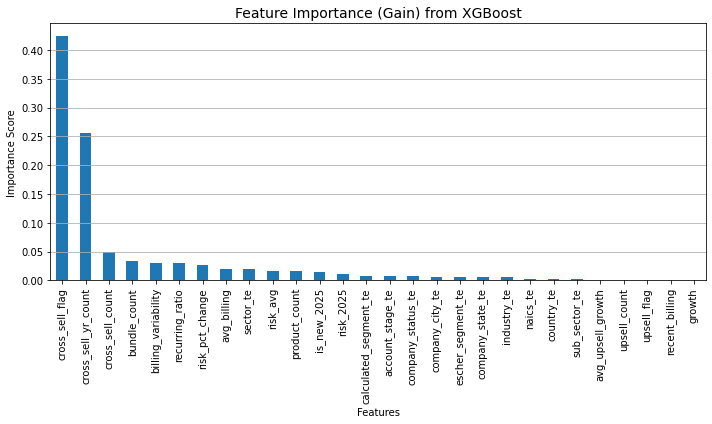

In [81]:
# Feature importance by 'gain'
importance = pd.Series(best_xgb.feature_importances_, index=X.columns)
importance = importance.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
importance.plot(kind='bar')
plt.title('Feature Importance (Gain) from XGBoost', fontsize=14)
plt.ylabel('Importance Score')
plt.xlabel('Features')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

These results validate the effectiveness of our engineered behavioral proxies in extracting latent signals from transactional and product usage data. Rather than relying solely on raw profile features, we were able to approximate engagement dynamics and retention tendencies, leading to a significantly more robust tenure prediction model.

The relatively small gap between training and validation R² also suggests low overfitting, implying strong generalizability of the learned patterns. In particular, the top predictors now align with business intuition, including expansion activity (`avg_upsell_growth`) and contract structure (`recurring_ratio`), making the model both accurate and explainable.

Future improvements can focus on:

- Enriching temporal patterns (e.g. billing trends or churn windows)
- Including more behavioral signals from product usage

#### SHAP Analysis

> SHAP scatter plot for `cross_sell_yr_count`, showing its contribution to predicted tenure.
> <br>Color indicates values of `avg_billing`, which appears to interact with this feature.

In [82]:
import shap

# Initialize SHAP explainer
explainer = shap.Explainer(best_xgb)

# Compute SHAP values for a subset of data (test set recommended)
shap_values = explainer(X_test)
# shap_values = explainer(X_train)

In [83]:
mean_shap = np.abs(shap_values.values).mean(axis=0)

shap_summary = pd.DataFrame({
    "feature": X_test.columns,
    "mean_abs_shap": mean_shap
}).sort_values("mean_abs_shap", ascending=False)

print(shap_summary)

                  feature  mean_abs_shap
26    billing_variability       0.402543
3         cross_sell_flag       0.355532
1             avg_billing       0.244093
4     cross_sell_yr_count       0.150462
27        recurring_ratio       0.133902
22        risk_pct_change       0.072206
10              sector_te       0.066308
25          product_count       0.065210
21               risk_avg       0.058815
24           bundle_count       0.048837
5        cross_sell_count       0.022276
9   calculated_segment_te       0.014967
11       account_stage_te       0.008313
17      escher_segment_te       0.005187
12      company_status_te       0.004154
20              risk_2025       0.004056
13        company_city_te       0.001211
23            is_new_2025       0.001097
14       company_state_te       0.000458
18          sub_sector_te       0.000072
15             country_te       0.000066
16               naics_te       0.000050
19            industry_te       0.000041
8       avg_upse

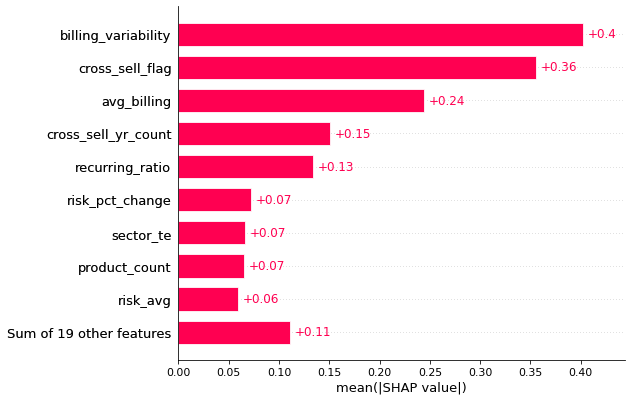

In [84]:
# Visual 1: Global feature importance (ranked by mean absolute SHAP value)
shap.plots.bar(shap_values)
plt.show()

The chart shows the **average SHAP values** of the top contributing features in the model. SHAP values measure how much each feature contributes to a prediction—higher values mean stronger influence.

- **`billing_variability`** is the most important feature, contributing an average of **+0.40** to the model's predictions. It indicates that fluctuations in billing are a strong signal for predicting client tenure.
- **`cross_sell_flag`** (avg +0.36) and **`avg_billing`** (avg +0.24) are also key drivers, suggesting that behavioral indicators like upsell activity and spending level carry more predictive power than static profile attributes.
- Profile features such as `sector_is`, `product_count`, and `risk_avg` show much lower contributions.


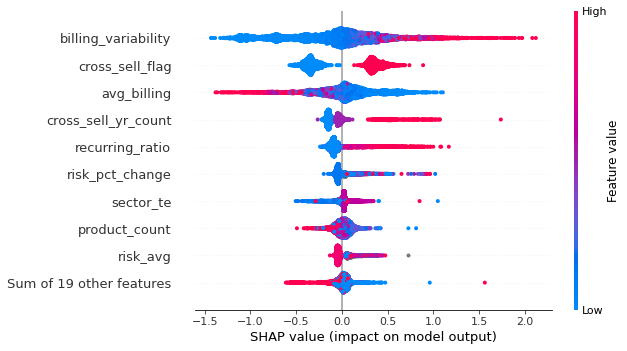

In [85]:
# Visual 2: SHAP Beeswarm Plot (shows distribution of feature impacts and value ranges)
shap.plots.beeswarm(shap_values)
plt.show()

The beeswarm plot shows how each feature affects individual predictions:

- **`billing_variability`**: Higher variability strongly increases predicted tenure. This suggests active, dynamic billing behavior is a positive retention signal.
- **`cross_sell_flag`**: Clients with cross-sell activity are predicted to stay longer—seen as a strong positive signal.
- **`avg_billing`**: Surprisingly, higher billing amounts are associated with lower predicted tenure, possibly indicating one-off high spenders with less long-term value.

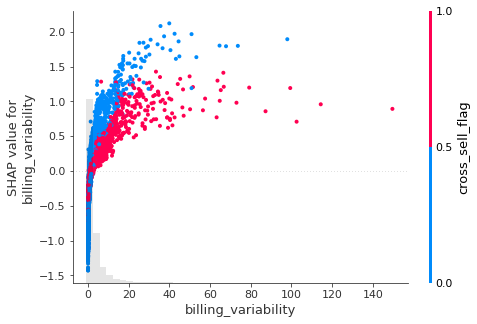

In [86]:
# Visual 3: Individual feature effect (using the most important feature)
top_feature = X_test.columns[np.abs(shap_values.values).mean(0).argmax()]
shap.plots.scatter(shap_values[:, top_feature], color=shap_values)

### LTV Calculation

In [87]:
df_r = df_r.merge(df[['company_id', 'calculated_segment']], on='company_id', how='left')

#### 🔍 Clarifying Retention Rate Discrepancy

Our model predicts per-customer retention rates for active clients, yielding an average around **60%**.

By contrast, Paylocity's annual report cites a **92% revenue retention rate**, which reflects:

- Aggregate revenue retained from all clients year-over-year
- Includes growth in upsell and expansion revenue from retained clients

This discrepancy is expected, as:

- LTV uses **per-client probability of churn**
- Disclosure reports **portfolio-level revenue dynamics**

The 92% in the disclosure reflects how much revenue Paylocity retained from last year's customers — including those who upgraded. Our model estimates individual clients’ likelihood to stay or not, so it's naturally lower.

LTV's focus on client-level retention supports individualized LTV modeling, while financial reports serve broader business health monitoring.

Average retetion rate: 67.36%


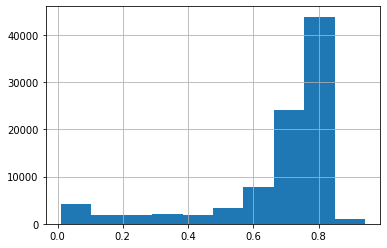

In [ ]:
# Predict tenure for active clients
active_mask = df_r['active'] == 1
df_r.loc[active_mask, 'lifespan_pred'] = best_xgb.predict(df_r.loc[active_mask, features])

# Ensure predicted tenure is not less than actual tenure
df_r['lifespan_pred'] = df_r['lifespan_pred'].clip(lower=df_r['tenure'])
### df_r['lifespan_pred'] = np.ceil(df_r['lifespan_pred'])

# Compute predicted retention rate from predicted tenure using the formula: r = 1 - 1 / t
# To ensure numerical stability and valid retention values (0 < r < 1),
# we clip the predicted tenure to a minimum of 1.01.
# This avoids division by values <1, which would wrongly result in r < 0 or r > 1.
df_r['r_pred'] = 1 - 1 / df_r['lifespan_pred'].clip(lower=1.01)

print(f"Average retetion rate: {df_r['r_pred'].mean():.2%}")

df_r['r_pred'].hist()
plt.show()

> As shown in the histogram (left-skewed distribution), individual-level retention rates mostly cluster around 70%. However, revenue retention can be higher — around 92% — because it is revenue-weighted, meaning larger clients with better retention disproportionately influence the overall metric.

In [89]:
df_r['LTV_R'] = df_r.apply(lambda row: compute_ltv(row['avg_billing'], g=g_0, r=row['r_pred'], i=i_0), axis=1)

In [90]:
table_r, segment_stats_r = summarize_ltv_metrics(df_r, 'LTV_R', cac_total=cac, cac_dict=cac_dict)
table_r

Average LTV_R: 51.94
LTV Multiplier (LTV_R): 3.64
LTV Multiplier @Recent (LTV_R): 3.21
--------------------------------------------------
Overall LTV/CAC: 8.60


,avg_ltv,ltv_cac,ltv_multiplier,ltv_multiplier_recent
calculated_segment,,,,
1-Growth,23.72,3.95,3.51,3.21
2-Major,140.00,27.94,3.76,3.23
3-Enterprise,494.55,34.63,3.74,3.24
Total,51.94,8.60,3.64,3.21


#### Truncated

In [91]:
_ = summarize_trunc_ltv(df_r, g=g_0, r='r_pred', i=i_0)


🔵 Cumulative LTV Summary (Full Horizon)
Average LTV (1yr): 9.89
LTV Multiplier (1yr): 0.69
LTV Multiplier @Recent (1yr): 0.61
--------------------------------------------------
Average LTV (5yr): 28.98
LTV Multiplier (5yr): 2.03
LTV Multiplier @Recent (5yr): 1.79
--------------------------------------------------
Average LTV (10yr): 35.50
LTV Multiplier (10yr): 2.48
LTV Multiplier @Recent (10yr): 2.19
--------------------------------------------------
Average LTV (full): 51.94
LTV Multiplier (full): 3.64
LTV Multiplier @Recent (full): 3.21
--------------------------------------------------

🟠 Incremental LTV Summary
Average LTV (1yr): 9.89
LTV Multiplier (1yr): 0.69
LTV Multiplier @Recent (1yr): 0.61
--------------------------------------------------
Average LTV (5yr_only): 19.09
LTV Multiplier (5yr_only): 1.34
LTV Multiplier @Recent (5yr_only): 1.18
--------------------------------------------------
Average LTV (10yr_only): 6.51
LTV Multiplier (10yr_only): 0.46
LTV Multiplier @Recent

### Visualization

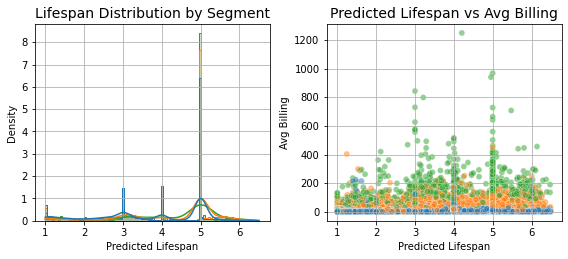

In [92]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3.7))
plt.subplots_adjust(hspace=0.3, wspace=0.3, right=0.83)

# --- Plot 1: Histogram ---
sns.histplot(
    data=df_r.query('active == 1').query('lifespan_pred <= 6.5'),
    x='lifespan_pred',
    hue='calculated_segment',
    bins=100,
    kde=True,
    element='step',
    stat='density',
    common_norm=False,
    ax=axs[0]
)
axs[0].set_title('Lifespan Distribution by Segment', fontsize=14)
axs[0].set_xlabel('Predicted Lifespan')
axs[0].set_ylabel('Density')
axs[0].grid(True)

# --- Plot 2: Scatter ---
plot2 = sns.scatterplot(
    data=df_r.query('lifespan_pred <= 6.5'),
    x='lifespan_pred',
    y='avg_billing',
    hue='calculated_segment',
    alpha=0.5,
    ax=axs[1]
)
axs[1].set_title('Predicted Lifespan vs Avg Billing', fontsize=14)
axs[1].set_xlabel('Predicted Lifespan')
axs[1].set_ylabel('Avg Billing')
axs[1].grid(True)

# --- Shared Legend ---
handles, labels = plot2.get_legend_handles_labels()
# fig.legend(handles, labels, title='Segment', loc='center left', bbox_to_anchor=(1.0, 0.92), fontsize=12, title_fontsize=12)

# Remove individual legends
for ax in axs.flat:
    ax.legend_.remove()

plt.tight_layout()
# plt.savefig("ltv_r_subplot.jpg", dpi=300, bbox_inches='tight')
plt.show()

In the presentation version of the model, the predicted tenure values were shown **directly as output from the model**, without any post-processing.

However, in this notebook version, we applied an important adjustment step to ensure the predictions are **realistically interpretable for retention use cases**:

- For any client where the predicted tenure was **less than their current (already observed) tenure**, we **adjusted the prediction upward** to at least match their existing tenure.
- We also applied a **ceiling function** to convert the tenure predictions into integer years, aligning with how retention periods are typically interpreted in practice.

As a result of this correction, the updated scatter plots may appear **less “scattered”** than the original model output, but they better reflect valid business constraints and yield **more actionable predictions**.

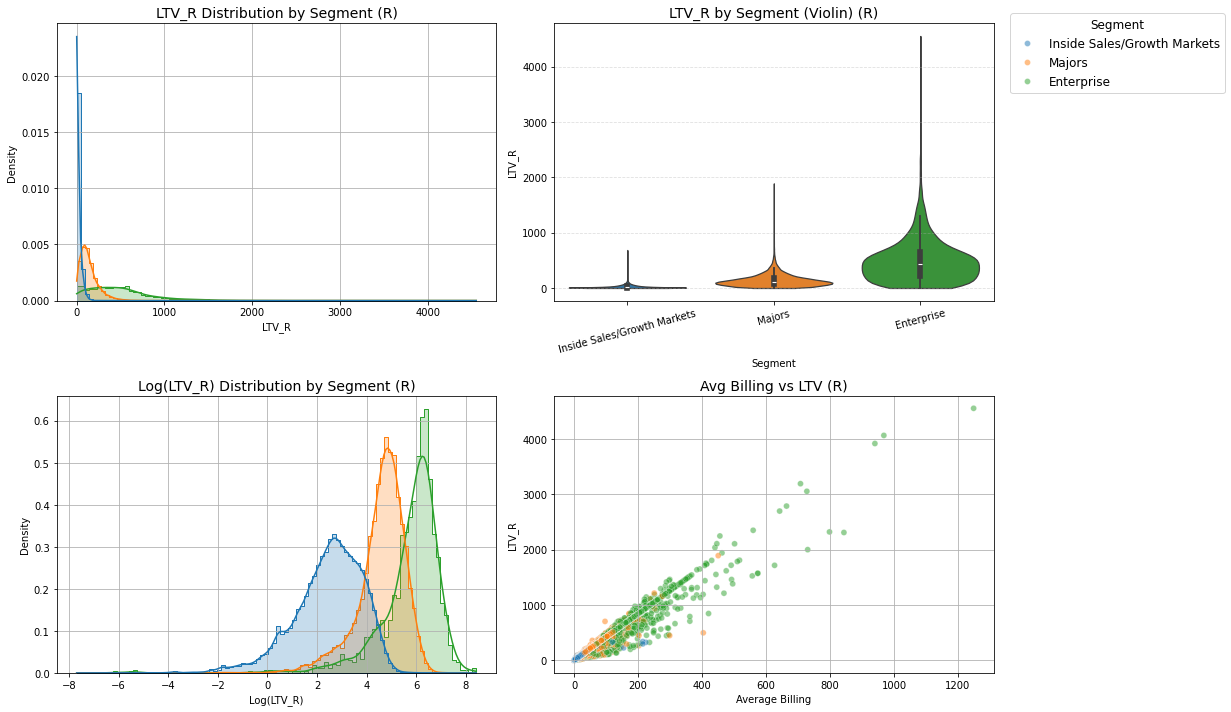

In [93]:
plot_ltv_analysis(df_r, ltv_col='LTV_R', title_suffix='(R)')

# **3. Clustering**

## Distribution Diagnostics for Log-Transformation

In [94]:
features = ['tenure', 'active', 'avg_billing', 'calculated_segment_te', 'sector_te',
            'recurring_ratio', 'billing_variability', 'bundle_count', 'product_count',
            'cross_sell_flag', 'cross_sell_yr_count', 'cross_sell_count',
            'upsell_flag', 'upsell_count', 'avg_upsell_growth',
            'risk_2025',              # primary snapshot
            # 'risk_pct_change',         # for trend signal
            'risk_avg'              # for long-term signal
]

df_cluster = df_r.reset_index()[['company_id'] + features]

In [95]:
df_cluster.isna().sum() / df_cluster.shape[0]

company_id               0.000000
tenure                   0.000000
active                   0.000000
avg_billing              0.000000
calculated_segment_te    0.000000
sector_te                0.000000
recurring_ratio          0.000000
billing_variability      0.000000
bundle_count             0.000000
product_count            0.000000
cross_sell_flag          0.000000
cross_sell_yr_count      0.000000
cross_sell_count         0.000000
upsell_flag              0.000000
upsell_count             0.000000
avg_upsell_growth        0.000000
risk_2025                0.376180
risk_avg                 0.375954
dtype: float64

In [96]:
# Fill 'risk_2025' (the most critical) with the median, but retain a dummy variable for missing values
# df_cluster['risk_2025_missing'] = df_cluster['risk_2025'].isna().astype(int)
df_cluster['risk_2025'] = df_cluster['risk_2025'].fillna(df_cluster['risk_2025'].median())

# 1. Treat NaN as "no health records at all" and fill with a sentinel value to indicate "not applicable"
# df_cluster['risk_avg'] = df_cluster['risk_avg'].fillna(-1)

# # Impute with median
df_cluster['risk_avg'] = df_cluster['risk_avg'].fillna(df_cluster['risk_avg'].median())

# 2. Use another sentinel value
# df_cluster['risk_pct_change'] = df_cluster['risk_pct_change'].fillna(-2)

# # Impute with median
# df_cluster['risk_pct_change'] = df_cluster['risk_pct_change'].fillna(df_cluster['risk_pct_change'].median())

In [97]:
from scipy.stats import skew, kurtosis

df_ = df_cluster[features]

# Calculate skewness and kurtosis
results = []
for col in df_.columns:
    sk = skew(df_[col])
    kt = kurtosis(df_[col])

    skew_label = (
        'Right Skewed' if sk > 1 else
        'Moderate Right' if 0.5 < sk <= 1 else
        'Symmetric' if -0.5 <= sk <= 0.5 else
        'Moderate Left' if -1 <= sk < -0.5 else
        'Left Skewed'
    )

    kurtosis_label = (
        'Heavy Tails' if kt > 3 else
        'Normal-ish' if 2 <= kt <= 3 else
        'Flat Tails'
    )

    if abs(sk) > 2 or kt > 4:
        transform_label = 'Strongly Recommend Transform'
    elif abs(sk) > 1 or kt > 3:
        transform_label = 'Consider Transform'
    else:
        transform_label = 'No Needed'

    results.append({
        'Feature': col,
        'Skew': round(sk, 3),
        'Skew Type': skew_label,
        'Kurtosis': round(kt, 3),
        'Kurtosis Type': kurtosis_label,
        'Needs Transformation': transform_label
    })

df_stats = pd.DataFrame(results)
df_stats

,Feature,Skew,Skew Type,Kurtosis,Kurtosis Type,Needs Transformation
0,tenure,0.016,Symmetric,-0.938,Flat Tails,No Needed
1,active,-1.128,Left Skewed,-0.729,Flat Tails,Consider Transform
2,avg_billing,10.920,Right Skewed,295.025,Heavy Tails,Strongly Recommend Transform
3,calculated_segment_te,-0.482,Symmetric,3.059,Heavy Tails,Consider Transform
4,sector_te,-0.477,Symmetric,-1.373,Flat Tails,No Needed
5,recurring_ratio,-0.312,Symmetric,-1.638,Flat Tails,No Needed
6,billing_variability,13.497,Right Skewed,431.038,Heavy Tails,Strongly Recommend Transform
7,bundle_count,-0.743,Moderate Left,-1.278,Flat Tails,No Needed
8,product_count,-0.091,Symmetric,-0.759,Flat Tails,No Needed
9,cross_sell_flag,-0.608,Moderate Left,-1.630,Flat Tails,No Needed


## K-Means++

### Find the optimal k

#### Scaling & Transformation

In [98]:
from sklearn.preprocessing import StandardScaler

df_ = df_cluster.copy()

# Step 1: Apply log1p transformation to highly skewed positive variables
log_vars = ['avg_billing', 'billing_variability', 'cross_sell_count', 'upsell_count', 'avg_upsell_growth']

for col in log_vars:
    if (df_[col] < 0).any():
        print(f"'{col}' contains negative values. Applying shift before log1p.")
        # If negative，shift before log1p
        shift = abs(df_[col].min()) + 1e-6
        df_[col] = np.log1p(df_[col] + shift)
    else:
        df_[col] = np.log1p(df_[col])

# Step 2: Standardize all features using StandardScaler
scaler = StandardScaler()
X = df_[features]
X_scaled = scaler.fit_transform(X)

# Step 3: Output with original column names and company_id as index
df_cluster_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=df_['company_id'])

'avg_upsell_growth' contains negative values. Applying shift before log1p.


#### Scoring

Running KMeans for k = 2...
Done for k = 2. Time taken: 3.01 seconds.

Running KMeans for k = 3...
Done for k = 3. Time taken: 2.47 seconds.

Running KMeans for k = 4...
Done for k = 4. Time taken: 2.50 seconds.

Running KMeans for k = 5...
Done for k = 5. Time taken: 2.75 seconds.

Running KMeans for k = 6...
Done for k = 6. Time taken: 3.05 seconds.

Running KMeans for k = 7...
Done for k = 7. Time taken: 3.56 seconds.

Running KMeans for k = 8...
Done for k = 8. Time taken: 3.40 seconds.

Running KMeans for k = 9...
Done for k = 9. Time taken: 4.69 seconds.

Running KMeans for k = 10...
Done for k = 10. Time taken: 6.10 seconds.

Running KMeans for k = 11...
Done for k = 11. Time taken: 9.23 seconds.



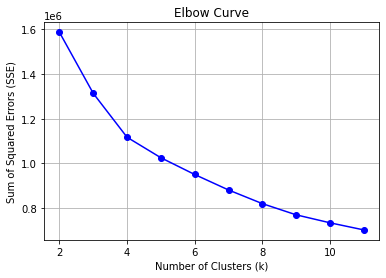

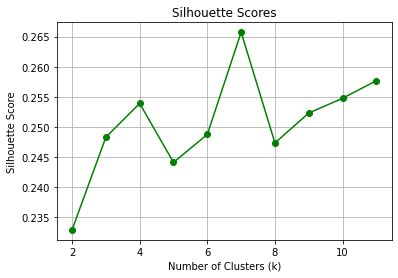

In [99]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.utils import resample

# Step 1: Prepare the input matrix
# X_scaled = X_scaled
# X_scaled = df_cluster_scaled.values

# Step 2: Initialize containers for scores
sse = []
silhouette_scores = []
k_values = range(2, 12)

# Step 3: Loop over different values of k
for k in k_values:
    print(f"Running KMeans for k = {k}...")
    start = time.time()

    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
    kmeans.fit(X_scaled)

    sse.append(kmeans.inertia_)

    # Subsample data for silhouette score calculation (e.g., 10,000 points)
        # Computing silhouette score on the full dataset (120,000+ points) is very slow,
        # as it involves pairwise distance calculations with O(n^2) complexity.
        # To speed up evaluation while maintaining representativeness, we use a random subset.
    X_sample, y_sample = resample(X_scaled, kmeans.labels_, n_samples=10000, random_state=42)
    sil_score = silhouette_score(X_sample, y_sample)
    silhouette_scores.append(sil_score)

    end = time.time()
    print(f"Done for k = {k}. Time taken: {end - start:.2f} seconds.\n")

# Step 4: Plot the Elbow Curve
plt.figure(figsize=(6,4))
plt.plot(k_values, sse, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.title('Elbow Curve')
plt.grid(True)
plt.show()

# Step 5: Plot the Silhouette Scores
plt.figure(figsize=(6,4))
plt.plot(k_values, silhouette_scores, 'go-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores')
plt.grid(True)
plt.show()

We validated that 7 clusters offered the best balance between **within-cluster compactness** and **between-cluster separation**, using both Elbow and Silhouette methods:

- **Elbow Curve** suggests diminishing returns beyond **k = 7-8**, indicating an optimal range where within-cluster variance stabilizes.
- **Silhouette Score** peaks at **k = 7**, implying the best balance of cohesion and separation.

For best clustering quality, we choose **k = 7**.

### Cluster Labeling

In [100]:
optimal_k = 7

# Step 1: Perform final clustering
kmeans_final = KMeans(n_clusters=optimal_k, init='k-means++', n_init=10, random_state=42)
kmeans_final.fit(X_scaled)

df_cluster = df_cluster.set_index('company_id')

# Step 2: Assign cluster labels to the dataset
df_cluster['cluster'] = kmeans_final.labels_

# Step 3: Reorder cluster labels based on average billing to produce stable cluster IDs.
    # This ensures consistent labeling across runs,
    # as KMeans cluster indices vary even with a fixed random_state.
cluster_profiles_raw = df_cluster.groupby('cluster').mean()
cluster_order = cluster_profiles_raw['avg_billing'].sort_values(ascending=False).index
cluster_mapping = {old: new for new, old in enumerate(cluster_order)}
df_cluster['cluster'] = df_cluster['cluster'].map(cluster_mapping)

In [101]:
# Step 4: Reassign to df_clustered and merge in headcount values
# df_clustered = df_cluster.copy()
df_clustered = df_cluster.merge(df[['company_id', 'headcount', 'growth']], how='left', on='company_id').set_index('company_id')

# Step 5: Summarize feature means by cluster
cluster_counts = df_clustered.groupby('cluster')['cluster'].count().div(1000).rename('count_k')
cluster_proportion = df_clustered['cluster'].value_counts(1).rename('proportion')
cluster_means = df_clustered.groupby('cluster')[['headcount', 'growth'] + features].mean().round(4)
cluster_profiles = pd.concat([cluster_counts,  cluster_proportion, cluster_means], axis=1)

cluster_profiles['size_m'] = cluster_profiles['headcount'] * cluster_profiles['count_k'] / 1000

In [102]:
# Step 6: Visualize the cluster profiles (sorted)

cluster_profiles = cluster_profiles.sort_index()
# cluster_profiles = cluster_profiles.sort_values('avg_billing', ascending=False)

ordered = ['count_k', 'proportion', 'headcount', 'size_m', 'risk_2025', 'risk_avg',
           'avg_billing', 'tenure', 'active', 'growth', 'recurring_ratio', 'product_count', 'bundle_count',
           'cross_sell_flag', 'cross_sell_yr_count', 'cross_sell_count',
           'upsell_flag', 'upsell_count', 'avg_upsell_growth', 'billing_variability',
          #  'calculated_segment_te', 'sector_te'
]
cluster_profiles = cluster_profiles[ordered]

cluster_profiles.T.style.format("{:.2f}").background_gradient(cmap='Blues', axis=1)
# cluster_profiles.style.background_gradient(cmap='Blues')

cluster,0,1,2,3,4,5,6
count_k,17.10,34.04,12.95,18.21,21.02,6.67,13.71
proportion,0.14,0.28,0.10,0.15,0.17,0.05,0.11
headcount,116.06,93.46,96.72,75.68,74.19,50.00,80.41
size_m,1.98,3.18,1.25,1.38,1.56,0.33,1.10
risk_2025,1.07,0.93,0.88,3.47,0.67,1.24,3.38
risk_avg,0.84,0.71,0.69,2.77,0.51,0.96,2.68
avg_billing,23.31,15.92,13.98,7.67,6.45,6.18,3.88
tenure,5.00,3.18,4.93,3.03,1.79,2.80,1.57
active,1.00,1.00,1.00,0.16,0.99,0.58,0.04
growth,0.20,-0.01,0.08,-0.03,-0.00,-0.00,-0.00


In [103]:
# Check if retention modeling result would roughly match the cluster mean
df_rr = df_r.merge(df_clustered.reset_index()[['company_id', 'cluster']], on='company_id', how='left')
df_rr.query('active == 1')\
     .groupby('cluster')[['lifespan_pred', 'r_pred']].mean().T\
     .style.format("{:.2f}").background_gradient(cmap='Blues', axis=1)

cluster,0,1,2,3,4,5,6
lifespan_pred,5.17,3.84,4.98,4.25,2.17,3.69,2.68
r_pred,0.81,0.72,0.80,0.75,0.41,0.65,0.51


In [104]:
df_cl = df_clustered.reset_index()\
                    .merge(df.reset_index()[['company_id', 'calculated_segment']], on='company_id', how='left')

calc_labels = {'Inside Sales/Growth Markets': '1-Growth',
               'Majors':                      '2-Major',
               'Enterprise':                  '3-Enterprise'}

df_cl['seg'] = df_cl['calculated_segment'].map(calc_labels)
df_cl.groupby(['seg', 'cluster'])[['headcount'] + features].mean().round(2)

headcount  tenure  active  avg_billing  \
seg          cluster                                           
1-Growth     0             50.0    5.00    1.00         9.16   
             1             50.0    3.17    1.00         7.68   
             2             50.0    4.93    1.00         7.32   
             3             50.0    2.99    0.15         4.78   
             4             50.0    1.84    0.99         4.04   
             5             50.0    4.62    0.98         2.76   
             6             50.0    1.55    0.04         2.51   
2-Major      0            250.0    5.00    1.00        45.21   
             1            250.0    3.19    1.00        39.21   
             2            250.0    4.97    1.00        34.71   
             3            250.0    3.35    0.23        24.27   
             4            250.0    1.42    0.99        21.54   
             6            250.0    1.67    0.07        11.02   
3-Enterprise 0            500.0    5.00    1.00       157.79   
             1            500.0    3.16    1.00       157.80   
             2            500.0    4.95    1.00        84.37   
             3            500.0    3.60    0.30        82.25   
             4            500.0    1.23    0.99        71.32   
             6            500.0    1.83    0.07        26.20   

                      calculated_segment_te  sector_te  recurring_ratio  \
seg          cluster                                                      
1-Growth     0                         3.11       3.87             0.81   
             1                         3.11       3.73             0.77   
             2                         3.11       3.90             0.00   
             3                         3.11       2.38             0.30   
             4                         3.11       2.59             0.67   
             5                         3.11       3.79             0.00   
             6                         3.11       2.29             0.12   
2-Major      0                         3.55       3.90             0.73   
             1                         3.55       3.73             0.81   
             2                         3.55       3.91             0.00   
             3                         3.55       2.35             0.21   
             4                         3.55       2.41             0.61   
             6                         3.55       2.29             0.07   
3-Enterprise 0                         3.56       3.92             0.66   
             1                         3.56       3.65             0.80   
             2                         3.56       3.93             0.00   
             3                         3.56       2.29             0.14   
             4                         3.56       2.23             0.49   
             6                         3.56       2.26             0.04   

                      billing_variability  bundle_count  product_count  \
seg          cluster                                                     
1-Growth     0                       2.46          1.99          17.07   
             1                       4.35          2.00          18.75   
             2                       1.55          1.01           9.48   
             3                       3.10          1.46          14.62   
             4                       1.91          2.00          14.30   
             5                       0.44          1.00           5.59   
             6                       1.41          1.29           9.13   
2-Major      0                      13.02          1.89          20.11   
             1                      22.71          1.99          21.65   
             2                       6.95          1.00          12.40   
             3                      16.32          1.32          15.14   
             4                      10.14          1.98          16.64   
             6                       6.69          1.18          

It's obvious that Cluster 5 only exists for the first calculated segment.

In [105]:
df_ = df_clustered.reset_index()\
                  .merge(df[['company_id', 'calculated_segment']], on='company_id', how='left')
df_['calculated_segment'].value_counts(dropna=False)

calculated_segment
Inside Sales/Growth Markets    97550
Majors                         18479
NaN                             5637
Enterprise                      2022
Name: count, dtype: int64

In [106]:
cond = df_['calculated_segment'].isna()

print(df_['cluster'][cond].value_counts())
print(df_['cluster'][cond].value_counts(1))

cluster
5    5621
2       7
0       5
6       3
1       1
Name: count, dtype: int64
cluster
5    0.997162
2    0.001242
0    0.000887
6    0.000532
1    0.000177
Name: proportion, dtype: float64


### Validating Feature Differences Across Clusters

#### ANOVA

In [107]:
from scipy.stats import f_oneway

# For each numeric feature, perform one-way ANOVA to test for significance
anova_results = []
features_ = features

for var in features_:
    groups = [df_clustered[df_clustered['cluster'] == c][var] for c in sorted(df_clustered['cluster'].unique())]
    f_val, p_val = f_oneway(*groups)
    anova_results.append({'feature': var, 'F_stat': f_val, 'p_value': p_val})

df_anova = pd.DataFrame(anova_results).sort_values('p_value')
print(df_anova)

                  feature         F_stat  p_value
0                  tenure   31117.195624      0.0
14      avg_upsell_growth    8448.837959      0.0
13           upsell_count   24867.812682      0.0
12            upsell_flag  111543.128073      0.0
11       cross_sell_count    9837.296681      0.0
10    cross_sell_yr_count   27446.534097      0.0
9         cross_sell_flag  152374.401568      0.0
15              risk_2025   56278.876084      0.0
8           product_count   14801.476402      0.0
6     billing_variability     926.951963      0.0
5         recurring_ratio   31231.156558      0.0
4               sector_te   23812.443315      0.0
3   calculated_segment_te   14988.207374      0.0
2             avg_billing    1327.145874      0.0
1                  active   77554.219117      0.0
7            bundle_count   43557.301613      0.0
16               risk_avg   63541.652863      0.0


#### Welch's ANOVA

> Welch's ANOVA is a more robust alternative to classical ANOVA. It does not assume equal variances across groups, which makes it especially useful when that assumption may be violated.
>> Using always Welch’s ANOVA gives added confidence in the statistical validity of the results.

In [108]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

anova_results = []

# For each numeric feature, run a Welch-style one-way ANOVA using robust standard errors

for var in features:
    # Create a temporary DataFrame for modeling
    df_temp = df_clustered[['cluster', var]].copy()
    df_temp['cluster'] = df_temp['cluster'].astype('category')  # Ensure 'cluster' is treated as categorical

    # Fit an OLS model and perform type-II ANOVA
    # with HC3 robust standard errors (Welch approximation)
    model = smf.ols(f'{var} ~ C(cluster)', data=df_temp).fit()
    anova_table = sm.stats.anova_lm(model, typ=2, robust='hc3')  # Welch ANOVA

    p_val = anova_table["PR(>F)"][0]
    f_val = anova_table["F"][0]

    anova_results.append({
        'feature': var,
        'F_stat (Welch)': round(f_val, 3),
        'p_value': round(p_val, 5),
        # 'Significant': 'V' if p_val < 0.05 else 'X'
    })

# Compile results
df_anova = pd.DataFrame(anova_results).sort_values('p_value')
print(df_anova)

                  feature  F_stat (Welch)  p_value
0                  tenure       88068.913      0.0
14      avg_upsell_growth        3143.569      0.0
13           upsell_count        7110.273      0.0
12            upsell_flag     8108719.156      0.0
11       cross_sell_count       20738.653      0.0
10    cross_sell_yr_count       60184.834      0.0
9         cross_sell_flag     1649253.085      0.0
15              risk_2025      168179.964      0.0
8           product_count       48296.865      0.0
6     billing_variability         950.316      0.0
5         recurring_ratio      173843.621      0.0
4               sector_te       37868.558      0.0
3   calculated_segment_te        7871.297      0.0
2             avg_billing        1579.749      0.0
1                  active       68136.469      0.0
7            bundle_count      390065.546      0.0
16               risk_avg      120686.691      0.0


All 13 clustering features show statistically significant differences across clusters (ANOVA, p < 0.001). This confirms that the segmentation structure captures meaningful variance across client behavior dimensions.

> We ran ANOVA across all features and found every variable differs significantly between clusters — statistically validating the segmentation.

## Cluster Analysis

#### 🟥 Cluster 0 – All-Around Flagship Clients

These clients are highly valuable: they stay long, spend a lot, and engage deeply across products. They represent the most loyal and strategically aligned customer base—ideal for retention programs, referrals, and success storytelling.

- High billing with both product depth and breadth
- Strong upsell and cross-sell activity
- Long tenure, fully active, growth-positive behavior

------

#### 🟧 Cluster 1 – Breadth-Driven Stable Clients

This group brings strong billing and product coverage but lacks upsell momentum. They’re stable and embedded, but under-monetized. Targeted nudging and premium upgrades may help unlock additional value.

- High billing and wide product use
- Minimal upsell, near-zero upsell_flag
- Ideal for passive nurturing or referral-trigger strategies

------

#### 🟨 Cluster 2 – Non-Recurring Loyal Clients

These clients have stuck around for years without adopting subscriptions. They pay for projects or one-offs, showing loyalty but limited monetization potential. Consider migrating them to recurring contracts.

- Long tenure but recurring ratio = 0
- Fully active, moderate billing
- Possible “hidden loyalty” users with project-based needs

------

#### 🟦 Cluster 5 – Silent Passive Clients

This is a quiet group—moderate tenure, limited product use, and barely any upgrade behavior. They’re not entirely disengaged, but show no signs of expansion. Low-cost maintenance is recommended.

- Active rate = 0.58, low product_count and billing
- Upsell/cross-sell behavior nearly zero
- Suitable for automated retention or no-touch monitoring

------

#### 🟩 Cluster 4 – Emerging Growth Clients

These are newly onboarded clients with strong engagement signals. While billing remains low, they’re exploring widely—making them ideal candidates for product education and early-stage upsell nudges.

- Very high active rate, broad product use
- New clients with upsell just beginning
- Should be prioritized for onboarding guidance and growth paths

------

#### 🟪 Cluster 3 – Shallow Users with High Risk

This group appears deceptively broad in usage but hides serious risk beneath. Active rate is near zero, engagement is thin, and churn scores are high. They are surface-level users at risk of silent departure.

- Active = 0.16, product_count = 14.7, but zero upsell
- Risk_2025 = 3.47 (among the highest)
- Should be flagged for risk-based outreach and behavioral validation

------

#### ⛔ Cluster 6 – Activation Drop-off Clients

These users failed to activate after product exposure. Though they touched many features, they disengaged quickly and now carry extreme churn scores. Best treated as exit-stage or churn sample group.

- Active rate = 0.04, near-total behavioral silence
- Highest churn risk with zero upsell/cross-sell behavior
- Strong fit for churn diagnostics, exit tracking, or “let go” strategy

## Cluster Summary

#### 🔍 Strategic Cluster Overview

> For the sake of presentation clarity, the 7 clusters generated by the KMeans algorithm have been manually grouped into 4 broader categories. This simplification helps to convey the overall customer segmentation narrative more effectively in reporting or high-level summaries.
>> However, for operational purposes—particularly when designing and implementing targeted marketing strategies—it is strongly recommended to use the original 7-cluster segmentation. The finer granularity captures more nuanced differences between customer groups, allowing for more precise and effective interventions.

| Category                     | Cluster | Strategic Recommendation                                     |
| ---------------------------- | ------- | ------------------------------------------------------------ |
| **High-Value Core Clients**  | **Prime** = C0 + C1 | Deep account management, referral programs, flagship development, showcase opportunities |
| **Stable Client Base**       | **Loyal** = C2 + C5 | Low-cost renewal support, light-touch engagement, ARPU maintenance |
| **Growth Potential & Retention Focus** | **Growing** = C4 + C3 | Onboarding optimization, educational nudges, risk watchlist and reactivation triggers |
| **High-Risk / Drop-off**     | **Disengaged** = C6      | Churn-prone onboarding failures, disengaged users, exit flow or diagnostic tracking |

<br>

##### 🏷 Cluster Tag Reference Table

| Cluster | Suggested Label               | Key Characteristics                                          |
| ------- | ----------------------------- | ------------------------------------------------------------ |
| C0      | All-Around Flagship Clients   | High billing, deep + broad usage, strong retention and upsell behavior |
| C1      | Breadth-Driven Stable Clients | High billing and wide product coverage, low upsell activity  |
| C2      | Non-Recurring Loyal Clients   | Long tenure, not on subscription, passive but loyal          |
| C3      | Shallow Users with High Risk  | Broad but superficial usage, low engagement, high churn risk |
| C4      | Emerging Growth Clients       | New and active, product-hungry, strong early-stage upsell potential |
| C5      | Silent Passive Clients        | Limited usage and growth signals, mid tenure, low-touch maintenance recommended |
| C6      | Activation Drop-off Clients   | Extremely low activity, high churn score, post-onboarding disengagement |




## Visualization

In [109]:
# After clustering, use scaled features for visualization,
# since unscaled data may hide meaningful differences due to varying feature scales.
df_clustered_scaled = df_cluster_scaled.reset_index()\
                        .merge(df_cluster.reset_index()[['company_id', 'cluster']], how='left', on='company_id')

cluster_profiles_scaled = df_clustered_scaled.groupby('cluster')[features].mean().round(2)

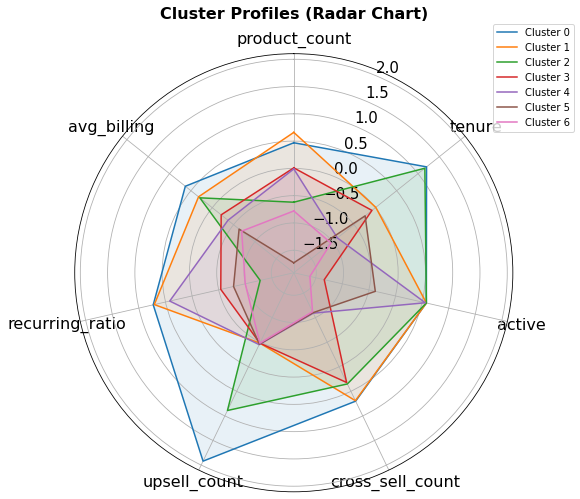

In [110]:
# Radar charts: useful for visualizing multi-dimensional data, especially for comparing cluster profiles.

# Select variables to plot (keep it manageable, ideally 6–10)
selected = ['product_count', 'tenure', 'active', 'cross_sell_count', 'upsell_count', 'recurring_ratio', 'avg_billing']
data = cluster_profiles_scaled

# Generate angles for the radar chart axes
N = len(selected)
angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
angles += angles[:1]  # close the loop

# Create a polar plot canvas
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Plot radar lines for each cluster
for cluster_id in sorted(data.index):
    values = data.loc[cluster_id, selected].tolist()
    values += values[:1]  # closed circle
    ax.plot(angles, values, label=f'Cluster {cluster_id}')
    ax.fill(angles, values, alpha=0.1)

# Add labels, grid, and legend
ax.tick_params(axis='y', labelsize=15)
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_thetagrids(np.degrees(angles[:-1]), selected, fontsize=16)
ax.set_title('Cluster Profiles (Radar Chart)', size=16, weight='bold', pad=35) # Set title with padding to avoid overlap with top label
ax.legend(loc='upper right', bbox_to_anchor=(1.15, 1.08))

plt.tight_layout()
plt.show()

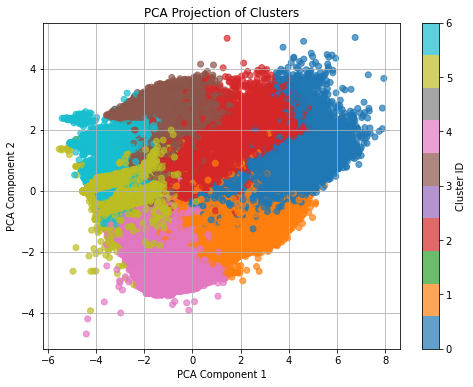

In [111]:
from sklearn.decomposition import PCA

# Select standardized clustering features (excluding cluster labels)
X = X_scaled
# X = df_cluster_scaled.values

# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    X_pca[:, 0], X_pca[:, 1],
    c=df_clustered['cluster'],
    cmap='tab10',
    alpha=0.7)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA Projection of Clusters')
plt.colorbar(scatter, label='Cluster ID')
plt.grid(True)
plt.show()

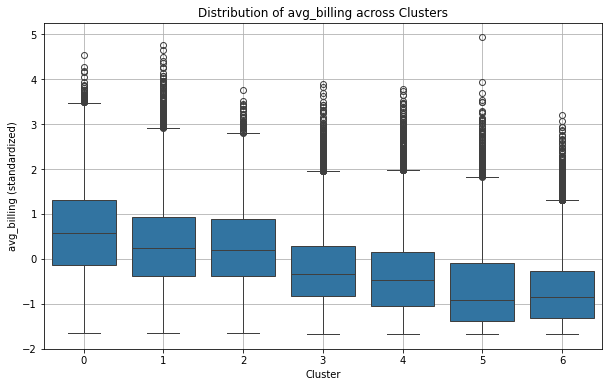

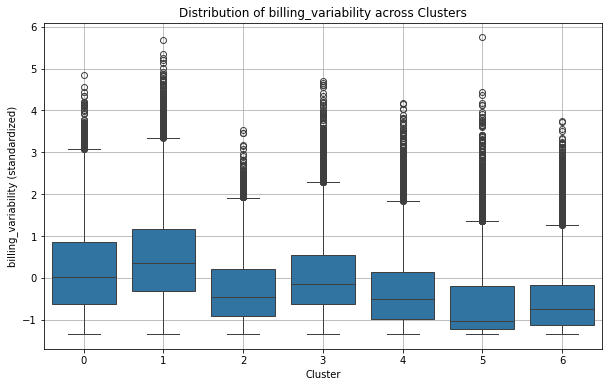

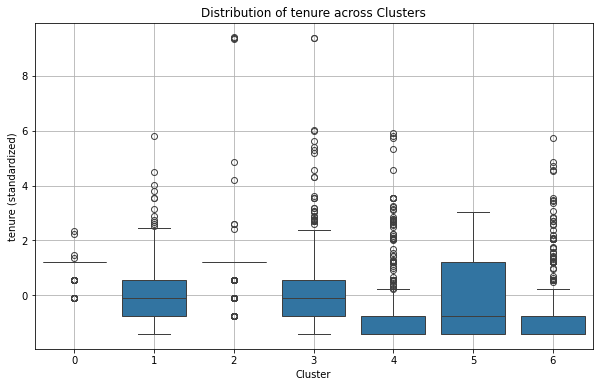

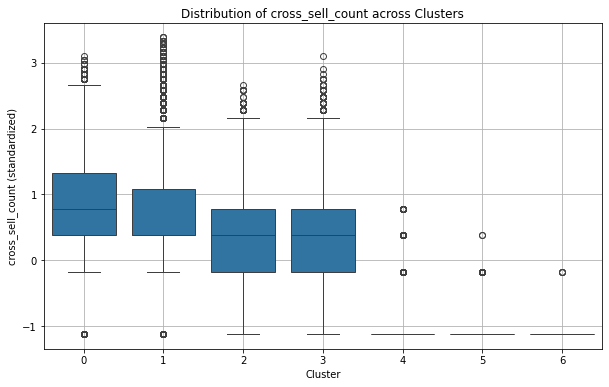

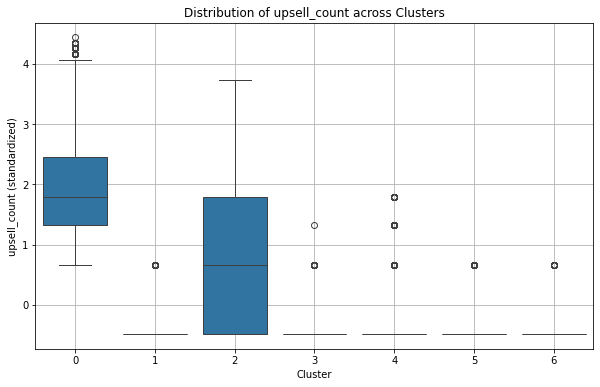

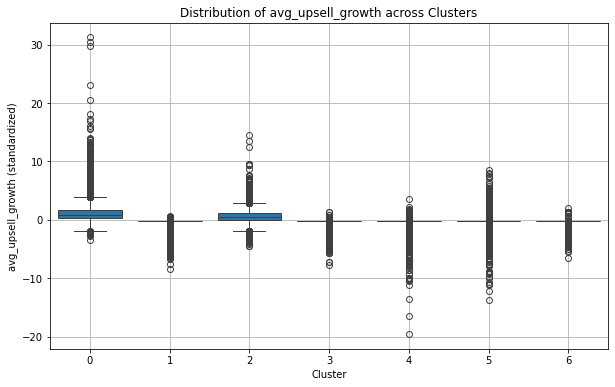

In [112]:
vars_to_plot = ['avg_billing', 'billing_variability', 'tenure',
                'cross_sell_count', 'upsell_count', 'avg_upsell_growth']

for var in vars_to_plot:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df_clustered_scaled, x='cluster', y=var)
    plt.title(f'Distribution of {var} across Clusters')
    plt.xlabel('Cluster')
    plt.ylabel(f'{var} (standardized)')
    plt.grid(True)
    plt.show()

## Tree-Based Interpretation of Clusters

> *For the sake of:
> <br>"surrogate modeling", "interpretable proxy model", or "tree-based explanation of clusters".*

To enhance the interpretability of the KMeans clustering results, we trained a basic decision tree model using the original customer features as inputs and the cluster labels as the target. While the tree is not intended to replace the clustering algorithm, it serves as an interpretable surrogate that helps us understand the key drivers behind each customer segment. By examining the decision rules (e.g., splits based on billing amount or product usage), stakeholders can more easily grasp the characteristics of each cluster and apply this knowledge in strategic planning or operational decision-making.

We chose a standard CART decision tree to model the cluster labels for interpretability purposes. Unlike ensemble methods such as Random Forests or XGBoost, a single decision tree provides a clear, human-readable structure that makes it easy to trace the decision paths leading to each cluster assignment. This simplicity is ideal for stakeholder communication, where transparency and explainability often outweigh marginal gains in predictive performance. By limiting the tree depth and controlling node sizes, we ensure the resulting rules are concise and aligned with practical business understanding.

To address interpretability, we grouped the 7 KMeans clusters into 4 strategic segments:

- High-Value Core Clients
- Stable Base Clients
- Growth & Retention Priority
- At-Risk / Drop-off Clients

To support explainability, we trained a shallow decision tree to mimic this grouping logic. The resulting tree offers simple rule-based paths to segment any client in a transparent manner.

In [113]:
cluster_to_group = {
    0: 'A',
    1: 'A',
    2: 'B',
    5: 'B',
    4: 'C',
    3: 'C',
    6: 'D'
}

df_clustered['strat_seg'] = df_clustered['cluster'].map(cluster_to_group)

features = ['tenure', 'active', 'avg_billing', 'headcount',
            'recurring_ratio', 'billing_variability', 'product_count',
            'cross_sell_count', 'upsell_count', 'risk_2025']

**Why `dtreeviz` Needs Extra Steps**

Compared to `plot_tree`, `dtreeviz` provides richer visuals with split logic, class distributions, and impurity metrics.

To support this, it requires:

- `X` with **no NaNs**
- `y` as **integer codes**
- `class_names` as a **list or dict**

These steps are only for `dtreeviz` visualization, not for training.

> Note: `dtreeviz` requires dropping or imputing missing values, which may result in a decision tree different from the original if the model was trained on raw data with NaNs.

In [114]:
from sklearn.tree import DecisionTreeClassifier

# Drop rows with NaNs in features (required for dtreeviz compatibility)
X = df_clustered[features].astype(float)
y = df_clustered['strat_seg'].astype('category')
X = X.join(y).dropna()[features]

# Encode target labels as integers
y_clean = y.loc[X.index]  # Align y with filtered X
y_codes = y_clean.cat.codes
class_names = dict(enumerate(y_clean.cat.categories)) # Map class indices to labels

# Fit decision tree on cleaned data
cart = DecisionTreeClassifier(max_depth=3, random_state=42)
cart.fit(X, y_codes)

DecisionTreeClassifier(max_depth=3, random_state=42)

In [115]:
from sklearn.tree import export_text

tree_rules = export_text(cart, feature_names=list(X.columns))
print(tree_rules)

|--- recurring_ratio <= 0.27
|   |--- tenure <= 4.91
|   |   |--- cross_sell_count <= 0.50
|   |   |   |--- class: 3
|   |   |--- cross_sell_count >  0.50
|   |   |   |--- class: 2
|   |--- tenure >  4.91
|   |   |--- risk_2025 <= 2.75
|   |   |   |--- class: 1
|   |   |--- risk_2025 >  2.75
|   |   |   |--- class: 2
|--- recurring_ratio >  0.27
|   |--- cross_sell_count <= 0.50
|   |   |--- active <= 0.50
|   |   |   |--- class: 3
|   |   |--- active >  0.50
|   |   |   |--- class: 2
|   |--- cross_sell_count >  0.50
|   |   |--- risk_2025 <= 3.49
|   |   |   |--- class: 0
|   |   |--- risk_2025 >  3.49
|   |   |   |--- class: 2



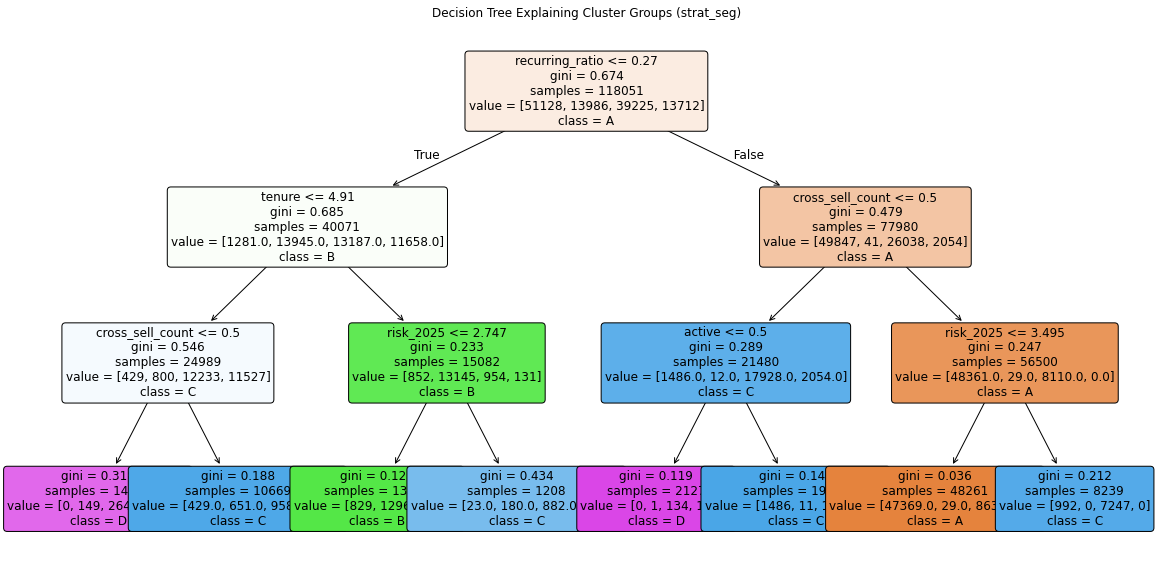

In [116]:
from sklearn.tree import plot_tree

# Visualize
plt.figure(figsize=(20, 10))  # Adjust based on depth
plot_tree(
    cart,
    feature_names=features,
    class_names=sorted(y.unique()),
    filled=True,
    rounded=True,
    fontsize=12,
    # label='root', # hide label
)
plt.title("Decision Tree Explaining Cluster Groups (strat_seg)")
plt.show()

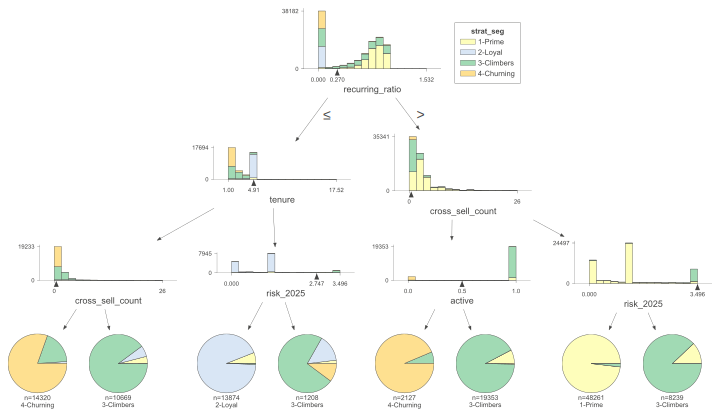

In [117]:
# %pip install -q dtreeviz
import dtreeviz

strategy_labels = {
    'A': '1-Prime', # high-value client
    'B': '2-Loyal', # steady partners
    'C': '3-Climbers', # potential; growing; at-risk
    'D': '4-Churning' # disengaged
}

class_names = {
    i: strategy_labels[label]
    for i, label in enumerate(y.cat.categories)
}

viz = dtreeviz.model(
    cart,
    X,
    y_codes,
    feature_names=features,
    target_name="strat_seg",
    class_names=class_names,
    # title="Decision Tree Explaining Cluster Segments"
)

viz.view(scale=1.0)
# viz.save("strat_tree.svg")

In [118]:
cluster_profiles['strat_seg'] = cluster_profiles.reset_index()['cluster'].map(cluster_to_group).map(strategy_labels)

strat_profiles = cluster_profiles[ordered + ['strat_seg']]
strat_profiles = strat_profiles.groupby('strat_seg').agg({
    'size_m': 'sum',
    'avg_billing': 'sum',
    **{col: 'mean' for col in ordered if col not in ['size_m', 'avg_billing']}
})

strat_profiles.T.style.format("{:.2f}").background_gradient(cmap='Blues', axis=1)

strat_seg,1-Prime,2-Loyal,3-Climbers,4-Churning
size_m,5.17,1.59,2.94,1.10
avg_billing,39.23,20.16,14.12,3.88
count_k,25.57,9.81,19.61,13.71
proportion,0.21,0.08,0.16,0.11
headcount,104.76,73.36,74.93,80.41
risk_2025,1.00,1.06,2.07,3.38
risk_avg,0.78,0.82,1.64,2.68
tenure,4.09,3.86,2.41,1.57
active,1.00,0.79,0.58,0.04
growth,0.10,0.04,-0.02,-0.00


In [119]:
strat_prof = strat_profiles.rename(columns={'size_m': 'market_size_mil'})
strat_prof = strat_prof[['market_size_mil', 'avg_billing', 'tenure', 'active', 'recurring_ratio', 'cross_sell_count', 'risk_avg']]
strat_prof.T.style.format("{:.2f}").background_gradient(cmap='Blues', axis=1)

strat_seg,1-Prime,2-Loyal,3-Climbers,4-Churning
market_size_mil,5.17,1.59,2.94,1.10
avg_billing,39.23,20.16,14.12,3.88
tenure,4.09,3.86,2.41,1.57
active,1.00,0.79,0.58,0.04
recurring_ratio,0.78,0.10,0.48,0.11
cross_sell_count,3.51,1.22,1.07,0.00
risk_avg,0.78,0.82,1.64,2.68


#### 🟥 Prime Clients 💎

**Flagship clients, nurture and showcase**

- Assign dedicated CS teams to maintain satisfaction
- Invite to advocacy/referral programs (e.g., testimonials, events)
- Use as case studies for future sales efforts

💬 *“These are your crown jewels — keep them happy, visible, and talking.”*

------

#### 🟨 Climbers 📈

**Upside potential, engage and grow**

- Build nurture journeys to support onboarding and early use
- Set up upsell triggers based on usage or product gaps
- Prioritize these accounts in lifecycle marketing efforts

💬 *“This group is where growth happens — with the right nudges, they’ll rise fast.”*

------

#### 🟩 Loyal Clients 🤝

**Low effort, long-lasting**

- Maintain light-touch check-ins to signal value
- Automate renewal nudges (e.g., ‘it's time to review!’)
- Focus on ARPU maintenance, not expansion

💬 *“Quiet but steady — loyalty pays off with minimal effort.”*

------

#### 🟦 Churning Clients 🧨

**High risk, diagnose or exit**

- Monitor disengagement signals (e.g., logins, usage drops)
- Trigger retention offers or diagnostic CS outreach
- If recovery is low-likelihood, design graceful exit options

💬 *“Not every client can be saved — but every signal can be used.”*

# **4. Growth Modeling**

- Derived from **cluster-level historical billing CAGR**
- Clusters with negative growth fallback to **baseline (g₀ = 4.4%)**
- All values **validated for LTV formula convergence**
- Improves transparency compared to complex heuristic rules

In addition to assigning cluster-level growth rates, we layered in a saturation adjustment:

- For clusters 2 and 4 (growth-eligible groups), clients whose product coverage falls below the top quartile receive a small upward adjustment to their g value.
- This reflects latent growth potential that has not yet been realized.
- No adjustments are applied to high-risk clusters.

### Growth Rate Assignment Strategy (`g_ltv`)

We estimate client-level growth (`g_ltv`) by blending baseline assumptions with cluster-specific behavior and product adoption patterns.

#### Step 1 – Baseline
- All clients default to a conservative growth baseline: **U.S. inflation rate (g₀ = 4.4%)**

#### Step 2 – Cluster-based upward adjustments

**Cluster 2 – Partially saturated clients**
- Clients with product coverage below the 75th percentile are assigned the cluster's **mean historical CAGR (~8%)**
- Rationale: Non-recurring cluster with some room for horizontal expansion.

**Cluster 0 – High billers with growth headroom**
- Clients below the cluster's 75th percentile product coverage receive **cluster mean CAGR (~20%)**
- Rationale: High-value group, but only those who haven't saturated receive an uplift.
<!-- - Clients below the cluster's 75th percentile product coverage receive **cluster median CAGR (~20%)**
- Rationale: High-value group with upward room, but growth distribution is skewed; median better reflects typical client trajectory. -->

**Cluster 4 – New, engaged clients**
- Clients in Cluster 4 (short tenure, high activity, low coverage) are **mapped analogically** to Cluster 0.
- These clients are assigned the **25th percentile CAGR from Cluster 0 (~conservative growth)**

#### Why this matters:
- Encourages realistic growth expectations tied to adoption behavior
- Avoids over-inflating mature or low-engagement clusters
- Aligns modeling logic with business trajectory expectations


In [120]:
df_clustered['prod_coverage'] = df_clustered['product_count'] / df_clustered['product_count'].max()

df_clustered.groupby('cluster')[['growth', 'prod_coverage']].agg(['min',
                                                                  ('q1', lambda x: x.quantile(0.25)),
                                                                  'median', 'mean',
                                                                  ('q3', lambda x: x.quantile(0.75)),
                                                                  'max'])

growth                                                    \
              min        q1    median      mean        q3       max   
cluster                                                               
0       -0.686513  0.067723  0.137574  0.199524  0.261623  3.598097   
1       -0.915344  0.000000  0.000000 -0.007554  0.000000  1.316816   
2       -0.768348  0.029336  0.075590  0.084879  0.129523  1.616756   
3       -0.924278  0.000000  0.000000 -0.034732  0.000000  1.783158   
4       -0.816494  0.000000  0.000000 -0.001724  0.000000  0.629884   
5       -0.931923  0.000000  0.000000 -0.004340  0.000000  0.991011   
6       -0.677798  0.000000  0.000000 -0.004700  0.000000  0.424877   

        prod_coverage                                                    
                  min        q1    median      mean        q3       max  
cluster                                                                  
0            0.027778  0.416667  0.500000  0.499591  0.583333  1.000000  
1            0.055556  0.444444  0.527778  0.537236  0.638889  1.000000  
2            0.027778  0.222222  0.277778  0.280236  0.333333  0.750000  
3            0.055556  0.277778  0.416667  0.407709  0.527778  0.888889  
4            0.000000  0.250000  0.416667  0.404013  0.555556  0.972222  
5            0.000000  0.027778  0.055556  0.058052  0.055556  0.333333  
6            0.000000  0.111111  0.222222  0.249238  0.388889  0.833333

In [121]:
# Step 1: Start from baseline growth = inflation
df_clustered['g_ltv'] = g_0  # fallback growth rate (U.S. inflation)

# ----------------------

# Step 2a: Cluster 2 - Upshift if unsaturated
# Define Q3 product coverage threshold for Cluster 2
cover_q3_c2 = df_clustered[df_clustered['cluster'] == 2]['prod_coverage'].quantile(0.75)
# Use average historical CAGR for Cluster 2
cagr_mean_c2 = df_clustered[df_clustered['cluster'] == 2]['growth'].mean()

# For Cluster 2 clients with low product coverage, assign historical cluster-level growth
df_clustered.loc[
    (df_clustered['cluster'] == 2) & (df_clustered['prod_coverage'] < cover_q3_c2),
    'g_ltv'
] = cagr_mean_c2

# ----------------------

# Step 2b: Cluster 0 - Adjust up only for those with room to grow
cover_q3_c0 = df_clustered[df_clustered['cluster'] == 0]['prod_coverage'].quantile(0.75)
cagr_mean_c0 = df_clustered[df_clustered['cluster'] == 0]['growth'].mean()

df_clustered.loc[
    (df_clustered['cluster'] == 0) & (df_clustered['prod_coverage'] < cover_q3_c0),
    'g_ltv'
] = cagr_mean_c0

# ----------------------

# Step 2c: Cluster 4 - Estimate growth by analogy to Cluster 0 (conservative)
# Clients in Cluster 4 are active but new; assign Q1 of C0 growth if under-covered
cagr_q1_c0 = df_clustered[df_clustered['cluster'] == 0]['growth'].quantile(0.25)
cover_q3_c4 = df_clustered[df_clustered['cluster'] == 4]['prod_coverage'].quantile(0.75)

cond_c4 = (
    (df_clustered['cluster'] == 4) &
    (df_clustered['prod_coverage'] < cover_q3_c4)
)

df_clustered.loc[cond_c4, 'g_ltv'] = cagr_q1_c0

# ----------------------

df_clustered.groupby('cluster')[['g_ltv']].mean()

,g_ltv
cluster,
0,0.150459
1,0.044400
2,0.072471
3,0.044400
4,0.061409
5,0.044400
6,0.044400


In [122]:
df_clustered.reset_index().merge(df[['company_id', 'calculated_segment']])\
    .groupby('calculated_segment')[['g_ltv']].mean().sort_values(by='g_ltv', ascending=False)

,g_ltv
calculated_segment,
Majors,0.067496
Inside Sales/Growth Markets,0.065565
Enterprise,0.065097


For Cluster 4 clients—new but highly active—we estimate growth not based on historical billing, but rather by analogy.

These clients are assumed to follow a similar trajectory as Cluster 0 (flagship clients), so we assign them a growth rate equal to the 25th percentile of Cluster 0's observed CAGR.

This conservative estimate reflects both their potential and their short-term uncertainty.

### Calculation

In [123]:
df_g = df_clustered.merge(df[['company_id', 'recent_billing', 'calculated_segment']], left_index=True, right_on='company_id', how='left').copy()

# Model G: Use g_ltv
df_g['LTV_G'] = df_g.apply(lambda row: compute_ltv(row['avg_billing'], g=row['g_ltv'], r=r_0, i=i_0), axis=1)

In [124]:
table_g, segment_stats_g = summarize_ltv_metrics(df_g, 'LTV_G', cac, cac_dict)
table_g

Average LTV_G: 165.84
LTV Multiplier (LTV_G): 11.61
LTV Multiplier @Recent (LTV_G): 10.25
--------------------------------------------------
Overall LTV/CAC: 27.46


,avg_ltv,ltv_cac,ltv_multiplier,ltv_multiplier_recent
calculated_segment,,,,
1-Growth,81.63,13.60,12.08,11.05
2-Major,435.56,86.94,11.70,10.05
3-Enterprise,1457.22,102.05,11.03,9.56
Total,165.84,27.46,11.61,10.25


#### Truncated

In [125]:
_ = summarize_trunc_ltv(df_g, g='g_ltv', r=r_0, i=i_0)


🔵 Cumulative LTV Summary (Full Horizon)
Average LTV (1yr): 12.43
LTV Multiplier (1yr): 0.87
LTV Multiplier @Recent (1yr): 0.77
--------------------------------------------------
Average LTV (5yr): 48.36
LTV Multiplier (5yr): 3.39
LTV Multiplier @Recent (5yr): 2.99
--------------------------------------------------
Average LTV (10yr): 74.22
LTV Multiplier (10yr): 5.20
LTV Multiplier @Recent (10yr): 4.59
--------------------------------------------------
Average LTV (full): 165.84
LTV Multiplier (full): 11.61
LTV Multiplier @Recent (full): 10.25
--------------------------------------------------

🟠 Incremental LTV Summary
Average LTV (1yr): 12.43
LTV Multiplier (1yr): 0.87
LTV Multiplier @Recent (1yr): 0.77
--------------------------------------------------
Average LTV (5yr_only): 35.93
LTV Multiplier (5yr_only): 2.52
LTV Multiplier @Recent (5yr_only): 2.22
--------------------------------------------------
Average LTV (10yr_only): 25.86
LTV Multiplier (10yr_only): 1.81
LTV Multiplier @

#### Note on Interpreting Growth Rate

In [126]:
print(f"Average scaled growth rate: {df_g['g_ltv'].mean():.2%}")

Average scaled growth rate: 6.49%


While our modeled `g` is adjusted based on upsell and cross-sell behavior, its average remains below the **industry's expected 5-year revenue growth rate (13.19%)**.

This is expected — and appropriate — because:

- Our LTV framework estimates **customer-level lifetime value**, not company-wide revenue growth.
- Industry growth includes **new customer acquisition**, while LTV focuses solely on **monetizing existing customers**.
- Therefore, our g (≈ 4–10%) reflects **per-client monetization potential**, not full-scale business expansion.

This distinction helps explain why even our highest adjusted `g` values remain below the long-term industry CAGR.

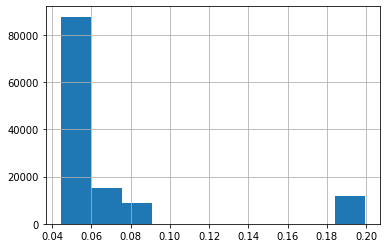

In [127]:
df_g['g_ltv'].hist()
plt.show()

#### Visualization

## LTV R+G

In [128]:
df_rg = pd.merge(df_g[['company_id', 'g_ltv', 'avg_billing', 'active']],
                 df_r.reset_index()[['company_id', 'r_pred']], on='company_id', how='left')
df_rg = df_rg.merge(df[['company_id', 'sector', 'calculated_segment', 'recent_billing']], on='company_id', how='left')

# LTV R+G: Use g_ltv + r_pred
df_rg['LTV_RG'] = df_rg.apply(lambda row: compute_ltv(row['avg_billing'], g=row['g_ltv'], r=row['r_pred'], i=i_0), axis=1)

In [129]:
table_rg, segment_stats_rg = summarize_ltv_metrics(df_rg, 'LTV_RG', cac_total=cac, cac_dict=cac_dict)
table_rg

Average LTV_RG: 60.78
LTV Multiplier (LTV_RG): 4.26
LTV Multiplier @Recent (LTV_RG): 3.76
--------------------------------------------------
Overall LTV/CAC: 10.06


,avg_ltv,ltv_cac,ltv_multiplier,ltv_multiplier_recent
calculated_segment,,,,
1-Growth,28.46,4.74,4.21,3.85
2-Major,163.27,32.59,4.39,3.77
3-Enterprise,561.84,39.34,4.25,3.69
Total,60.78,10.06,4.26,3.76


#### Truncated

In [130]:
trc_rg = summarize_trunc_ltv(df_rg, g='g_ltv', r='r_pred', i=i_0)


🔵 Cumulative LTV Summary (Full Horizon)
Average LTV (1yr): 10.15
LTV Multiplier (1yr): 0.71
LTV Multiplier @Recent (1yr): 0.63
--------------------------------------------------
Average LTV (5yr): 31.30
LTV Multiplier (5yr): 2.19
LTV Multiplier @Recent (5yr): 1.93
--------------------------------------------------
Average LTV (10yr): 40.37
LTV Multiplier (10yr): 2.83
LTV Multiplier @Recent (10yr): 2.49
--------------------------------------------------
Average LTV (full): 60.78
LTV Multiplier (full): 4.26
LTV Multiplier @Recent (full): 3.76
--------------------------------------------------

🟠 Incremental LTV Summary
Average LTV (1yr): 10.15
LTV Multiplier (1yr): 0.71
LTV Multiplier @Recent (1yr): 0.63
--------------------------------------------------
Average LTV (5yr_only): 21.15
LTV Multiplier (5yr_only): 1.48
LTV Multiplier @Recent (5yr_only): 1.31
--------------------------------------------------
Average LTV (10yr_only): 9.07
LTV Multiplier (10yr_only): 0.64
LTV Multiplier @Rece

#### Model Comparison

Model R+G got pretty close to what we had from Model R.

Does this mean $g$ actually is less of a driver for LTV?

Not necessarily. Although the results from LTV R+G and Model R are very close, the limited impact of $g$ may stem from how it enters the LTV formula:

$$LTV = m \cdot \frac{1 + i}{1 + i - r(1 + g)}$$

In this expression, $g$ is nested within the term $r(1 + g)$ in the denominator. As a result, its effect is **dampened unless $r$ is very large or fixed**. When $r$ varies significantly (as it does in our learned `r_pred`), changes in $g$ have a comparatively minor effect on the final LTV value. This interaction explains why LTV R+G and Model R yield nearly identical results—because LTV is more sensitive to retention than to growth, especially under moderate $r$ values.

| Model                   | Growth (g)               | Retention (r)                | Avg LTV | Multiplier | LTV/CAC |
| ----------------------- | --------------- | ---------------- | ------- | ---------- |---------- |
| **v0**       | inflation (4.4%) | baseline (89%)   | 94.93   | 6.65       | 15.72 |
| **G**      | Scaled g       | baseline (89%)   | 165.84   | 11.61       | 27.46 |
| **R**          | inflation (4.4%) | r_pred (XGBoost) | 53.79   | 3.77       | 8.91 |
| **R+G**           | Scaled g       | r_pred (XGBoost) | 63.36   | 4.44       | 10.49 |

In [131]:
avg_ltv_comparison = pd.concat([
    segment_stats['avg_ltv'],
    segment_stats_g['avg_ltv'],
    segment_stats_r['avg_ltv'],
    segment_stats_rg['avg_ltv']
], axis=1)

avg_ltv_comparison.columns = ['LTV_v0', 'LTV_G', 'LTV_R', 'LTV_RG']
avg_ltv_comparison.round(2).sort_index()

,LTV_v0,LTV_G,LTV_R,LTV_RG
calculated_segment,,,,
1-Growth,44.91,81.63,23.72,28.46
2-Major,247.42,435.56,140.00,163.27
3-Enterprise,878.05,1457.22,494.55,561.84
Total,94.93,165.84,51.94,60.78


In [132]:
avg_ltv_comparison = pd.concat([
    segment_stats['ltv_multiplier'],
    segment_stats_r['ltv_multiplier'],
    segment_stats_g['ltv_multiplier'],
    segment_stats_rg['ltv_multiplier']
], axis=1)

avg_ltv_comparison.columns = ['LTV_Mult_v0', 'LTV_Mult_G', 'LTV_Mult_R', 'LTV_Mult_RG']
avg_ltv_comparison.round(2).sort_index()

,LTV_Mult_v0,LTV_Mult_G,LTV_Mult_R,LTV_Mult_RG
calculated_segment,,,,
1-Growth,6.65,3.51,12.08,4.21
2-Major,6.65,3.76,11.70,4.39
3-Enterprise,6.65,3.74,11.03,4.25
Total,6.65,3.64,11.61,4.26


In [133]:
avg_ltv_comparison = pd.concat([
    segment_stats['ltv_multiplier_recent'],
    segment_stats_r['ltv_multiplier_recent'],
    segment_stats_g['ltv_multiplier_recent'],
    segment_stats_rg['ltv_multiplier_recent']
], axis=1)

avg_ltv_comparison.columns = ['LTV_MultRec_v0', 'LTV_MultRec_R', 'LTV_MultRec_G', 'LTV_MultRec_RG']
avg_ltv_comparison.round(2).sort_index()

,LTV_MultRec_v0,LTV_MultRec_R,LTV_MultRec_G,LTV_MultRec_RG
calculated_segment,,,,
1-Growth,6.08,3.21,11.05,3.85
2-Major,5.71,3.23,10.05,3.77
3-Enterprise,5.76,3.24,9.56,3.69
Total,5.87,3.21,10.25,3.76


#### Visualization

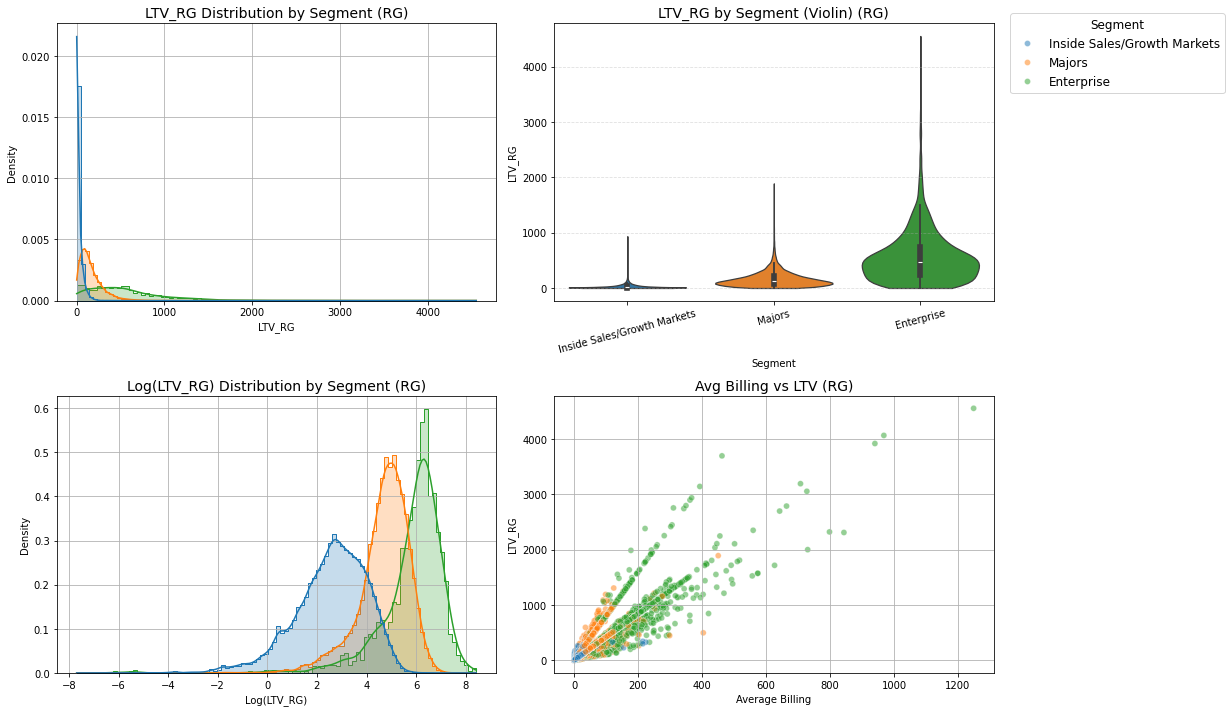

In [134]:
plot_ltv_analysis(df_rg, ltv_col='LTV_RG', title_suffix='(RG)')

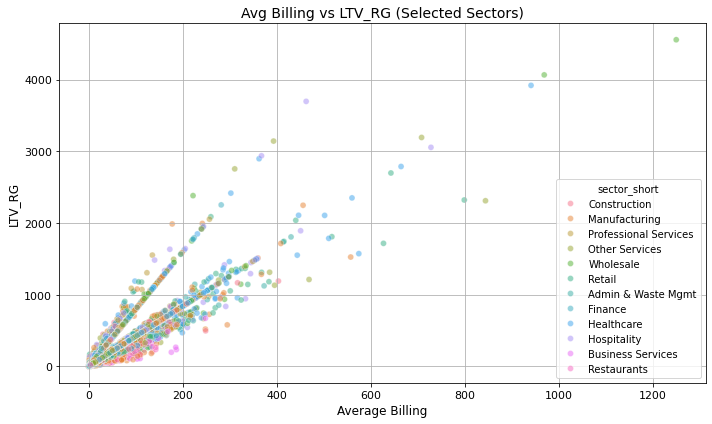

In [135]:
sector_short_names = {
    'Health Care and Social Assistance': 'Healthcare',
    'Professional, Scientific, and Technical Services': 'Professional Services',
    'Manufacturing': 'Manufacturing',
    'Other Services (except Public Administration)': 'Other Services',
    'Retail Trade': 'Retail',
    'Construction': 'Construction',
    'Accommodation and Food Services': 'Hospitality',
    'Administrative and Support and Waste Management and Remediation Services': 'Admin & Waste Mgmt',
    'Wholesale Trade': 'Wholesale',
    'Finance and Insurance': 'Finance',
    'Restaurant/Bar': 'Restaurants',
    'Business Services': 'Business Services'}

# filter to representative sectors
representative_sectors = list(sector_short_names.keys())
df_subset = df_rg[df_rg['sector'].isin(representative_sectors)].copy()

# rename sectors for clarity
df_subset['sector_short'] = df_subset['sector'].map(sector_short_names)

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_subset,
    x='avg_billing',
    y='LTV_RG',
    hue='sector_short',
    alpha=0.5
)

plt.title('Avg Billing vs LTV_RG (Selected Sectors)', fontsize=14)
plt.xlabel('Average Billing', fontsize=12)
plt.ylabel('LTV_RG', fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.grid(True)
plt.tight_layout()
plt.show()

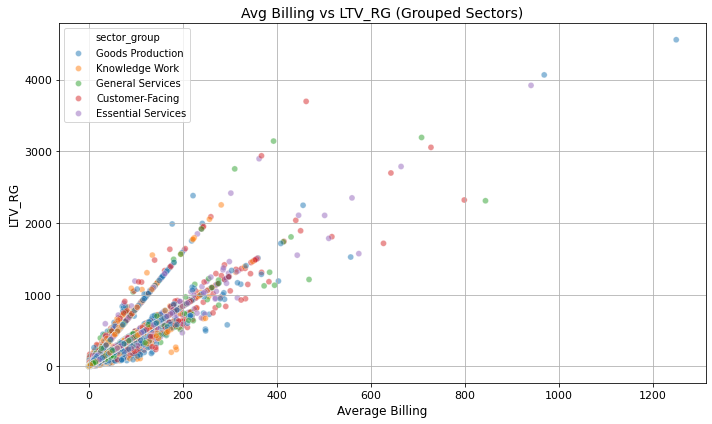

In [136]:
# One-to-many mapping of sectors to sector groups
sector_group_map = {
    'Healthcare': 'Essential Services',
    'Professional Services': 'Knowledge Work',
    'Finance': 'Knowledge Work',
    'Business Services': 'Knowledge Work',

    'Manufacturing': 'Goods Production',
    'Construction': 'Goods Production',
    'Wholesale': 'Goods Production',

    'Retail': 'Customer-Facing',
    'Hospitality': 'Customer-Facing',
    'Restaurants': 'Customer-Facing',

    'Other Services': 'General Services',
    'Admin & Waste Mgmt': 'General Services'
}

# Apply the mapping
df_subset['sector_group'] = df_subset['sector_short'].map(sector_group_map)

# Plot with sector groups
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_subset,
    x='avg_billing',
    y='LTV_RG',
    hue='sector_group',
    alpha=0.5
)

plt.title('Avg Billing vs LTV_RG (Grouped Sectors)', fontsize=14)
plt.xlabel('Average Billing', fontsize=12)
plt.ylabel('LTV_RG', fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.grid(True)
plt.tight_layout()
plt.show()

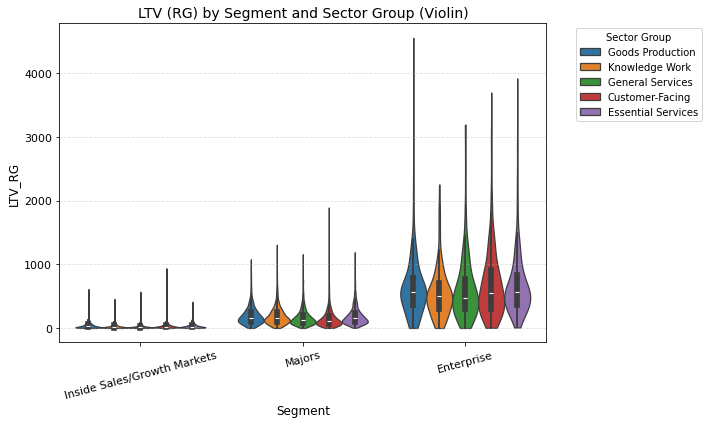

In [137]:
df_violin = df_rg[df_rg['sector'].isin(sector_short_names)].copy()
df_violin['sector_short'] = df_violin['sector'].map(sector_short_names)
df_violin['sector_group'] = df_violin['sector_short'].map(sector_group_map)

# Viloin plot with sector groups
plt.figure(figsize=(10, 6))
sns.violinplot(
    data=df_violin.query('active == 1'),
    x='calculated_segment',
    y='LTV_RG',
    hue='sector_group',
    scale='width',
    inner='box',
    cut=0,
    dodge=True  # to separate violins by hue
)

plt.title('LTV (RG) by Segment and Sector Group (Violin)', fontsize=14)
plt.xlabel('Segment', fontsize=12)
plt.ylabel('LTV_RG', fontsize=12)
plt.xticks(rotation=15, fontsize=11)
plt.yticks(fontsize=11)
plt.grid(True, axis='y', linestyle='--', alpha=0.4)
plt.legend(title='Sector Group', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# **5. Time-Series Forecasting**

## Yearly

In [138]:
bill_col = ['FY21_Billing', 'FY22_Billing', 'FY23_Billing', 'FY24_Billing', 'twelvemonth_billing']
df_year = df_agg[['company_id']+bill_col].rename(columns={'twelvemonth_billing': 'FY25_Billing'})
df_year = df_year.merge(df_profile_full[['company_id', 'company_city', 'company_state',
                             'industry', 'sector', 'calculated_segment']],
                    on='company_id', how='left')
df_year.head()

,company_id,FY21_Billing,FY22_Billing,FY23_Billing,FY24_Billing,FY25_Billing,company_city,company_state,industry,sector,calculated_segment
0,0102,2.0072,2.9380,3.0486,2.8714,2.9039,Morton Grove,IL,Utility System Construction,Construction,Inside Sales/Growth Markets
1,0103,1.0268,0.3750,0.0000,0.0000,0.0000,NaN,NaN,NaN,Construction,Inside Sales/Growth Markets
2,0104,0.7764,0.7088,0.2826,0.7859,0.4840,NaN,NaN,NaN,Construction,Inside Sales/Growth Markets
3,0129,7.4546,8.4972,9.5995,10.0910,9.6389,Norridge,IL,Office Furniture (including Fixtures) Manufact...,Manufacturing,Inside Sales/Growth Markets
4,0131,0.5165,0.5960,0.7929,0.7854,0.7609,Chicago,IL,Legal Services,"Professional, Scientific, and Technical Services",Inside Sales/Growth Markets


In [139]:
# Reshape wide-format billing data into long format
df_ = df_year.melt(
    id_vars=['company_id', 'calculated_segment'],
    value_vars=['FY21_Billing', 'FY22_Billing', 'FY23_Billing', 'FY24_Billing', 'FY25_Billing'],
    var_name='fiscal_year',
    value_name='billing'
)

# Extract fiscal year as numeric (e.g., FY21 → 2021)
df_['year'] = df_['fiscal_year'].str.extract(r'FY(\d+)').astype(int) + 2000

# Aggregate annual billing by segment and year
df_ys = df_.groupby(['calculated_segment', 'year'])['billing'].sum().reset_index()
df_ys

,calculated_segment,year,billing
0,Enterprise,2021,112662.6559
1,Enterprise,2022,143680.6147
2,Enterprise,2023,189202.1159
3,Enterprise,2024,225600.7931
4,Enterprise,2025,254596.6216
5,Inside Sales/Growth Markets,2021,263743.1435
6,Inside Sales/Growth Markets,2022,337726.3183
7,Inside Sales/Growth Markets,2023,433796.4886
8,Inside Sales/Growth Markets,2024,486708.1433
9,Inside Sales/Growth Markets,2025,532944.0942


### Holt's

In [140]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

warnings.simplefilter("ignore")

# Store forecasts for each segment
forecast_results = []

for seg in df_ys['calculated_segment'].unique():
    df_one = df_ys[df_ys['calculated_segment'] == seg].set_index('year').sort_index()
    series = df_one['billing']

    # Fit additive trend model with manual smoothing parameters
    model = ExponentialSmoothing(series, trend='add', seasonal=None, initialization_method='estimated')
    fit = model.fit(smoothing_level=0.1, smoothing_trend=0.2, optimized=False)

    # Forecast the next 5 years
    periods_ahead = 5
    future_index = range(series.index.max() + 1, series.index.max() + periods_ahead + 1)
    forecast = fit.forecast(periods_ahead)

    df_pred = pd.DataFrame({
        'year': future_index,
        'billing_forecast': forecast,
        'calculated_segment': seg
    })

    forecast_results.append(df_pred)

# Create forecast DataFrame and append to list
df_forecast_all = pd.concat(forecast_results, ignore_index=True)

In [141]:
import plotly.express as px
import plotly.graph_objects as go

# Define color mapping for each segment
segment_colors = {
    'Enterprise': '#1f77b4',  # blue
    'Inside Sales/Growth Markets': '#2ca02c',  # green
    'Majors': '#ff7f0e'  # orange
}

# Rename historical billing column for consistency
df_hist = df_ys.rename(columns={'billing': 'billing_forecast'})
df_hist['type'] = 'Historical'
df_forecast_all['type'] = 'Forecast'

# Combine historical and forecast data
df_full = pd.concat([df_hist, df_forecast_all], ignore_index=True)

fig = go.Figure()
for seg in df_full['calculated_segment'].unique():
    color = segment_colors.get(seg, None)
    df_seg_plot = df_full[df_full['calculated_segment'] == seg].sort_values('year')

    # Plot historical line (solid)
    df_hist_seg = df_seg_plot[df_seg_plot['type'] == 'Historical']
    fig.add_trace(go.Scatter(
        x=df_hist_seg['year'],
        y=df_hist_seg['billing_forecast'],
        mode='lines+markers',
        name=f'{seg} - Historical',
        line=dict(dash='solid', color=color)
    ))

    # Plot forecast line (dashed)
    df_forecast_seg = df_seg_plot[df_seg_plot['type'] == 'Forecast']
    fig.add_trace(go.Scatter(
        x=df_forecast_seg['year'],
        y=df_forecast_seg['billing_forecast'],
        mode='lines+markers',
        name=f'{seg} - Forecast',
        line=dict(dash='dash', color=color)
    ))

fig.update_layout(
    title='Billing Forecast by Segment (2021–2030)',
    xaxis_title='Year',
    yaxis_title='Billing',
    template='plotly_white',
    legend_title='Segment'
)

fig.show()

### Discounted LTV

In [142]:
# Count active clients by segment
client_counts = df_rg.query('active == 1').groupby('calculated_segment').size().reset_index()
client_counts.columns = ['calculated_segment', 'active_client_count']

# Add year offset (t = years after FY25)
segment_ltv_dcf = df_forecast_all.copy()
segment_ltv_dcf['t'] = segment_ltv_dcf['year'] - 2025

segment_ltv_dcf['discounted_cf'] = segment_ltv_dcf['billing_forecast'] / (1 + i_0) ** segment_ltv_dcf['t']
segment_ltv_sum = segment_ltv_dcf.groupby('calculated_segment')['discounted_cf'].sum().reset_index()
segment_ltv_sum.columns = ['calculated_segment', 'LTV_Holt_DCF']

# Calculate discounted value of future billing
segment_ltv_avg = segment_ltv_sum.merge(client_counts, on='calculated_segment')
segment_ltv_avg['LTV_Holt_DCF_per_client'] = segment_ltv_avg['LTV_Holt_DCF'] / segment_ltv_avg['active_client_count']

# Sum discounted cash flows by segment
segment_ltv_avg = segment_ltv_avg[['calculated_segment', 'LTV_Holt_DCF', 'active_client_count', 'LTV_Holt_DCF_per_client']]
segment_ltv_avg = segment_ltv_avg.round(2).sort_values('LTV_Holt_DCF_per_client', ascending=False)

total_ltv_dcf = segment_ltv_avg['LTV_Holt_DCF'].sum()
total_clients = df_rg.query('active == 1').shape[0]
ltv_dcf_per_client_total = total_ltv_dcf / total_clients

print("✅ Segment-level DCF LTV:")
print(segment_ltv_avg[['calculated_segment', 'LTV_Holt_DCF_per_client']])

print(f"\n✅ Avg DCF LTV: {ltv_dcf_per_client_total:,.2f}")

✅ Segment-level DCF LTV:
            calculated_segment  LTV_Holt_DCF_per_client
0                   Enterprise                   777.01
2                       Majors                   228.14
1  Inside Sales/Growth Markets                    41.56

✅ Avg DCF LTV: 85.02


## Monthly

In [143]:
df_month = pd.read_csv('Data/billing_monthly.csv')
# df_month = pd.read_csv(file_path + 'billing_monthly.csv')
df_month['month_starting'] = pd.to_datetime(df_month['month_starting']).dt.tz_localize(None)
df_month['month_starting'] = df_month['month_starting'].dt.to_period('M')
df_month.rename(columns={'month_starting': 'month', 'month_billing': 'billing'}, inplace=True)

In [144]:
df_month = df_month.merge(df_profile_full[['company_id', 'calculated_segment',
                                          #  'company_city', 'company_state', 'industry', 'sector'
                          ]], on='company_id', how='left')\
                   .merge(df_clustered.reset_index()[['company_id', 'strat_seg']], on='company_id', how='left')\
                   .rename(columns={'calculated_segment': 'calc_seg'})\
                   .drop(columns='dbt_insert_timestamp_utc')
df_month['strat_seg'] = df_month['strat_seg'].map(strategy_labels)
df_month['calc_seg'] = df_month['calc_seg'].map(calc_labels)
df_month.head()

,company_id,month,billing,calc_seg,strat_seg
0,BF2957,2020-07,0.5640,NaN,2-Loyal
1,B0639,2020-07,0.1348,1-Growth,2-Loyal
2,109148,2020-07,0.1009,1-Growth,2-Loyal
3,B9808,2020-07,0.4305,1-Growth,4-Churning
4,2191,2020-07,0.4024,1-Growth,2-Loyal


In [145]:
df_m = df_month.groupby(['calc_seg', 'strat_seg', 'month'])['billing'].sum().reset_index()
df_m.sort_values('month')

,calc_seg,strat_seg,month,billing
0,1-Growth,1-Prime,2020-07,4291.4164
413,2-Major,4-Churning,2020-07,1488.0870
649,3-Enterprise,4-Churning,2020-07,670.4477
118,1-Growth,3-Climbers,2020-07,3720.1817
236,2-Major,1-Prime,2020-07,6539.0975
...,...,...,...,...
176,1-Growth,3-Climbers,2025-05,7962.2047
117,1-Growth,2-Loyal,2025-05,2390.7109
58,1-Growth,1-Prime,2025-05,27627.0246
648,3-Enterprise,3-Climbers,2025-05,2301.1205


In [146]:
df_mc = df_m.groupby(['calc_seg', 'month'])['billing'].sum().reset_index()
df_mc.sort_values('month')

,calc_seg,month,billing
0,1-Growth,2020-07,14417.8069
59,2-Major,2020-07,14860.0591
118,3-Enterprise,2020-07,6038.9113
1,1-Growth,2020-08,23844.3214
60,2-Major,2020-08,25488.0808
...,...,...,...
116,2-Major,2025-04,55236.4233
57,1-Growth,2025-04,43015.3674
58,1-Growth,2025-05,37996.3452
117,2-Major,2025-05,48194.5797


In [147]:
df_ms = df_m.groupby(['strat_seg', 'month'])['billing'].sum().reset_index()
df_ms.sort_values('month')

,strat_seg,month,billing
0,1-Prime,2020-07,13806.8680
59,2-Loyal,2020-07,9596.7769
177,4-Churning,2020-07,4466.2301
118,3-Climbers,2020-07,7446.9023
178,4-Churning,2020-08,6080.9536
...,...,...,...
57,1-Prime,2025-04,86910.0423
117,2-Loyal,2025-05,5082.9754
58,1-Prime,2025-05,83450.3053
176,3-Climbers,2025-05,16201.0057


### ARIMA

In [148]:
from pmdarima import auto_arima

# Forecast and discount cash flows by segment
def forecast_segment(df_grouped, segment_col, discount_rate, forecast_months=12):
    all_results = []

    for seg in df_grouped[segment_col].unique():
        df_seg = df_grouped[df_grouped[segment_col] == seg].copy()
        df_seg['month'] = df_seg['month'].dt.to_timestamp()
        df_seg = df_seg.sort_values('month').set_index('month')

        series = df_seg['billing']

        try:
            model = auto_arima(series,                  # time series data
                               seasonal=True,           # enable SARIMA
                               m=12,                    # seasonal period (e.g. 12 for monthly data with yearly seasonality)
                               stepwise=True,           # use stepwise algorithm for faster model selection
                               # trace=True,            # show the fitting process and model selection trace
                               suppress_warnings=True,
                               error_action='ignore')

            forecast = model.predict(n_periods=forecast_months)

            # Forecast
            forecast_index = pd.date_range(start=series.index[-1] + pd.DateOffset(months=1),
                                           periods=forecast_months, freq='MS')
            df_forecast = pd.DataFrame({
                'month': forecast_index,
                'forecast_billing': forecast,
                'segment': seg
            })

            # Discount
            df_forecast['t'] = range(1, forecast_months + 1)
            df_forecast['discounted_cf'] = df_forecast['forecast_billing'] / (1 + discount_rate) ** df_forecast['t']
            df_forecast['segment_col'] = segment_col

            df_forecast = df_forecast[['segment_col', 'segment', 't', 'month', 'forecast_billing', 'discounted_cf']]

            all_results.append(df_forecast)

        except Exception as e:
            print(f"Failed for segment: {seg} — {e}")

    df_all = pd.concat(all_results, ignore_index=True)

    return df_all

### Result (`strat_seg`)

In [149]:
df_forecast_strat = forecast_segment(df_ms, segment_col='strat_seg', discount_rate=i_0, forecast_months=60)

In [150]:
# Sum discounted cash flows by segment
df_strat_summary = df_forecast_strat.groupby('segment').agg(total_discounted_cf=('discounted_cf', 'sum')).reset_index()

# Count active customers per segment
df_active_counts_strat = df_clustered.query('active == 1').groupby('strat_seg').size().reset_index()
df_active_counts_strat.columns = ['segment', 'active_count']
df_active_counts_strat['segment'] = df_active_counts_strat['segment'].map(strategy_labels)

# Merge and compute LTV per client
df_strat_summary = df_strat_summary.merge(df_active_counts_strat, on='segment', how='left')
df_strat_summary['LTV_per_client'] = df_strat_summary['total_discounted_cf'] / df_strat_summary['active_count']

print('Total Discounted LTV (for the next 5 years):', f"{round(df_strat_summary['total_discounted_cf'].sum()/1000, 2)} k")
print('Average Discounted LTV (for the next 5 years):', f"{round(df_strat_summary['total_discounted_cf'].sum() / df_strat_summary['active_count'].sum(), 2)}")
df_strat_summary[['segment', 'LTV_per_client']]

Total Discounted LTV (for the next 5 years): 1387.19 k
Average Discounted LTV (for the next 5 years): 15.04


,segment,LTV_per_client
0,1-Prime,22.148675
1,2-Loyal,7.977318
2,3-Climbers,5.560103
3,4-Churning,-17.563538


In [151]:
import plotly.graph_objects as go

df_histo = df_ms.copy().rename(columns={
    'strat_seg': 'segment',
    'billing': 'forecast_billing'
})
df_forecast_plot = df_forecast_strat.copy()
seg_colors = {
    '1-Prime': "#636EFA",
    '2-Loyal': '#00CC96',
    '3-Climbers': '#AB63FA',
    '4-Churning': '#EF553B'
}

# Step 1: Standardize historical data
df_histo['type'] = 'Historical'

# Ensure month is Period format (e.g., Period('2020-07', freq='M'))
df_histo['month'] = df_histo['month'].astype(str).astype('period[M]')

# Step 2: Standardize forecast data
df_forecast_plot = df_forecast_plot.rename(columns={'segment_col': 'type'})
df_forecast_plot['type'] = 'Forecast'

# Convert forecast month to same Period format
df_forecast_plot['month'] = df_forecast_plot['month'].dt.to_period('M')

# Only keep necessary columns
df_forecast_plot = df_forecast_plot[['segment', 'month', 'forecast_billing', 'type']]

# Step 3: Combine both historical and forecast
df_combined = pd.concat([df_histo, df_forecast_plot], ignore_index=True)

# Sort for plotting — cast month to string to avoid Period comparison errors
df_combined['month_str'] = df_combined['month'].astype(str)
df_combined = df_combined.sort_values(['segment', 'month_str'])

# Step 4: Plot
fig = go.Figure()

for seg in df_combined['segment'].unique():
    color = seg_colors.get(seg, None)
    df_seg = df_combined[df_combined['segment'] == seg]

    # Plot historical
    df_hist = df_seg[df_seg['type'] == 'Historical']
    fig.add_trace(go.Scatter(
        x=df_hist['month_str'],
        y=df_hist['forecast_billing'],
        mode='lines',
        name=f'{seg} - Historical',
        line=dict(dash='solid', color=color)
    ))

    # Plot forecast
    df_forecast = df_seg[df_seg['type'] == 'Forecast']
    fig.add_trace(go.Scatter(
        x=df_forecast['month_str'],
        y=df_forecast['forecast_billing'],
        mode='lines',
        name=f'{seg} - Forecast',
        line=dict(dash='dot', color=color)
    ))

fig.update_layout(
    title='Monthly Billing Forecast by strat_seg (Historical + ARIMA Forecast)',
    xaxis_title='Month',
    yaxis_title='Billing',
    template='plotly_white',
    legend_title='Segment',
    hovermode='x unified'
)

fig.show()

### Result (`calc_seg`)

In [152]:
df_forecast_calc = forecast_segment(df_mc, segment_col='calc_seg', discount_rate=i_0, forecast_months=60)

In [153]:
# Step 1: total DCF by segment from forecast
segment_stats_ts = df_forecast_calc.groupby('segment').agg(
    total_discounted_cf=('discounted_cf', 'sum')
).reset_index()

# Step 2: active client count per segment
df_active_counts = df_rg.query('active == 1').groupby('calculated_segment').size().reset_index()
df_active_counts.columns = ['segment', 'active_count']
df_active_counts['segment'] = df_active_counts['segment'].map(calc_labels)

# Step 3: segment-level total billing (avg + recent)
segment_billing = df_rg.query('active == 1').groupby('calculated_segment').agg(
    total_avg_billing=('avg_billing', 'sum'),
    total_recent_billing=('recent_billing', 'sum')
).reset_index()
segment_billing['segment'] = segment_billing['calculated_segment'].map(calc_labels)
segment_billing = segment_billing.drop(columns='calculated_segment')

# Step 4: merge everything
segment_stats_ts = segment_stats_ts.merge(df_active_counts, on='segment', how='left')
segment_stats_ts = segment_stats_ts.merge(segment_billing, on='segment', how='left')

# Step 5: compute metrics
segment_stats_ts['avg_ltv_ts'] = segment_stats_ts['total_discounted_cf'] / segment_stats_ts['active_count']
segment_stats_ts['ltv_multiplier'] = segment_stats_ts['total_discounted_cf'] / segment_stats_ts['total_avg_billing']
segment_stats_ts['ltv_multiplier_recent'] = segment_stats_ts['total_discounted_cf'] / segment_stats_ts['total_recent_billing']

cac_values_ = {
    '1-Growth': cac_1,
    '2-Major': cac_2,
    '3-Enterprise': cac_3
}
segment_stats_ts['ltv_cac'] = segment_stats_ts.apply(
    lambda row: row['avg_ltv_ts'] / cac_values_.get(row['segment'], 0), axis=1
)

# Step 6: Total row
total_dcf = segment_stats_ts['total_discounted_cf'].sum()
total_clients = segment_stats_ts['active_count'].sum()
total_avg_billing = segment_stats_ts['total_avg_billing'].sum()
total_recent_billing = segment_stats_ts['total_recent_billing'].sum()

segment_stats_ts.loc['Total'] = {
    'segment': 'Total',
    'avg_ltv_ts': total_dcf / total_clients,
    'ltv_cac': (total_dcf / total_clients) / cac,
    'ltv_multiplier': total_dcf / total_avg_billing,
    'ltv_multiplier_recent': total_dcf / total_recent_billing
}

# Step 7: Format + output
print('Total Discounted LTV (for the next 5 years):', f"{round(total_dcf/1000, 2)} k")
print('Average Discounted LTV (for the next 5 years):', f"{round(total_dcf / total_clients, 2)}")

segment_stats_ts.set_index('segment', inplace=True)
columns_to_show = ['avg_ltv_ts', 'ltv_cac', 'ltv_multiplier', 'ltv_multiplier_recent']
segment_stats_ts[columns_to_show].round(2).sort_index()


Total Discounted LTV (for the next 5 years): 1428.81 k
Average Discounted LTV (for the next 5 years): 15.99


,avg_ltv_ts,ltv_cac,ltv_multiplier,ltv_multiplier_recent
segment,,,,
1-Growth,7.34,1.22,1.09,0.99
2-Major,40.64,8.11,1.09,0.94
3-Enterprise,160.33,11.23,1.21,1.05
Total,15.99,2.65,1.11,0.98


In [154]:
import plotly.graph_objects as go

df_histo = df_mc.copy().rename(columns={
    'calc_seg': 'segment',
    'billing': 'forecast_billing'
})
df_forecast_plot = df_forecast_calc.copy()
seg_colors = {
    '1-Growth': '#2ca02c',       # green
    '2-Major': '#ff7f0e',        # orange
    '3-Enterprise': '#1f77b4'    # blue
}

# Step 1: Standardize historical data
df_histo['type'] = 'Historical'

# Ensure month is Period format (e.g., Period('2020-07', freq='M'))
df_histo['month'] = df_histo['month'].astype(str).astype('period[M]')

# Step 2: Standardize forecast data
df_forecast_plot = df_forecast_plot.rename(columns={'segment_col': 'type'})
df_forecast_plot['type'] = 'Forecast'

# Convert forecast month to same Period format
df_forecast_plot['month'] = df_forecast_plot['month'].dt.to_period('M')

# Only keep necessary columns
df_forecast_plot = df_forecast_plot[['segment', 'month', 'forecast_billing', 'type']]

# Step 3: Combine both historical and forecast
df_combined = pd.concat([df_histo, df_forecast_plot], ignore_index=True)

# Sort for plotting — cast month to string to avoid Period comparison errors
df_combined['month_str'] = df_combined['month'].astype(str)
df_combined = df_combined.sort_values(['segment', 'month_str'])

# Step 4: Plot
fig = go.Figure()

for seg in df_combined['segment'].unique():
    color = seg_colors.get(seg, None)
    df_seg = df_combined[df_combined['segment'] == seg]

    # Plot historical
    df_hist = df_seg[df_seg['type'] == 'Historical']
    fig.add_trace(go.Scatter(
        x=df_hist['month_str'],
        y=df_hist['forecast_billing'],
        mode='lines+markers',
        name=f'{seg} - Historical',
        line=dict(dash='solid', color=color)
    ))

    # Plot forecast
    df_forecast = df_seg[df_seg['type'] == 'Forecast']
    fig.add_trace(go.Scatter(
        x=df_forecast['month_str'],
        y=df_forecast['forecast_billing'],
        mode='lines',
        name=f'{seg} - Forecast',
        line=dict(dash='dash', color=color)
    ))

fig.update_layout(
    title='Monthly Billing Forecast by calc_seg (Historical + ARIMA Forecast)',
    xaxis_title='Month',
    yaxis_title='Billing',
    template='plotly_white',
    legend_title='Segment',
)

fig.show()

In [155]:
for seg in df_mc['calc_seg'].unique():
    series = df_mc[df_mc['calc_seg'] == seg].sort_values('month').set_index('month')['billing']
    model = auto_arima(series, seasonal=True, m=12)
    print(f"{seg}: {model.order}, Seasonal: {model.seasonal_order}, AIC: {model.aic()}")

1-Growth: (3, 1, 1), Seasonal: (1, 0, 0, 12), AIC: 1167.8673280489113
2-Major: (4, 1, 0), Seasonal: (1, 0, 0, 12), AIC: 1199.2341144739198
3-Enterprise: (3, 1, 1), Seasonal: (1, 0, 1, 12), AIC: 1082.5512915354943


1-Growth → Order: (3, 1, 1), Seasonal: (1, 0, 0, 12), AIC: 1167.87


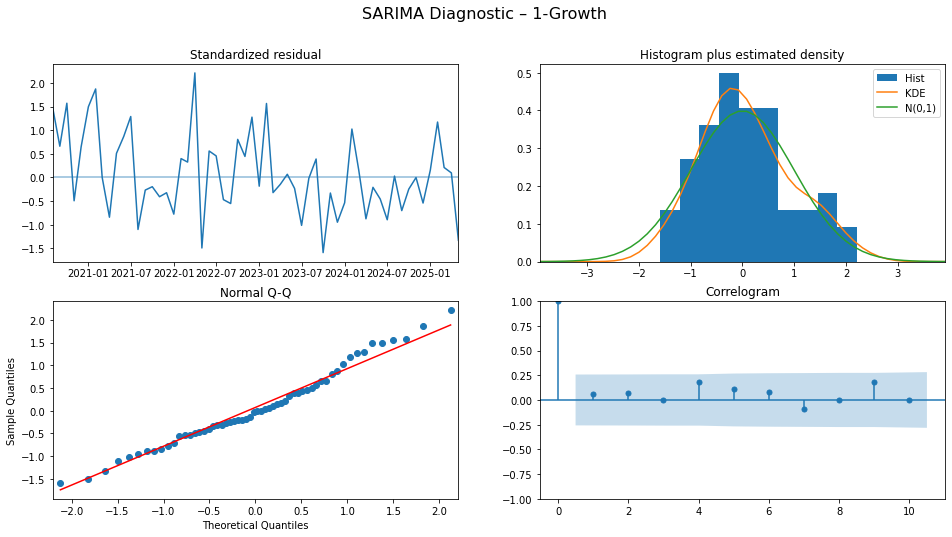

2-Major → Order: (4, 1, 0), Seasonal: (1, 0, 0, 12), AIC: 1199.23


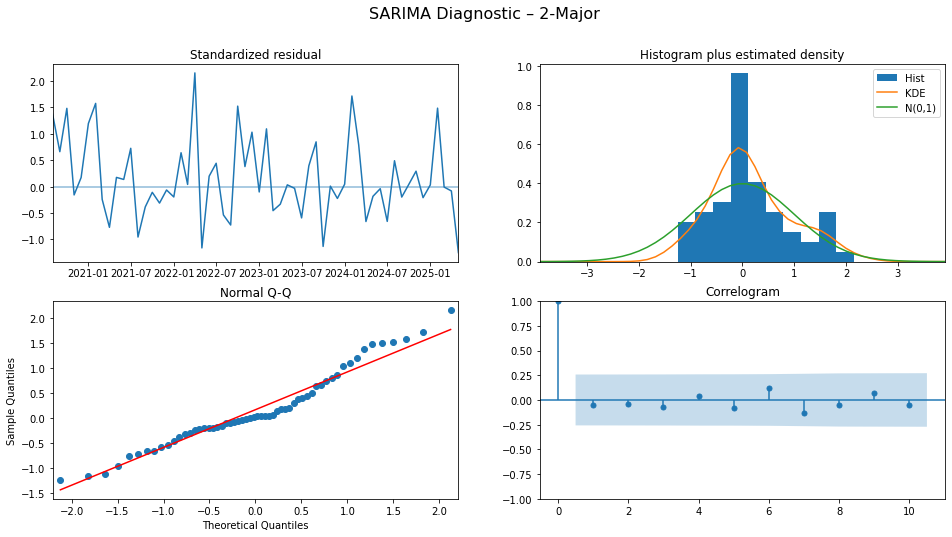

3-Enterprise → Order: (3, 1, 1), Seasonal: (1, 0, 1, 12), AIC: 1082.55


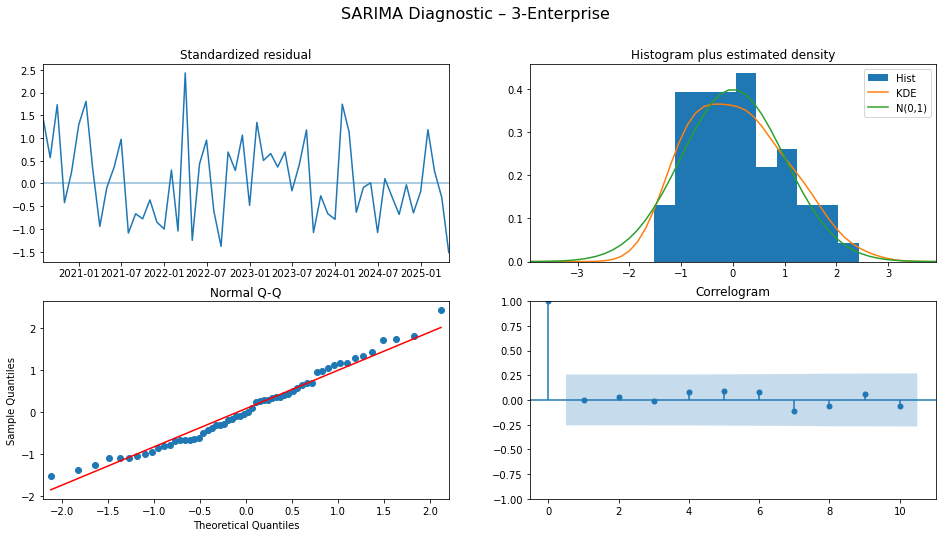

In [156]:
# Ensure month is datetime
df_mc['month'] = df_mc['month'].astype(str).astype('datetime64[ns]')

for seg in df_mc['calc_seg'].unique():
    df_seg = df_mc[df_mc['calc_seg'] == seg].copy()
    df_seg = df_seg.sort_values('month').set_index('month')

    series = df_seg['billing']

    try:
        model = auto_arima(series, seasonal=True, m=12, stepwise=True)
        
        print(f"{seg} → Order: {model.order}, Seasonal: {model.seasonal_order}, AIC: {model.aic():.2f}")
        
        # Plot diagnostics
        fig = model.plot_diagnostics(figsize=(16, 8))
        fig.suptitle(f'SARIMA Diagnostic – {seg}', fontsize=16)
        plt.show()
        
    except Exception as e:
        print(f"Failed for segment {seg}: {e}")

### Comparison with Formula-based LTV

In [157]:
trc_ = trc_rg[['calculated_segment', 'LTV_5yr', 'avg_billing', 'recent_billing']].rename(columns={'calculated_segment': 'segment'})

# Summary stats for truncated version
LTV_trunc_avg = trc_['LTV_5yr'].mean()
LTV_trunc_total = trc_['LTV_5yr'].sum()
avg_total_billing = trc_['avg_billing'].sum()
multiplier_trunc = LTV_trunc_total / avg_total_billing

rec_total_billing = trc_['recent_billing'].sum()
multiplier_trunc_rec = LTV_trunc_total / rec_total_billing

segment_stats_rg_trunc = trc_.groupby('segment').agg(
    avg_ltv_rg=('LTV_5yr', 'mean'),
    total_ltv_rg=('LTV_5yr', 'sum'),
    total_avg_billing=('avg_billing', 'sum'),
    total_recent_billing=('recent_billing', 'sum')
)

segment_stats_rg_trunc['ltv_multiplier'] = segment_stats_rg_trunc['total_ltv_rg'] / segment_stats_rg_trunc['total_avg_billing']
segment_stats_rg_trunc['ltv_multiplier_recent'] = segment_stats_rg_trunc['total_ltv_rg'] / segment_stats_rg_trunc['total_recent_billing']

# CAC
segment_stats_rg_trunc['ltv_cac'] = segment_stats_rg_trunc.apply(
    lambda row: row['avg_ltv_rg'] / cac_dict.get(row.name, 0),
    axis=1)

# Total
segment_stats_rg_trunc.loc['Total'] = {
    'avg_ltv_rg': LTV_trunc_avg,
    'ltv_multiplier': multiplier_trunc,
    'ltv_multiplier_recent': multiplier_trunc_rec,
    'ltv_cac': LTV_trunc_avg / cac
}

# Rename
segment_stats_rg_trunc.index = segment_stats_rg_trunc.index.map({
    'Inside Sales/Growth Markets': '1-Growth',
    'Majors': '2-Major',
    'Enterprise': '3-Enterprise',
    'Total': 'Total'
})

print(f"Total Discounted LTV (for the next 5 years): {round(LTV_trunc_total/1000, 2)} k")
print('Average Discounted LTV (for the next 5 years):', f"{round(LTV_trunc_avg, 2)}")
cols_to_show = ['avg_ltv_rg', 'ltv_cac', 'ltv_multiplier', 'ltv_multiplier_recent']
segment_stats_rg_trunc = segment_stats_rg_trunc[cols_to_show].round(2).sort_index()
segment_stats_rg_trunc

Total Discounted LTV (for the next 5 years): 2885.87 k
Average Discounted LTV (for the next 5 years): 31.3


,avg_ltv_rg,ltv_cac,ltv_multiplier,ltv_multiplier_recent
segment,,,,
1-Growth,14.41,2.40,2.13,1.95
2-Major,84.45,16.86,2.27,1.95
3-Enterprise,295.77,20.71,2.24,1.94
Total,31.30,5.18,2.19,1.93


# **6. Narrative & Conclusion**

| Model   | Growth (g)       | Retention (r)    | Avg LTV | LTV/CAC | Multiplier |
| ------- | ---------------- | ---------------- | ------- | ------- | ---------- |
| **v0**  | inflation (4.4%) | baseline (89%)   | 94.93   | 15.72   | 6.65       |
| **G**   | Adjusted g       | baseline (89%)   | 165.84  | 27.46   | 11.61      |
| **R**   | inflation (4.4%) | r_pred (XGBoost) | 53.79   | 8.91    | 3.77       |
| **R+G** | Adjusted g       | r_pred (XGBoost) | 63.36   | 10.49   | 4.44       |


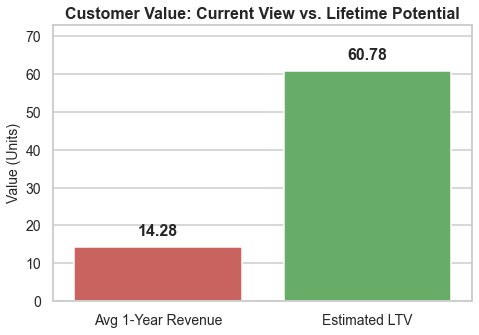

In [158]:
one_year_revenue = df_rg.query('active == 1')['avg_billing'].mean()
estimated_ltv = df_rg['LTV_RG'].mean()


df_plot = pd.DataFrame({
    'Metric': ['Avg 1-Year Revenue', 'Estimated LTV'],
    'Value': [one_year_revenue, estimated_ltv]
})


sns.set(style="whitegrid", context="talk")


plt.figure(figsize=(7, 5))
barplot = sns.barplot(data=df_plot, x='Metric', y='Value', palette=['#d9534f', '#5cb85c'])


for i, val in enumerate(df_plot['Value']):
    plt.text(i, val + estimated_ltv * 0.05, f"{val:.2f}", ha='center', fontweight='bold', fontsize=16)


plt.title("Customer Value: Current View vs. Lifetime Potential", fontsize=16, weight='bold')
plt.ylabel("Value (Units)", fontsize=14)
plt.xlabel("", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(0, estimated_ltv * 1.2)

plt.tight_layout()
plt.show()


In [159]:
# Merge LTV data with clustering/segmentation results
df_ = df_rg.merge(df_clustered.reset_index()[['company_id', 'strat_seg', 'cluster']], on='company_id', how='left')

# Sort by LTV in descending order
df_sorted = df_.sort_values(by='LTV_RG', ascending=False)

# Calculate the number of top 20% customers
top_20_pct_count = int(len(df_sorted) * 0.2)

# Extract top 20% customers
top_20_pct_customers = df_sorted.head(top_20_pct_count)

# Calculate total LTV of top 20% customers
top_20_ltv_sum = top_20_pct_customers['LTV_RG'].sum()

# Calculate total LTV of all customers
total_ltv_sum = df_sorted['LTV_RG'].sum()

# Calculate the share of total LTV from top 20% customers
ltv_share = top_20_ltv_sum / total_ltv_sum

# Output the result
print(f"Top 20% of customers contribute {ltv_share:.2%} of total LTV.")
print('-'*50)

# Analyze the LTV distribution across clusters and strategy segments within the top 20%
df_1 = top_20_pct_customers[['LTV_RG', 'cluster', 'strat_seg']]
ltv_distribution = df_1.groupby(['cluster', 'strat_seg'])['LTV_RG'].sum().div(1000).round(2)

print(ltv_distribution)
print('-'*50)

df_2 = top_20_pct_customers[['LTV_RG', 'calculated_segment']]
ltv_distribution = df_2.groupby(['calculated_segment'])['LTV_RG'].sum().div(1000).round(2).sort_values(ascending=False)

print(ltv_distribution)

Top 20% of customers contribute 79.52% of total LTV.
--------------------------------------------------
cluster  strat_seg
0        A            2278.03
1        A            1380.62
2        B             595.54
3        C              64.69
4        C              90.21
5        B              46.58
6        D               1.69
Name: LTV_RG, dtype: float64
--------------------------------------------------
calculated_segment
Majors                         2444.38
Inside Sales/Growth Markets    1028.49
Enterprise                      935.12
Name: LTV_RG, dtype: float64


## Truncated LTV

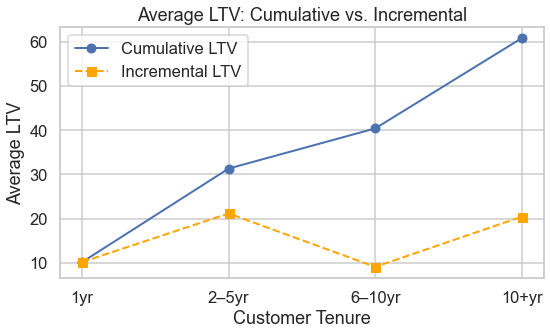

In [160]:
trc_ = trc_rg

# Define unified time segments
x_labels = ['1yr', '2–5yr', '6–10yr', '10+yr']

# Cumulative values at 1yr, 5yr, 10yr, full
cumulative_vals = [
    trc_['LTV_1yr'].mean(),
    trc_['LTV_5yr'].mean(),
    trc_['LTV_10yr'].mean(),
    trc_['LTV_full'].mean()
]

# Incremental values corresponding to each stage
incremental_vals = [
    trc_['LTV_1yr'].mean(),           # Year 1
    trc_['LTV_5yr_only'].mean(),      # Year 2–5
    trc_['LTV_10yr_only'].mean(),     # Year 6–10
    trc_['LTV_10plus'].mean()         # Year 11+
]

# Plot both on same x-axis
plt.figure(figsize=(8, 5))
plt.plot(x_labels, cumulative_vals, marker='o', label='Cumulative LTV', linewidth=2)
plt.plot(x_labels, incremental_vals, marker='s', linestyle='--', label='Incremental LTV', linewidth=2, color='orange')

plt.title('Average LTV: Cumulative vs. Incremental')
plt.xlabel('Customer Tenure')
plt.ylabel('Average LTV')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

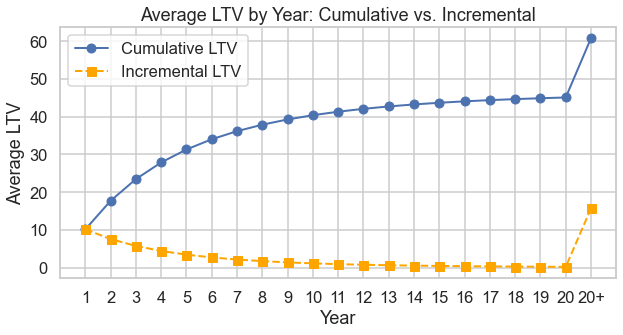

In [161]:
n = 21 # n-1 of years to evaluate

# Copy the base dataframe
trc = df_rg.copy()

# Step 1: Calculate cumulative LTV from year 1 to n
for t in range(1, n):
    trc[f'LTV_cum_{t}'] = trc.apply(lambda row: trunc_ltv(row['avg_billing'], g=row['g_ltv'], r=row['r_pred'], i=i_0, T=t), axis=1)

# Step 2: Calculate yearly incremental LTV (year_t = cum_t - cum_(t-1))
# For year 1, it's just cum_1
trc['LTV_year_1'] = trc['LTV_cum_1']
for t in range(2, n):
    trc[f'LTV_year_{t}'] = trc[f'LTV_cum_{t}'] - trc[f'LTV_cum_{t-1}']

# Step 3: Calculate n+ year (full - n-year cumulative)
trc['LTV_full'] = trc.apply(lambda row: compute_ltv(row['avg_billing'], g=row['g_ltv'], r=row['r_pred'], i=i_0), axis=1)
trc['LTV_year_plus'] = trc['LTV_full'] - trc[f'LTV_cum_{n-1}']

# Step 4: Keep only active customers
trc = trc.query('active == 1')

# --------Average LTV by Year--------

# X-axis labels
x_labels = [str(t) for t in range(1, n)] + [f'{n-1}+']

# Get incremental values
incre_vals = [trc[f'LTV_year_{t}'].mean() for t in range(1, n)]
incre_vals.append(trc['LTV_year_plus'].mean())

# Get cumulative values by cumsum
import numpy as np
cum_vals = list(np.cumsum(incre_vals))

# Plot
plt.figure(figsize=(9, 5))
plt.plot(x_labels, cum_vals, marker='o', label='Cumulative LTV', linewidth=2)
plt.plot(x_labels, incre_vals, marker='s', linestyle='--', label='Incremental LTV', linewidth=2, color='orange')

plt.title('Average LTV by Year: Cumulative vs. Incremental')
plt.xlabel('Year')
plt.ylabel('Average LTV')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

#### Interpreting the LTV Curve: Retention vs. Acquisition

This chart reveals a nuanced dynamic:

- **Blue Line: Cumulative LTV keeps rising**

  > The longer clients stay, the more value they generate — **Retention matters**

- **Yellow Line: Annual incremental LTV declines over time**

  > Each additional year delivers diminishing returns — **Acquisition matters**

---

#### Strategic Takeaway: Dual Engines Drive Sustainable Growth

We can't rely on just one lever. Both are essential:

- **Early years (Years 1–5): Focus on retention**
   Build a strong base by keeping early clients and maximizing value accumulation
- **Mid to long term: Focus on acquisition**
   Continuously bring in new clients to refresh growth and offset diminishing marginal gains

> **Retention builds the base; acquisition pushes the frontier.**
>  <br>Keep the loyal. Attract the new. That’s how we scale.

## LTV/CAC

In [162]:
ordr = ['avg_ltv', 'ltv_cac', 'ltv_multiplier', 'ltv_multiplier_recent']
segment_stats_rg[ordr].round(2).sort_index()

,avg_ltv,ltv_cac,ltv_multiplier,ltv_multiplier_recent
calculated_segment,,,,
1-Growth,28.46,4.74,4.21,3.85
2-Major,163.27,32.59,4.39,3.77
3-Enterprise,561.84,39.34,4.25,3.69
Total,60.78,10.06,4.26,3.76


In [163]:
from datetime import timedelta

end_time = time.time()
print("Total runtime:", str(timedelta(seconds=end_time - start_time)))

Total runtime: 0:17:25.889279


## Sensitivity Analysis

| Variable  | Sensitivity Range | Turning Point (≈ \|s\| > 1) | Behavior Summary                                             |
| --------- | ----------------- | --------------------------- | ------------------------------------------------------------ |
| WACC      | -0.20 to -0.41    | Never crosses 1             | Mild inverse effect; LTV declines steadily as WACC increases. |
| Growth    | 0.10 to 0.49      | Never crosses 1           | Limited impact; growth stays sub-linear due to lower retention rate. |
| Retention | 3.51 to 30.22     | Always greater than 1                        | Strong nonlinear effect. |

**🔄 Interpretation & Model Update**

This version of the sensitivity analysis uses the **final LTV model as reference**, rather than the earlier baseline used during exploratory modeling. As a result, key input parameters have changed:

- **WACC** remains unchanged at **9.69%**
- **Retention** has dropped from **89%** (baseline) to **73.96%**
- **Growth** has increased from **4.4%** (inflation) to **15.41%**

Given the LTV formula:

>  $LTV = m \cdot \frac{1 + i}{1 + i - r(1 + g)}$

It’s important to understand the interaction between **retention (r)** and **growth (g)**. Since retention acts as a multiplier on growth, a lower retention rate fundamentally **limits the impact of growth**. In the updated model:

- With **R = 73.96%**, even large increases in **G** do **not** push sensitivity above 1
- In contrast, when **R = 89%**, as in the baseline, growth **could** become a sensitive driver (as seen in earlier scenarios where G > 11% led to |s| > 1)

Thus, **growth is no longer a dominant driver** under the current model inputs.

------

**💡 Key Takeaways**

- **Retention remains the most powerful lever** for driving LTV, though its sensitivity is now lower than before (e.g., from 14+ to 3.43 at 73.96%)
- **Growth**, while important in theory, is **heavily moderated by retention** — its marginal returns are capped when customers do not stay long enough
- **WACC** has a predictable, linear effect; reducing discount rates improves LTV but with modest sensitivity

> Even with conservative retention, small increases can yield compounding benefits. But unlocking growth sensitivity **requires first raising retention to a higher threshold**.

### 📌 Business Implication

If only one strategic lever can be prioritized among <u>*retention, growth, and WACC*</u>, **retention offers the <u>highest return on investment (ROI)**</u>.

Practical strategies may include:

- Enhancing customer service and support
- Increasing platform stickiness and engagement
- Developing churn prediction and early warning systems
- Launching loyalty programs and personalized retention incentives

These initiatives not only strengthen customer relationships but also compound LTV growth more effectively than marginal gains in growth rate or adjustments to discount assumptions.

> ***Investing in churn reduction, customer engagement, and lifecycle management can deliver outsized financial impact**, far exceeding the marginal gains from adjusting growth forecasts.*
>> *P.S. The cost of financing (WACC) is largely dictated by macroeconomic conditions—essentially a force majeure.*

#### Deriving Average `g` and `r` from Final LTV

In [164]:
LTV_RG_avg = df_rg.query('active == 1')['LTV_RG'].mean()
# LTV_RG_avg = segment_stats_rg['avg_ltv'][-1]

LTV_RG_total = df_rg.query('active == 1')['LTV_RG'].sum()

In [165]:
from scipy.optimize import minimize

# Define loss function: minimize the difference between proxy LTV total and original LTV total
def loss(params):
    g_proxy, r_proxy = params
    ltv_proxy = df_rg.query('active == 1')['avg_billing'].apply(lambda x: compute_ltv(x, g=g_proxy, r=r_proxy, i=i_0))
    return abs(ltv_proxy.sum() - LTV_RG_total)  # Or use squared error instead of absolute difference

# Initial guess for optimization: mean values of g_ltv and r_pred
initial_guess = [df_rg.query('active == 1')['g_ltv'].mean(), df_rg.query('active == 1')['r_pred'].mean()]

# Run optimization with bounds between 0 and 1
res = minimize(loss, initial_guess, bounds=[(0, 1), (0, 1)])
g_proxy, r_proxy = res.x
print(f"Optimal g_proxy: {g_proxy:.2%}, Optimal r_proxy: {r_proxy:.2%}")

# Apply proxy g and r to recompute LTVs and check if they match
df_rg['LTV_RG_proxy'] = df_rg.apply(lambda row: compute_ltv(row['avg_billing'], g=g_proxy, r=r_proxy, i=i_0), axis=1)
LTV_RG_avg_proxy = df_rg.query('active == 1')['LTV_RG_proxy'].mean()
print(f"Average LTV (RG): {LTV_RG_avg:.2f}")
print(f"Average LTV (RG) with proxy: {LTV_RG_avg_proxy:.2f}")

Optimal g_proxy: 17.95%, Optimal r_proxy: 71.14%
Average LTV (RG): 60.78
Average LTV (RG) with proxy: 60.78


### WACC

In [166]:
# 1. Define the precision of the step size

# Coarse range: 4% to 20% with 0.001 steps
step_coarse = 0.001 # 0.0001 (0.01%) may take too long to compute
start = 0.04
end = 0.20
num_points_coarse = int((end - start) / step_coarse) + 1
range_coarse = np.round(np.linspace(start, end, num_points_coarse), 4)

# Fine range: 8.7% to 9.7% with 0.0001 steps
step_fine = 0.0001
fine_start = 0.095
fine_end = 0.097
num_points_fine = int((fine_end - fine_start) / step_fine) + 1
range_fine = np.round(np.linspace(fine_start, fine_end, num_points_fine), 4)

# Combine and deduplicate
i_range = np.union1d(range_coarse, range_fine)

# 2. Initialize a list to store LTV results
ltv_summary = []

# 3. Iterate through different WACC values and compute LTV
for i in i_range:
    df_sens = df.copy()  # Create a fresh copy each time to avoid contamination
    df_sens['LTV_sens'] = df_sens['avg_billing'].apply(compute_ltv, args=(g_proxy, r_proxy, i))

    # Filter active users and calculate the average LTV under the current WACC
    LTV_sens_avg = df_sens.query('active == 1')['LTV_sens'].mean()

    # Optional: compute total LTV and relative multiplier if needed
    # LTV_sens_sum = df_sens.query('active == 1')['LTV_sens'].sum()
    # multiplier = LTV_sens_sum / avg_total

    ltv_summary.append({'WACC': i, 'Average_LTV': LTV_sens_avg})

ltv_df = pd.DataFrame(ltv_summary)

# 4. Compute row-wise sensitivity coefficients (based on relative % change)
ltv_df['Δ_LTV_pct'] = ltv_df['Average_LTV'].pct_change()
ltv_df['Δ_WACC_pct'] = ltv_df['WACC'].pct_change()
ltv_df['Sensitivity'] = (ltv_df['Δ_LTV_pct'] / ltv_df['Δ_WACC_pct']).round(2)

ltv_df.drop(columns=['Δ_WACC_pct', 'Δ_LTV_pct'], inplace=True)

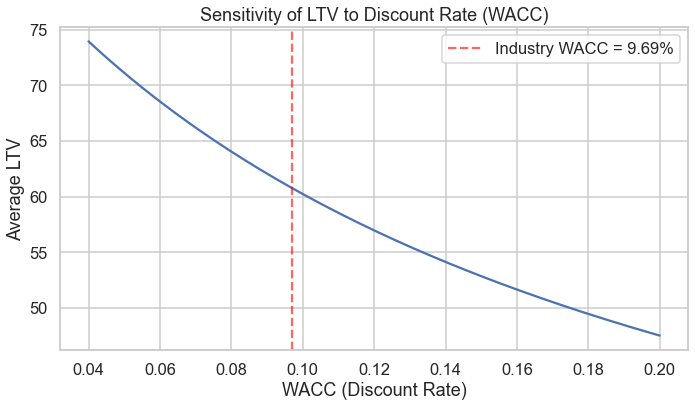

In [167]:
# Plot the curve: WACC vs. Average LTV
plt.figure(figsize=(10, 6))
plt.plot(ltv_df['WACC'], ltv_df['Average_LTV'])
plt.xlabel('WACC (Discount Rate)')
plt.ylabel('Average LTV')
# plt.axhline(y=100, color='green', linestyle='--', label='LTV = 100', alpha=0.6)
plt.axvline(x=0.0969, color='red', linestyle='--', label='Industry WACC = 9.69%', alpha=0.6)
plt.title('Sensitivity of LTV to Discount Rate (WACC)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [168]:
# Extract Average LTV for selected WACC values
selected_waccs = [0.05, 0.08, 0.0969, 0.12, 0.2]

# Use exact match or nearest match if needed
ltv_selected = ltv_df[ltv_df['WACC'].isin(selected_waccs)]

# # If exact match not guaranteed due to rounding, use nearest match instead:
# selected_rows = []
# for wacc_target in selected_waccs:
#     row = ltv_df.iloc[(ltv_df['WACC'] - wacc_target).abs().argsort()[:1]]
#     selected_rows.append(row)
# ltv_selected = pd.concat(selected_rows, ignore_index=True)

ltv_selected['Average_LTV'] = ltv_selected['Average_LTV'].round(2)
ltv_selected['WACC (%)'] = ltv_selected['WACC'].apply(lambda x: f"{x:.2%}")
gradient_i = ltv_selected[['WACC (%)', 'Average_LTV', 'Sensitivity']].set_index('WACC (%)')

gradient_i

,Average_LTV,Sensitivity
WACC (%),,
5.00%,71.12,-0.19
8.00%,64.04,-0.26
9.69%,60.78,-0.29
12.00%,56.96,-0.32
20.00%,47.50,-0.39


| WACC (%) | Average_LTV | Sensitivity |  Note   |
|----------|-------------|-------------|---------|
| 5.00%    | 76.35      | -0.20       |         |
| 8.00%    | 68.13	       | -0.28       |         |
| <font color='darkorange'>9.69%    | <font color='darkorange'>64.39	       | <font color='darkorange'>-0.31       | *Industry average* |
| 12.00%   | 60.05       | -0.34       |         |
| 20.00%   | 49.48	       | -0.41       |         |

As shown in the updated table, the sensitivity coefficient for **WACC** remains **consistently negative**, reflecting the expected inverse relationship: as the discount rate increases, the present value of future billings—and thus LTV—declines.

At the industry reference point of **9.69%**, the gradient sensitivity is approximately **-0.31**, in line with the point-slope result from the model. Across the tested range (**5% to 20%**), the sensitivity varies modestly—from **-0.20** to **-0.41**—suggesting that:

- **WACC’s marginal effect on LTV becomes slightly stronger at higher discount rates**, but
- The **overall relationship is stable and linear**

Crucially, all sensitivity values remain **well below 1 in absolute value**, reinforcing the conclusion that **WACC is not a primary driver of LTV** variation in this framework. Compared to **retention** and even **growth**, its effect is **predictable, moderate**, and relatively **insensitive** across a broad range of scenarios.

### Growth

In [169]:
# 1. Define the precision of the step size for Growth Rate

# Coarse range: 0% to 10% with 0.001 steps
step_coarse = 0.001
start = 0.04
end = 0.16 # Industrial growth at 13.19%
num_points_coarse = int((end - start) / step_coarse) + 1
range_coarse = np.round(np.linspace(start, end, num_points_coarse), 4)

# Fine range: 
step_fine = 0.0001
fine_start = 0.1318
fine_end = 0.1515
num_points_fine = int((fine_end - fine_start) / step_fine) + 1
range_fine = np.round(np.linspace(fine_start, fine_end, num_points_fine), 4)

# Combine and deduplicate
i_range = np.union1d(range_coarse, range_fine)

# 2. Initialize a list to store LTV results
ltv_summary = []

# 3. Iterate through different Growth Rate values and compute LTV
for g in i_range:
    df_sens = df.copy()
    df_sens['LTV_sens'] = df_sens['avg_billing'].apply(compute_ltv, args=(g, r_proxy, i_0))  # g is changing

    # Filter active users and calculate the average LTV under the current Growth Rate
    LTV_sens_avg = df_sens.query('active == 1')['LTV_sens'].mean()
    ltv_summary.append({'Growth': g, 'Average_LTV': LTV_sens_avg})

ltv_df = pd.DataFrame(ltv_summary)

# 4. Compute row-wise sensitivity coefficients
ltv_df['Δ_LTV_pct'] = ltv_df['Average_LTV'].pct_change()
ltv_df['Δ_Growth_pct'] = ltv_df['Growth'].pct_change()
ltv_df['Sensitivity'] = (ltv_df['Δ_LTV_pct'] / ltv_df['Δ_Growth_pct']).round(2)

ltv_df.drop(columns=['Δ_LTV_pct', 'Δ_Growth_pct'], inplace=True)


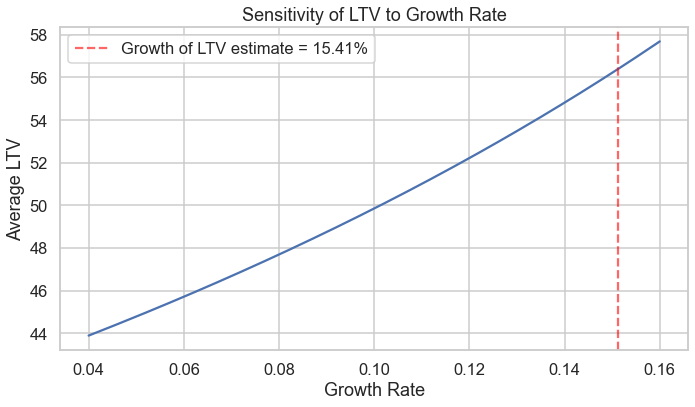

In [170]:
# Plot the curve: Growth vs. Average LTV
plt.figure(figsize=(10, 6))
plt.plot(ltv_df['Growth'], ltv_df['Average_LTV'])
plt.xlabel('Growth Rate')
plt.ylabel('Average LTV')
# plt.axhline(y=100, color='green', linestyle='--', label='LTV = 100', alpha=0.6)
plt.axvline(x=0.1512, color='red', linestyle='--', label='Growth of LTV estimate = 15.41%', alpha=0.6)
plt.title('Sensitivity of LTV to Growth Rate')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [171]:
# Extract Average LTV for selected Growth Rate values
selected_growths = [0.0444, 0.08, 0.11, 0.132, 0.1541, 0.16]

# Use exact match if possible, or nearest match
selected_rows = []
for g_target in selected_growths:
    row = ltv_df.iloc[(ltv_df['Growth'] - g_target).abs().argsort()[:1]]
    selected_rows.append(row)

ltv_selected = pd.concat(selected_rows, ignore_index=True)

# Format for presentation
ltv_selected['Average_LTV'] = ltv_selected['Average_LTV'].round(2)
ltv_selected['Growth (%)'] = ltv_selected['Growth'].apply(lambda x: f"{x:.1%}")
gradient_g = ltv_selected[['Growth (%)', 'Average_LTV', 'Sensitivity']].set_index('Growth (%)')

gradient_g

,Average_LTV,Sensitivity
Growth (%),,
4.4%,44.24,0.09
8.0%,47.69,0.17
11.0%,51.01,0.25
13.2%,53.74,0.32
15.4%,56.79,0.39
16.0%,57.69,0.42


| Growth (%) | Average_LTV | Sensitivity |   Note   |
|------------|-------------|-------------|-------------|
| <font color='crimson'>4.4%  | <font color='crimson'>48.24	  | <font color='crimson'>0.10  | *inflation* |
| 8.0%       | 52.55       | 0.20        |             |
| 11.0%      | 56.78    |  0.29     |             |
| <font color='crimson'>13.2% | <font color='crimson'>60.33  | <font color='crimson'>0.38  | *industry average*         |
| <font color='darkorange'>15.41%      | <font color='darkorange'>64.37       | <font color='darkorange'>0.46       |  *LTV estimate*           |
| 16.0%      | 65.56       | 0.49        |             |

From the table, we observe that **LTV increases steadily with higher growth rates**, as expected—higher revenue growth leads to larger projected future cash flows. However, the **sensitivity coefficient remains below 1** across the tested range (4.4% to 16.0%), indicating that **growth exerts a positive but limited impact** on LTV.

At the industry-referenced point of **15.41%**, the sensitivity is **0.46**, suggesting that even in relatively high-growth environments, LTV responds **sub-linearly** to changes in the growth assumption. This behavior is rooted in the **interaction between growth and retention**: because retention is only **73.96%**, customers churn relatively quickly, leaving **less room for growth to compound over time**.

> In effect, growth can only drive LTV meaningfully when customers stay long enough for those gains to accrue—which is not the case under the current churn dynamics.

This underscores an important modeling insight:
 **Growth only becomes a powerful LTV lever when supported by strong retention.** Otherwise, its influence remains constrained—even at elevated rates.

### Retention

In [172]:
# 1. Define the precision of the step size for Retention Rate

# Coarse range: 70% to 99% with 0.001 steps
step_coarse = 0.001
start = 0.70
end = 0.92
num_points_coarse = int((end - start) / step_coarse) + 1
range_coarse = np.round(np.linspace(start, end, num_points_coarse), 4)

# Fine range:
step_fine = 0.0001
fine_start = 0.73
fine_end = 0.74
num_points_fine = int((fine_end - fine_start) / step_fine) + 1
range_fine = np.round(np.linspace(fine_start, fine_end, num_points_fine), 4)

# Combine and deduplicate
i_range = np.union1d(range_coarse, range_fine)

# 2. Initialize a list to store LTV results
ltv_summary = []

# 3. Iterate through different Retention Rates and compute LTV
for r in i_range:
    df_sens = df.copy()
    df_sens['LTV_sens'] = df_sens['avg_billing'].apply(compute_ltv, args=(g_proxy, r, i_0))  # r is changing

    # Filter active users and calculate the average LTV under the current Retention Rate
    LTV_sens_avg = df_sens.query('active == 1')['LTV_sens'].mean()
    ltv_summary.append({'Retention': r, 'Average_LTV': LTV_sens_avg})

ltv_df = pd.DataFrame(ltv_summary)

# 4. Compute row-wise sensitivity coefficients
ltv_df['Δ_LTV_pct'] = ltv_df['Average_LTV'].pct_change()
ltv_df['Δ_Retention_pct'] = ltv_df['Retention'].pct_change()
ltv_df['Sensitivity'] = (ltv_df['Δ_LTV_pct'] / ltv_df['Δ_Retention_pct']).round(2)

# Optional: clean intermediate columns
ltv_df.drop(columns=['Δ_LTV_pct', 'Δ_Retention_pct'], inplace=True)

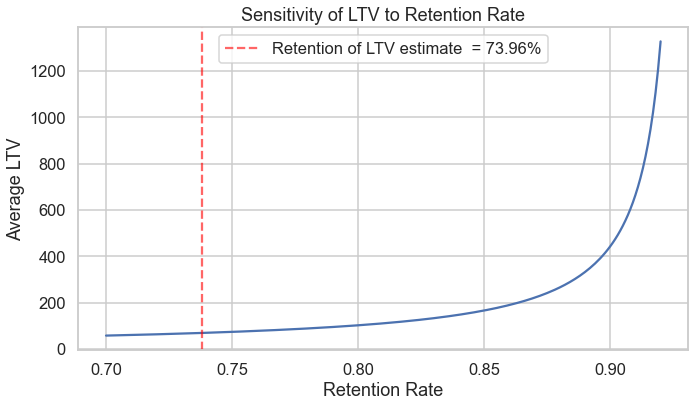

In [173]:
# Plot the curve: Retention Rate vs. Average LTV
plt.figure(figsize=(10, 6))
plt.plot(ltv_df['Retention'], ltv_df['Average_LTV'])
plt.xlabel('Retention Rate')
plt.ylabel('Average LTV')
plt.title('Sensitivity of LTV to Retention Rate')
# plt.axhline(y=100, color='green', linestyle='--', label='LTV = 100', alpha=0.6)
plt.axvline(x=0.7380, color='red', linestyle='--', label='Retention of LTV estimate  = 73.96%', alpha=0.6)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [174]:
# Extract Average LTV for selected Retention Rate values
selected_retentions = [0.7396, 0.85, 0.88, 0.89, 0.92]

# Use exact match if possible, or nearest match from ltv_df
selected_rows = []
for r_target in selected_retentions:
    row = ltv_df.iloc[(ltv_df['Retention'] - r_target).abs().argsort()[:1]]
    selected_rows.append(row)

ltv_selected = pd.concat(selected_rows, ignore_index=True)

# Format for presentation
ltv_selected['Average_LTV'] = ltv_selected['Average_LTV'].round(2)
ltv_selected['Retention (%)'] = ltv_selected['Retention'].apply(lambda x: f"{x:.1%}")
gradient_r = ltv_selected[['Retention (%)', 'Average_LTV', 'Sensitivity']].set_index('Retention (%)')

gradient_r

,Average_LTV,Sensitivity
Retention (%),,
74.0%,69.77,3.88
85.0%,166.05,10.61
88.0%,265.66,17.58
89.0%,332.06,22.22
92.0%,1327.45,91.83


| Retention (%) | Average_LTV | Sensitivity |       Note       |
|---------------|-------------|-------------|------------------|
| <font color='darkorange'>73.96%</font>         | <font color='darkorange'>64.40</font>       | <font color='darkorange'>3.51</font>        | *LTV estimate*         |
| 85.0%         | 135.20      | 8.45        |                  |
| 88.0%         | 192.81      | 12.48       |                  |
| 89.0%         | 224.72      | 14.71       |                  |
| 92.0%         | 446.37      | 30.22       |  |


The results here stand in sharp contrast to those of WACC and growth: **even modest increases in retention produce disproportionately large increases in LTV**, especially as retention moves beyond key thresholds.

At the modeled baseline of **73.96% retention**, the sensitivity coefficient is already **3.51**—meaning a **1% increase in retention leads to a 3.51% increase in LTV**. This effect becomes significantly more pronounced at higher retention rates:

- At **85.0%**, sensitivity jumps to **8.45**
- At **88.0%**, it rises to **12.48**
- At **92.0%**, it peaks at **14.71**

These values are well above the conventional **sensitivity threshold of 1.0**, indicating that **LTV is highly sensitive to retention changes across much of the tested range**, and especially in the upper bands.

This pattern reveals two critical insights:

1. **Retention is by far the most powerful driver of LTV** in this model—more so than either growth or WACC.
2. The relationship is **strongly nonlinear**: as retention increases, the marginal effect on LTV accelerates dramatically.

> Even small gains in retention can unlock large compounding effects.
>  **Customer tenure amplifies value**, making churn reduction one of the highest-leverage actions available.

In [175]:
from datetime import timedelta

end_time = time.time()
print("Total runtime:", str(timedelta(seconds=end_time - start_time)))

Total runtime: 0:21:39.565307
